In [16]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


here the objective is to fit the logit graph model to the brain graphs and then 
visualize the original vs fitted graphs

In [17]:
import sys
import os
sys.path.append('../')

#Graph imports
import src.graph as graph
import src.logit_estimator as estimator
import src.utils as utils
import src.model_selection as model_selection
import src.gic as gic
import src.param_estimator as pe
import src.graph as graph
import src.model_selection as ms

# usual imports
import matplotlib.pyplot as plt
import pickle
import math
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import gaussian_kde
import numpy as np
import pandas as pd
import seaborn as sns
import gc
import random
import networkx as nx
from numpy import errstate

from IPython.display import display
from pyvis.network import Network
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [18]:
PATH = f'../data/connectomes/brain_graph/'

DATASETS = ['repeated_10_scale_33',
            'repeated_10_scale_60',
            'repeated_10_scale_125',
            'repeated_10_scale_250'
            ]

files = []
for DATASET in DATASETS:
    # sort 10 graphs for each dataset
    for file in sorted(os.listdir(PATH+DATASET))[:10]:
        if file.endswith('.graphml'):
            files.append(os.path.join(PATH+DATASET, file))

print(files[:4])


['../data/connectomes/brain_graph/repeated_10_scale_33/100206_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100307_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100408_repeated10_scale33.graphml', '../data/connectomes/brain_graph/repeated_10_scale_33/100610_repeated10_scale33.graphml']


In [19]:

def get_logit_graph(real_graph, d, n_iteration, warm_up, patience, dist_type='KL', edge_delta=None, min_gic_threshold=None, verbose=True):
   """
   Estimates parameters, generates a graph using the Logit Graph model,
   and calculates GIC, allowing for different convergence criteria.

   Args:
       real_graph (nx.Graph or np.ndarray): The target graph.
       d (int): Parameter for the Logit model (number of neighbors).
       n_iteration (int): Maximum number of iterations for graph generation.
       warm_up (int): Number of initial iterations to discard.
       patience (int): Number of iterations to wait for improvement before stopping.
       dist_type (str): Distance type for GIC ('KL', 'L1', 'L2').
       convergence_criteria (str): Criterion for stopping ('spectrum' or 'spectrum_and_edges').

   Returns:
       tuple: Contains the best generated graph, sigma, GIC values,
              spectrum differences, edge differences, best iteration index, and all graphs.
   """
   # Ensure real_graph is a NumPy array
   if isinstance(real_graph, nx.Graph):
       real_graph = nx.to_numpy_array(real_graph)

   # Estimation
   est = estimator.LogitRegEstimator(real_graph, d=d)
   features, labels = est.get_features_labels()
   # Using default L1 regularization as before, adjust if needed
   result, params, pvalue = est.estimate_parameters(l1_wt=1, alpha=0, features=features, labels=labels)
   sigma = params[0]

   # Generation
   n = real_graph.shape[0]

   params_dict = {
      "n": n,
      "d": d,
      "sigma": sigma,
      "n_iteration": n_iteration,
      "warm_up": warm_up,
      "patience": patience,
      "edge_delta": edge_delta,
   }

   graph_model = graph.GraphModel(n=n, d=d, sigma=sigma)

   print(f"Running generation with convergence criterion: {edge_delta}")
   
   graphs, spec, spectrum_diffs, best_iteration, best_graph_arr = graph_model.populate_edges_spectrum_min_gic(
        max_iterations=n_iteration,
        # warm_up=warm_up,
        patience=patience,
        real_graph=real_graph,
        edge_delta=edge_delta,
        min_gic_threshold=min_gic_threshold,
        gic_dist_type=dist_type,
        verbose=verbose,
    )


   print(f"Finish generation with convergence criterion: {edge_delta}")
   # Calculate edge differences
   real_edges = np.sum(real_graph) / 2
   edge_diffs = [abs(np.sum(g) / 2 - real_edges) for g in graphs]

   # Use the best graph found based on the selected criteria/iteration
   # best_graph = graphs[best_iteration]

   # Calculate GIC for the best graph
   best_graph_nx = nx.from_numpy_array(best_graph_arr)
   gic_value = gic.GraphInformationCriterion(
       graph=nx.from_numpy_array(real_graph),
       log_graph=best_graph_nx,
       model='LG',
       dist_type=dist_type
   ).calculate_gic()

   return best_graph_arr, sigma, [gic_value], spectrum_diffs, edge_diffs, best_iteration, graphs



# single model LG fitting

Here we fit and visualize the logit graph model to the brain graphs

In [9]:
def visualize_original_vs_fitted_graphs(results, figsize=(20, 12), node_size=30, font_size=8, edge_width=0.5, graphs_per_plot=10):
    """
    Visualize original graphs vs fitted LG graphs with GIC values.
    Creates multiple plots with up to graphs_per_plot graphs each.
    
    Parameters:
    -----------
    results : dict
        Results from fit_logit_graphs_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    graphs_per_plot : int
        Number of graphs to display per plot
    
    Returns:
    --------
    figs : list
        List of matplotlib.figure.Figure objects
    """
    n_graphs = len(results['original_graphs'])
    
    # Calculate number of plots needed
    n_plots = (n_graphs + graphs_per_plot - 1) // graphs_per_plot
    
    figs = []
    
    # Color schemes
    original_node_color = '#4472C4'  # Blue for original
    fitted_node_color = '#E74C3C'    # Red for fitted
    edge_color = '#8B8B8B'           # Gray for edges
    
    for plot_idx in range(n_plots):
        start_idx = plot_idx * graphs_per_plot
        end_idx = min(start_idx + graphs_per_plot, n_graphs)
        current_n_graphs = end_idx - start_idx
        
        # Create subplot grid: 2 rows (original vs fitted), current_n_graphs columns
        fig, axes = plt.subplots(2, current_n_graphs, figsize=figsize)
        
        # Handle single graph case
        if current_n_graphs == 1:
            axes = axes.reshape(2, 1)
        
        for i in range(current_n_graphs):
            graph_idx = start_idx + i
            original_graph = results['original_graphs'][graph_idx]
            fitted_graph = results['fitted_graphs'][graph_idx]
            gic_value = results['gic_values'][graph_idx]
            stats = results['graph_stats'][graph_idx]
            
            # Plot original graph (top row)
            ax_orig = axes[0, i] if current_n_graphs > 1 else axes[0]
            pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                                  node_color=original_node_color, node_size=node_size, alpha=0.8)
            
            ax_orig.set_title(f'Original Graph {graph_idx+1}\n({stats["original_nodes"]} nodes, {stats["original_edges"]} edges)',
                             fontsize=font_size+2, fontweight='bold', pad=10)
            ax_orig.axis('off')
            
            # Plot fitted graph (bottom row)
            ax_fitted = axes[1, i] if current_n_graphs > 1 else axes[1]
            
            if fitted_graph is not None and results['fit_success'][graph_idx]:
                pos_fitted = nx.spring_layout(fitted_graph, k=1, iterations=50, seed=42)
                
                nx.draw_networkx_edges(fitted_graph, pos_fitted, ax=ax_fitted,
                                      edge_color=edge_color, width=edge_width, alpha=0.6)
                nx.draw_networkx_nodes(fitted_graph, pos_fitted, ax=ax_fitted,
                                      node_color=fitted_node_color, node_size=node_size, alpha=0.8)
                
                title = f'Fitted LG Graph {graph_idx+1}\n({stats["fitted_nodes"]} nodes, {stats["fitted_edges"]} edges)\nGIC: {gic_value:.4f}'
            else:
                title = f'Fitted LG Graph {graph_idx+1}\n(Fitting Failed)'
            
            ax_fitted.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
            ax_fitted.axis('off')
        
        # Add overall title for this plot
        fig.suptitle(f'Original Brain Connectomes vs Fitted Logit Graph Models (Graphs {start_idx+1}-{end_idx})', 
                    fontsize=16, fontweight='bold', y=0.95)
        
        plt.tight_layout(rect=[0, 0.03, 1, 0.92])
        figs.append(fig)
    
    return figs


In [10]:
def fit_logit_graphs_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit logit graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing original graphs, fitted graphs, and GIC values
    """
    if sim_params is None:
        sim_params = {
            "d": 0,
            "n_iteration": 10000,  # Reduced for faster computation
            "warm_up": 500,
            "patience": 2000,
            "dist_type": 'KL',
            "min_gic_threshold": 5,
            "verbose": True,
        }
    
    results = {
        'original_graphs': [],
        'fitted_graphs': [],
        'gic_values': [],
        'fit_success': [],
        'graph_stats': []
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*20} Processing Graph {i+1}/{n_graphs} {'='*20}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        try:
            # Fit logit graph model
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=sim_params["d"],
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=None,  # Use spectrum convergence only
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"],
            )
            
            fitted_adj_matrix = logit_results[0]
            fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
            gic_value = logit_results[2][0]
            best_iteration = logit_results[5]
            
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(fitted_graph)
            results['gic_values'].append(gic_value)
            results['fit_success'].append(True)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': fitted_graph.number_of_nodes(),
                'fitted_edges': fitted_graph.number_of_edges(),
                'best_iteration': best_iteration
            })
            
            print(f"Fitting successful - GIC: {gic_value:.4f}, Best iteration: {best_iteration}")
            print(f"Fitted graph - Nodes: {fitted_graph.number_of_nodes()}, Edges: {fitted_graph.number_of_edges()}")
            
        except Exception as e:
            print(f"Error fitting graph {i+1}: {e}")
            results['original_graphs'].append(original_graph)
            results['fitted_graphs'].append(None)
            results['gic_values'].append(np.nan)
            results['fit_success'].append(False)
            results['graph_stats'].append({
                'original_nodes': n_nodes,
                'original_edges': n_edges,
                'fitted_nodes': 0,
                'fitted_edges': 0,
                'best_iteration': 0
            })
        
        gc.collect()  # Clean up memory
    
    return results


In [11]:
def print_fitting_summary(results):
    """Print summary of fitting results and return a dataframe."""
    import pandas as pd
    
    n_graphs = len(results['original_graphs'])
    successful_fits = sum(results['fit_success'])
    
    print(f"\n{'='*50}")
    print(f"LOGIT GRAPH FITTING SUMMARY")
    print(f"{'='*50}")
    print(f"Total graphs processed: {n_graphs}")
    print(f"Successful fits: {successful_fits}/{n_graphs}")
    print(f"Success rate: {successful_fits/n_graphs*100:.1f}%")
    
    if successful_fits > 0:
        valid_gics = [gic for gic, success in zip(results['gic_values'], results['fit_success']) 
                     if success and not np.isnan(gic)]
        if valid_gics:
            print(f"\nGIC Statistics:")
            print(f"  Mean GIC: {np.mean(valid_gics):.4f}")
            print(f"  Std GIC: {np.std(valid_gics):.4f}")
            print(f"  Min GIC: {np.min(valid_gics):.4f}")
            print(f"  Max GIC: {np.max(valid_gics):.4f}")
    
    print(f"\nDetailed Results:")
    
    # Create dataframe with detailed results
    df_data = []
    for i, (gic, success, stats) in enumerate(zip(results['gic_values'], results['fit_success'], results['graph_stats'])):
        status = "SUCCESS" if success else "FAILED"
        gic_value = gic if success and not np.isnan(gic) else np.nan
        
        print(f"  Graph {i+1}: {status} | GIC: {gic_value if not np.isnan(gic_value) else 'N/A'} | "
              f"Orig: {stats['original_nodes']}n/{stats['original_edges']}e | "
              f"Fitted: {stats['fitted_nodes']}n/{stats['fitted_edges']}e")
        
        df_data.append({
            'graph_id': i+1,
            'status': status,
            'fit_success': success,
            'gic_value': gic_value,
            'original_nodes': stats['original_nodes'],
            'original_edges': stats['original_edges'],
            'fitted_nodes': stats['fitted_nodes'],
            'fitted_edges': stats['fitted_edges'],
            'best_iteration': stats['best_iteration']
        })
    
    df = pd.DataFrame(df_data)
    return df


In [12]:
# Define simulation parameters for faster computation on multiple graphs
sim_params = {
    "d": 0,
    "n_iteration": 8000,   # Reduced for faster computation
    "warm_up": 500,
    "patience": 1500,      # Reduced patience
    "dist_type": 'KL',
    "min_gic_threshold": 5,
    "verbose": True,
}

# Fit logit graphs to the first 5 graphs
print("Starting logit graph fitting experiment...")
fitting_results = fit_logit_graphs_to_dataset(graphs, n_graphs=30, sim_params=sim_params)

Starting logit graph fitting experiment...

==================== Processing Graph 1/30 ====================
Original graph - Nodes: 129, Edges: 1378
Running generation with convergence criterion: None
iteration: 0
	 Current GIC (KL): inf (Threshold: 5)
	 Best Spectrum Diff: inf
	 Patience: 0/1500
	 Current edges: 0.0 (Real edges: 1378.0)


KeyboardInterrupt: 

In [30]:
import pickle
import os
os.makedirs(f'runs/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.pkl', 'wb') as f:
    pickle.dump(fitting_results, f)


In [ ]:
# Print summary of results
df_results = print_fitting_summary(fitting_results)
df_results.to_csv(f'runs/fitting_results_braingraph_{DATASET}/fitting_results.csv', index=False)

In [ ]:
display(df_results.head()), df_results['gic_value'].describe()

In [ ]:
# Create the comparison visualization
fig_comparison = visualize_original_vs_fitted_graphs(
    fitting_results, 
    figsize=(23, 12), 
    node_size=30, 
    font_size=8, 
    edge_width=0.5
)

In [46]:
import os
os.makedirs(f'../images/fitting_results_braingraph_{DATASET}', exist_ok=True)
with open(f'../images/fitting_results_braingraph_{DATASET}/original_vs_fitted_lg_graphs.pkl', 'wb') as f:
    pickle.dump(fig_comparison, f)

# Comparision LG with other models

here we compare the logit graph model with other models

In [20]:
def create_summary_dataframe(graph_results):
    """Create a summary DataFrame from the results."""
    df_data = []
    
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        original_nodes = graph_result['original_nodes']
        original_edges = graph_result['original_edges']
        
        for model_name, model_data in graph_result['models'].items():
            df_data.append({
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'],
                'param': model_data['param'],
                'fit_success': model_data['fit_success'],
                'original_nodes': original_nodes,
                'original_edges': original_edges,
                'fitted_nodes': model_data['fitted_nodes'],
                'fitted_edges': model_data['fitted_edges'],
                'best_iteration': model_data['best_iteration']
            })
    
    return pd.DataFrame(df_data)


In [21]:
def clean_and_convert(param):
    """Clean and convert parameter string to float."""
    cleaned_param = ''.join(c for c in str(param) if c.isdigit() or c == '.' or c == '-')
    try:
        return float(cleaned_param)
    except:
        return np.nan


def fit_multiple_models_to_dataset(graphs, n_graphs=5, sim_params=None):
    """
    Fit LG and other random graph models to the first n graphs in the dataset.
    
    Parameters:
    -----------
    graphs : list
        List of NetworkX graphs
    n_graphs : int
        Number of graphs to process
    sim_params : dict
        Simulation parameters for logit graph fitting
    
    Returns:
    --------
    results : dict
        Dictionary containing all results for each graph and model, including fitted_graphs dict
    """
    results = {
        'graph_results': [],  # List of results for each graph
        'summary_df': None,
        'fitted_graphs': {}  # Dict with graph names as keys and fitted graphs as values
    }
    
    n_graphs = min(n_graphs, len(graphs))
    
    for i in range(n_graphs):
        print(f"\n{'='*30} Processing Graph {i+1}/{n_graphs} {'='*30}")
        
        original_graph = graphs[i]
        adj_matrix = nx.to_numpy_array(original_graph)
        n_nodes = original_graph.number_of_nodes()
        n_edges = original_graph.number_of_edges()
        
        print(f"Original graph - Nodes: {n_nodes}, Edges: {n_edges}")
        
        graph_result = {
            'graph_id': i+1,
            'original_graph': original_graph,
            'original_nodes': n_nodes,
            'original_edges': n_edges,
            'models': {}
        }
        
        # 1. Fit Logit Graph (LG) model
        best_logit_results = None
        best_gic = np.inf
        for d in sim_params["d_list"]:
            print(f"\n--- Fitting Logit Graph (LG) for d={d}---")
            logit_results = get_logit_graph(
                real_graph=adj_matrix.copy(),
                d=d,
                n_iteration=sim_params["n_iteration"],
                warm_up=sim_params["warm_up"],
                patience=sim_params["patience"],
                dist_type=sim_params["dist_type"],
                edge_delta=sim_params["edge_delta"],
                min_gic_threshold=sim_params["min_gic_threshold"],
                verbose=sim_params["verbose"]
            )
            if logit_results[2][0] < best_gic:
                best_gic = logit_results[2][0]
                best_logit_results = logit_results
        
        fitted_adj_matrix = best_logit_results[0]
        fitted_graph = nx.from_numpy_array(fitted_adj_matrix)
        gic_value = best_logit_results[2][0]
        sigma = best_logit_results[1]
        best_iteration = best_logit_results[4]
        
        graph_result['models']['LG'] = {
            'fitted_graph': fitted_graph,
            'gic_value': gic_value,
            'param': sigma,
            'fit_success': True,
            'fitted_nodes': fitted_graph.number_of_nodes(),
            'fitted_edges': fitted_graph.number_of_edges(),
            'best_iteration': best_iteration
        }
        
        # Add to fitted_graphs dict
        results['fitted_graphs'][f'graph_{i+1}_LG'] = fitted_graph
        
        print(f"LG fitting successful - GIC: {gic_value:.4f}, Sigma: {sigma:.4f}")
            
        # 2. Fit other random graph models
        print("\n--- Fitting Other Random Graph Models ---")
        
        # Create model selector
        selector = ms.GraphModelSelection(
            graph=original_graph,
            log_graphs=[fitted_graph] if graph_result['models']['LG']['fit_success'] else [original_graph],
            log_params=[graph_result['models']['LG']['param']] if graph_result['models']['LG']['fit_success'] else [1.0],
            models=["ER", "WS", "GRG", "BA"],
            n_runs=5,
            parameters=[{'lo': 0.01, 'hi': 1},  # ER
                        {'k': {'lo': 2, 'hi': 20, 'step': 2}, 'p': {'lo': 0.01, 'hi': 1}},  # WS
                        {'lo': 1, 'hi': 3},     # GRG
                        {'lo': 1, 'hi': 5},     # BA
            ]
        )
        
        model_results = selector.select_model_avg_spectrum()
        
        for estimate in model_results['estimates']:
            model_name = estimate['model']
            if model_name != 'LG':  # LG already processed
                param = clean_and_convert(estimate['param'])
                gic_value = estimate['GIC']
                
                # Generate the fitted graph
                func = selector.model_function(model_name=model_name)
                fitted_graph = func(n_nodes, param)
                
                graph_result['models'][model_name] = {
                    'fitted_graph': fitted_graph,
                    'gic_value': gic_value,
                    'param': param,
                    'fit_success': True,
                    'fitted_nodes': fitted_graph.number_of_nodes(),
                    'fitted_edges': fitted_graph.number_of_edges(),
                    'best_iteration': None
                }
                
                # Add to fitted_graphs dict
                results['fitted_graphs'][f'graph_{i+1}_{model_name}'] = fitted_graph
                
                print(f"{model_name} fitting - GIC: {gic_value:.4f}, Param: {param:.4f}")
                
        
        results['graph_results'].append(graph_result)
        gc.collect()  # Clean up memory
    
    # Create summary DataFrame
    results['summary_df'] = create_summary_dataframe(results['graph_results'])
    
    return results


In [37]:

def visualize_model_comparison(results, figsize=(25, 15), node_size=30, font_size=8, edge_width=0.5):
    """
    Visualize original graphs vs LG vs best fitting model for each graph.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    graph_results = results['graph_results']
    n_graphs = len(graph_results)
    
    # Create subplot grid: 3 rows (original, LG, best model), n_graphs columns
    fig, axes = plt.subplots(3, n_graphs, figsize=figsize)
    
    # Handle single graph case
    if n_graphs == 1:
        axes = axes.reshape(3, 1)
    
    # Color schemes
    original_color = '#4472C4'    # Blue for original
    lg_color = '#E74C3C'          # Red for LG
    best_color = '#2ECC71'        # Green for best model
    edge_color = '#8B8B8B'        # Gray for edges
    
    for i, graph_result in enumerate(graph_results):
        original_graph = graph_result['original_graph']
        lg_data = graph_result['models']['LG']
        
        # Find best model (lowest GIC)
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model_name = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_model_data = valid_models[best_model_name]
        else:
            best_model_name = "None"
            best_model_data = None
        
        # Plot original graph (top row)
        ax_orig = axes[0, i]
        pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                              edge_color=edge_color, width=edge_width, alpha=0.6)
        nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                              node_color=original_color, node_size=node_size, alpha=0.8)
        
        ax_orig.set_title(f'Original Graph {i+1}\n({graph_result["original_nodes"]} nodes\n, {graph_result["original_edges"]} edges)',
                         fontsize=font_size+2, fontweight='bold', pad=10)
        ax_orig.axis('off')
        
        # Plot LG fitted graph (middle row)
        ax_lg = axes[1, i]
        
        if lg_data['fitted_graph'] is not None and lg_data['fit_success']:
            pos_lg = nx.spring_layout(lg_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  node_color=lg_color, node_size=node_size, alpha=0.8)
            
            title = f'LG Model\n({lg_data["fitted_nodes"]} nodes, {lg_data["fitted_edges"]} edges)\nGIC: {lg_data["gic_value"]:.4f}'
        else:
            title = f'LG Model\n(Fitting Failed)'
        
        ax_lg.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_lg.axis('off')
        
        # Plot best model (bottom row)
        ax_best = axes[2, i]
        
        if best_model_data is not None and best_model_data['fitted_graph'] is not None:
            pos_best = nx.spring_layout(best_model_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  node_color=best_color, node_size=node_size, alpha=0.8)
            
            title = f'Best Model: {best_model_name}\n({best_model_data["fitted_nodes"]} nodes, {best_model_data["fitted_edges"]} edges)\nGIC: {best_model_data["gic_value"]:.4f}'
        else:
            title = f'Best Model: {best_model_name}\n(No valid fits)'
        
        ax_best.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_best.axis('off')
    
    # Add overall title
    fig.suptitle('Brain Connectomes: Original vs LG vs Best Random Graph Model', 
                fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    return fig

def calculate_graph_attributes(graph):
    """
    Calculate various graph attributes for a given graph.
    
    Parameters:
    -----------
    graph : networkx.Graph
        The graph to analyze
    
    Returns:
    --------
    dict : Dictionary containing graph attributes
    """
    if graph is None or graph.number_of_nodes() == 0:
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }
    
    try:
        # Basic properties
        density = nx.density(graph)
        transitivity = nx.transitivity(graph)
        
        # Centrality measures
        degree_centrality = nx.degree_centrality(graph)
        betweenness_centrality = nx.betweenness_centrality(graph)
        closeness_centrality = nx.closeness_centrality(graph)
        
        # Eigenvector centrality (handle disconnected graphs)
        try:
            eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
        except:
            eigenvector_centrality = {node: 0 for node in graph.nodes()}
        
        # Clustering coefficient
        clustering_coefficient = nx.clustering(graph)
        
        # Path-based measures (only for connected graphs)
        if nx.is_connected(graph):
            average_path_length = nx.average_shortest_path_length(graph)
            diameter = nx.diameter(graph)
        else:
            # For disconnected graphs, calculate on largest component
            largest_cc = max(nx.connected_components(graph), key=len)
            largest_subgraph = graph.subgraph(largest_cc)
            if len(largest_cc) > 1:
                average_path_length = nx.average_shortest_path_length(largest_subgraph)
                diameter = nx.diameter(largest_subgraph)
            else:
                average_path_length = 0
                diameter = 0
        
        # Assortativity
        try:
            assortativity = nx.degree_assortativity_coefficient(graph)
        except:
            assortativity = np.nan
        
        # Component analysis
        components = list(nx.connected_components(graph))
        number_of_components = len(components)
        largest_component_size = len(max(components, key=len)) if components else 0
        
        return {
            'degree_centrality_mean': np.mean(list(degree_centrality.values())),
            'degree_centrality_std': np.std(list(degree_centrality.values())),
            'betweenness_centrality_mean': np.mean(list(betweenness_centrality.values())),
            'betweenness_centrality_std': np.std(list(betweenness_centrality.values())),
            'closeness_centrality_mean': np.mean(list(closeness_centrality.values())),
            'closeness_centrality_std': np.std(list(closeness_centrality.values())),
            'eigenvector_centrality_mean': np.mean(list(eigenvector_centrality.values())),
            'eigenvector_centrality_std': np.std(list(eigenvector_centrality.values())),
            'clustering_coefficient_mean': np.mean(list(clustering_coefficient.values())),
            'clustering_coefficient_std': np.std(list(clustering_coefficient.values())),
            'average_path_length': average_path_length,
            'diameter': diameter,
            'density': density,
            'transitivity': transitivity,
            'assortativity': assortativity,
            'number_of_components': number_of_components,
            'largest_component_size': largest_component_size
        }
    
    except Exception as e:
        print(f"Error calculating graph attributes: {e}")
        return {
            'degree_centrality_mean': np.nan,
            'degree_centrality_std': np.nan,
            'betweenness_centrality_mean': np.nan,
            'betweenness_centrality_std': np.nan,
            'closeness_centrality_mean': np.nan,
            'closeness_centrality_std': np.nan,
            'eigenvector_centrality_mean': np.nan,
            'eigenvector_centrality_std': np.nan,
            'clustering_coefficient_mean': np.nan,
            'clustering_coefficient_std': np.nan,
            'average_path_length': np.nan,
            'diameter': np.nan,
            'density': np.nan,
            'transitivity': np.nan,
            'assortativity': np.nan,
            'number_of_components': np.nan,
            'largest_component_size': np.nan
        }

def analyze_fitted_graphs_attributes(results):
    """
    Calculate graph attributes for all fitted graphs in the results.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    
    Returns:
    --------
    dict : Dictionary containing graph attributes for all graphs
    """
    graph_attributes = {}
    
    print("Calculating graph attributes for fitted graphs...")
    
    # Analyze original graphs
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        original_graph = graph_result['original_graph']
        
        print(f"Analyzing original graph {graph_id}...")
        graph_attributes[f'graph_{graph_id}_original'] = calculate_graph_attributes(original_graph)
        
        # Analyze fitted models
        for model_name, model_data in graph_result['models'].items():
            if model_data['fit_success'] and model_data['fitted_graph'] is not None:
                print(f"Analyzing {model_name} model for graph {graph_id}...")
                graph_attributes[f'graph_{graph_id}_{model_name}'] = calculate_graph_attributes(model_data['fitted_graph'])
    
    return graph_attributes

def create_attributes_comparison_dataframe(results, graph_attributes):
    """
    Create a DataFrame comparing graph attributes across models.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    graph_attributes : dict
        Graph attributes from analyze_fitted_graphs_attributes
    
    Returns:
    --------
    pandas.DataFrame : DataFrame with graph attributes comparison
    """
    rows = []
    
    for graph_result in results['graph_results']:
        graph_id = graph_result['graph_id']
        
        # Add original graph
        orig_attrs = graph_attributes.get(f'graph_{graph_id}_original', {})
        row = {
            'graph_id': graph_id,
            'model': 'Original',
            'gic_value': np.nan,
            'fit_success': True,
            **orig_attrs
        }
        rows.append(row)
        
        # Add fitted models
        for model_name, model_data in graph_result['models'].items():
            attrs = graph_attributes.get(f'graph_{graph_id}_{model_name}', {})
            row = {
                'graph_id': graph_id,
                'model': model_name,
                'gic_value': model_data['gic_value'] if model_data['fit_success'] else np.nan,
                'fit_success': model_data['fit_success'],
                **attrs
            }
            rows.append(row)
    
    return pd.DataFrame(rows)

def print_model_comparison_summary(results):
    """Print summary of model comparison results."""
    df = results['summary_df']
    graph_results = results['graph_results']
    
    print(f"\n{'='*60}")
    print(f"MODEL COMPARISON SUMMARY")
    print(f"{'='*60}")
    print(f"Total graphs processed: {len(graph_results)}")
    
    # Success rates by model
    print(f"\nSuccess Rates by Model:")
    for model in df['model'].unique():
        model_df = df[df['model'] == model]
        success_rate = model_df['fit_success'].mean() * 100
        print(f"  {model}: {success_rate:.1f}%")
    
    # GIC statistics by model
    print(f"\nGIC Statistics by Model:")
    for model in df['model'].unique():
        model_df = df[(df['model'] == model) & (df['fit_success'] == True)]
        if len(model_df) > 0:
            valid_gics = model_df[model_df['gic_value'] != np.inf]['gic_value']
            if len(valid_gics) > 0:
                print(f"  {model}: Mean={valid_gics.mean():.4f}, Std={valid_gics.std():.4f}, Min={valid_gics.min():.4f}, Max={valid_gics.max():.4f}")
            else:
                print(f"  {model}: No valid GIC values")
        else:
            print(f"  {model}: No successful fits")
    
    # Best model for each graph
    print(f"\nBest Model for Each Graph (by GIC):")
    for graph_result in graph_results:
        graph_id = graph_result['graph_id']
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_gic = valid_models[best_model]['gic_value']
            print(f"  Graph {graph_id}: {best_model} (GIC: {best_gic:.4f})")
        else:
            print(f"  Graph {graph_id}: No valid fits")



In [23]:
#
# Define simulation parameters
#

sim_params = {
    "d_list": [0, 1, 2],
    "n_iteration": 10_000,
    "warm_up": 200,
    "edge_delta": 30,
    "patience": 1000,
    "dist_type": 'KL',
    "min_gic_threshold": 1,
    "verbose": True,
}

batch_size = 20

folder = 'runs/fitting_results_braingraph_multiple_datasets'
os.makedirs(folder, exist_ok=True)

print("Starting expanded model comparison experiment...")
for i in range(0, len(files), batch_size):
    graphs = [nx.read_graphml(file) for file in files[i:i+batch_size]]
    model_results = fit_multiple_models_to_dataset(graphs, n_graphs=batch_size, sim_params=sim_params)
    graph_attributes = analyze_fitted_graphs_attributes(model_results)
    df_graph_attr = create_attributes_comparison_dataframe(model_results, graph_attributes)
    filepath = f'{folder}/df_graph_attr_{i}.parquet'
    df_graph_attr.to_parquet(filepath)


Starting expanded model comparison experiment...

============================== Processing Graph 1/20 ==============================
Original graph - Nodes: 83, Edges: 725

--- Fitting Logit Graph (LG) for d=0---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 16/10000 [00:00<01:59, 83.65it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  10%|█         | 1027/10000 [00:07<01:02, 142.81it/s, GIC=10.3227, Spectrum Diff=188.5100, Patience=0/1000, Edges=9.0/725.0]

iteration: 1000
	 Current GIC (KL): 10.3394 (Threshold: 1)
	 Best Spectrum Diff: 188.9408
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 725.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:15<01:06, 120.09it/s, GIC=3.7028, Spectrum Diff=183.8510, Patience=0/1000, Edges=22.0/725.0] 

iteration: 2000
	 Current GIC (KL): 3.7028 (Threshold: 1)
	 Best Spectrum Diff: 183.8510
	 Patience: 0/1000
	 Current edges: 22.0 (Real edges: 725.0)


Optimizing Graph:  25%|██▍       | 2452/10000 [00:18<00:38, 198.52it/s, GIC=0.9374, Spectrum Diff=175.3601, Patience=4/1000, Edges=48.0/725.0] 


*** GIC threshold 1 reached at iteration 2386 (GIC: 0.9374) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3057/10000 [00:20<00:23, 295.56it/s, GIC=0.9374, Spectrum Diff=121.6791, Patience=0/1000, Edges=249.0/725.0] 

iteration: 3000
	 Best Spectrum Diff: 131.6638
	 Patience: 1/1000
	 Current edges: 209.0 (Real edges: 725.0)


Optimizing Graph:  37%|███▋      | 3682/10000 [00:23<00:39, 158.40it/s, GIC=0.9374, Spectrum Diff=47.3951, Patience=42/1000, Edges=755.0/725.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3639
- Best spectrum difference: 47.3951
- Edges in best graph: 722.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 27/10000 [00:00<00:55, 179.86it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:   8%|▊         | 808/10000 [00:04<00:42, 216.81it/s, GIC=0.9796, Spectrum Diff=149.1963, Patience=0/1000, Edges=152.0/725.0]


*** GIC threshold 1 reached at iteration 747 (GIC: 0.9796) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  11%|█         | 1053/10000 [00:05<00:32, 274.42it/s, GIC=0.9796, Spectrum Diff=102.6513, Patience=0/1000, Edges=376.0/725.0]

iteration: 1000
	 Best Spectrum Diff: 111.6068
	 Patience: 0/1000
	 Current edges: 331.0 (Real edges: 725.0)


Optimizing Graph:  15%|█▍        | 1487/10000 [00:07<00:40, 209.84it/s, GIC=0.9796, Spectrum Diff=61.4461, Patience=3/1000, Edges=755.0/725.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1483
- Best spectrum difference: 61.4461
- Edges in best graph: 753.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 27/10000 [00:00<00:50, 196.72it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  10%|█         | 1036/10000 [00:06<00:50, 177.82it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 1000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  20%|██        | 2041/10000 [00:11<00:41, 189.94it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 2000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  30%|███       | 3036/10000 [00:18<00:39, 174.61it/s, GIC=22.0708, Spectrum Diff=192.1770, Patience=0/1000, Edges=0.0/725.0]

iteration: 3000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 192.1770
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  40%|████      | 4030/10000 [00:24<00:33, 179.85it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 4000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:30<00:25, 194.63it/s, GIC=22.0708, Spectrum Diff=191.6749, Patience=0/1000, Edges=0.0/725.0]

iteration: 5000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  60%|██████    | 6036/10000 [00:35<00:23, 166.63it/s, GIC=22.0708, Spectrum Diff=191.6749, Patience=0/1000, Edges=0.0/725.0]

iteration: 6000
	 Current GIC (KL): 22.0708 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 725.0)


Optimizing Graph:  70%|███████   | 7038/10000 [00:41<00:15, 189.35it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 7000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  80%|████████  | 8036/10000 [00:47<00:10, 188.33it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 8000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph:  90%|█████████ | 9036/10000 [00:52<00:06, 141.55it/s, GIC=22.0714, Spectrum Diff=191.6749, Patience=0/1000, Edges=1.0/725.0]

iteration: 9000
	 Current GIC (KL): 22.0714 (Threshold: 1)
	 Best Spectrum Diff: 191.6749
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 725.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:58<00:00, 172.10it/s, GIC=22.0721, Spectrum Diff=191.2337, Patience=0/1000, Edges=2.0/725.0]


iteration: 10000
	 Current GIC (KL): 22.0721 (Threshold: 1)
	 Best Spectrum Diff: 191.2337
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 725.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9458
- Best spectrum difference: 191.2337
- Edges in best graph: 2.0 (Real graph edges: 725.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8901, Sigma: -5.5993

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02409639, 0.        , 0.        , 0.        , 1.96605936,
       3.00984426, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.9054861512821324}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.14545989, 0.1213635 , 0.1213635 , 0.1213635 , 1.01939465,
       3.00984426, 0.4612107 , 0.        , 0.        , 0.        ]), 'g

Optimizing Graph:   0%|          | 31/10000 [00:00<00:59, 166.83it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:52, 171.38it/s, GIC=21.2349, Spectrum Diff=215.0854, Patience=0/1000, Edges=3.0/832.0]

iteration: 1000
	 Current GIC (KL): 21.2349 (Threshold: 1)
	 Best Spectrum Diff: 215.0854
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 832.0)


Optimizing Graph:  20%|██        | 2038/10000 [00:12<00:45, 173.43it/s, GIC=3.9820, Spectrum Diff=212.8530, Patience=0/1000, Edges=9.0/832.0] 

iteration: 2000
	 Current GIC (KL): 3.9820 (Threshold: 1)
	 Best Spectrum Diff: 212.8530
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 832.0)


Optimizing Graph:  30%|██▉       | 2968/10000 [00:18<00:37, 189.32it/s, GIC=0.6723, Spectrum Diff=198.1892, Patience=7/1000, Edges=54.0/832.0] 


*** GIC threshold 1 reached at iteration 2898 (GIC: 0.6723) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3077/10000 [00:18<00:23, 298.63it/s, GIC=0.6723, Spectrum Diff=192.6301, Patience=21/1000, Edges=73.0/832.0]

iteration: 3000
	 Best Spectrum Diff: 196.4068
	 Patience: 0/1000
	 Current edges: 60.0 (Real edges: 832.0)


Optimizing Graph:  40%|████      | 4045/10000 [00:22<00:30, 193.51it/s, GIC=0.6723, Spectrum Diff=65.5690, Patience=0/1000, Edges=662.0/832.0]  

iteration: 4000
	 Best Spectrum Diff: 70.4700
	 Patience: 0/1000
	 Current edges: 625.0 (Real edges: 832.0)


Optimizing Graph:  43%|████▎     | 4301/10000 [00:23<00:31, 179.35it/s, GIC=0.6723, Spectrum Diff=51.6326, Patience=45/1000, Edges=862.0/832.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4255
- Best spectrum difference: 51.6326
- Edges in best graph: 830.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:53, 187.00it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<01:03, 142.13it/s, GIC=0.9986, Spectrum Diff=196.8525, Patience=0/1000, Edges=59.0/832.0]

iteration: 1000
	 Current GIC (KL): 1.0922 (Threshold: 1)
	 Best Spectrum Diff: 202.9765
	 Patience: 0/1000
	 Current edges: 39.0 (Real edges: 832.0)

*** GIC threshold 1 reached at iteration 1017 (GIC: 0.9986) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|█▉        | 1990/10000 [00:10<00:42, 188.40it/s, GIC=0.9986, Spectrum Diff=64.2014, Patience=2/1000, Edges=862.0/832.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1987
- Best spectrum difference: 64.2014
- Edges in best graph: 861.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<00:52, 189.60it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:55, 160.75it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 1000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  20%|██        | 2034/10000 [00:12<00:45, 174.09it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 2000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  30%|███       | 3039/10000 [00:18<00:39, 177.24it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 3000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  40%|████      | 4025/10000 [00:23<00:34, 172.02it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 4000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:29<00:25, 194.27it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 5000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  60%|██████    | 6038/10000 [00:35<00:20, 190.29it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 6000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  70%|███████   | 7039/10000 [00:40<00:15, 192.83it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 7000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  80%|████████  | 8035/10000 [00:46<00:11, 177.11it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 8000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph:  90%|█████████ | 9020/10000 [00:51<00:05, 169.10it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]

iteration: 9000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:57<00:00, 173.79it/s, GIC=21.2316, Spectrum Diff=216.4116, Patience=0/1000, Edges=0.0/832.0]


iteration: 10000
	 Current GIC (KL): 21.2316 (Threshold: 1)
	 Best Spectrum Diff: 216.4116
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 832.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 216.4116
- Edges in best graph: 0.0 (Real graph edges: 832.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.9541, Sigma: -5.3801

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01204819, 0.        , 0.        , 0.        , 1.9587129 ,
       3.02923891, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.1297441978823093}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.00484866,
       3.01469292, 0.46003526, 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 32/10000 [00:00<00:54, 183.12it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  10%|█         | 1033/10000 [00:06<00:55, 161.07it/s, GIC=5.4425, Spectrum Diff=202.1404, Patience=0/1000, Edges=8.0/790.0]

iteration: 1000
	 Current GIC (KL): 5.4425 (Threshold: 1)
	 Best Spectrum Diff: 202.1404
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 790.0)


Optimizing Graph:  20%|██        | 2033/10000 [00:13<00:53, 148.63it/s, GIC=5.3107, Spectrum Diff=200.7469, Patience=0/1000, Edges=12.0/790.0] 

iteration: 2000
	 Current GIC (KL): 16.7162 (Threshold: 1)
	 Best Spectrum Diff: 201.4134
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 790.0)


Optimizing Graph:  30%|███       | 3045/10000 [00:21<00:29, 237.39it/s, GIC=0.7681, Spectrum Diff=184.3758, Patience=7/1000, Edges=64.0/790.0] 


*** GIC threshold 1 reached at iteration 2961 (GIC: 0.7681) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***

iteration: 3000
	 Best Spectrum Diff: 186.4987
	 Patience: 11/1000
	 Current edges: 57.0 (Real edges: 790.0)


Optimizing Graph:  41%|████      | 4053/10000 [00:24<00:21, 277.41it/s, GIC=0.7681, Spectrum Diff=56.2566, Patience=2/1000, Edges=688.0/790.0]  

iteration: 4000
	 Best Spectrum Diff: 61.9655
	 Patience: 1/1000
	 Current edges: 645.0 (Real edges: 790.0)


Optimizing Graph:  42%|████▏     | 4217/10000 [00:25<00:34, 167.13it/s, GIC=0.7681, Spectrum Diff=50.8627, Patience=32/1000, Edges=820.0/790.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4184
- Best spectrum difference: 50.8627
- Edges in best graph: 798.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 33/10000 [00:00<00:45, 217.34it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:   9%|▊         | 873/10000 [00:04<00:30, 303.67it/s, GIC=0.9793, Spectrum Diff=154.7263, Patience=0/1000, Edges=189.0/790.0]


*** GIC threshold 1 reached at iteration 797 (GIC: 0.9793) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  11%|█         | 1053/10000 [00:04<00:30, 291.73it/s, GIC=0.9793, Spectrum Diff=120.6237, Patience=0/1000, Edges=357.0/790.0]

iteration: 1000
	 Best Spectrum Diff: 129.6853
	 Patience: 0/1000
	 Current edges: 309.0 (Real edges: 790.0)


Optimizing Graph:  16%|█▌        | 1622/10000 [00:07<00:36, 228.89it/s, GIC=0.9793, Spectrum Diff=58.8343, Patience=0/1000, Edges=820.0/790.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1621
- Best spectrum difference: 58.8343
- Edges in best graph: 821.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 23/10000 [00:00<00:57, 172.10it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  10%|█         | 1035/10000 [00:05<00:48, 184.28it/s, GIC=22.0335, Spectrum Diff=205.2803, Patience=0/1000, Edges=0.0/790.0]

iteration: 1000
	 Current GIC (KL): 22.0335 (Threshold: 1)
	 Best Spectrum Diff: 205.2803
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 790.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:10<00:38, 204.31it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 2000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.8296
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  30%|███       | 3041/10000 [00:15<00:33, 205.27it/s, GIC=22.0341, Spectrum Diff=204.8296, Patience=0/1000, Edges=1.0/790.0]

iteration: 3000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.8296
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  40%|████      | 4040/10000 [00:20<00:29, 199.55it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 4000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:25<00:24, 200.96it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 5000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  60%|██████    | 6037/10000 [00:30<00:20, 192.46it/s, GIC=22.0348, Spectrum Diff=204.4150, Patience=0/1000, Edges=2.0/790.0]

iteration: 6000
	 Current GIC (KL): 22.0348 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 790.0)


Optimizing Graph:  70%|███████   | 7041/10000 [00:35<00:14, 204.28it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 7000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  80%|████████  | 8040/10000 [00:40<00:09, 202.04it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 8000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph:  90%|█████████ | 9040/10000 [00:45<00:05, 184.84it/s, GIC=22.0341, Spectrum Diff=204.4150, Patience=0/1000, Edges=1.0/790.0]

iteration: 9000
	 Current GIC (KL): 22.0341 (Threshold: 1)
	 Best Spectrum Diff: 204.4150
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 790.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:50<00:00, 197.95it/s, GIC=17.7787, Spectrum Diff=204.4014, Patience=0/1000, Edges=2.0/790.0]


iteration: 10000
	 Current GIC (KL): 17.7787 (Threshold: 1)
	 Best Spectrum Diff: 204.4014
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 790.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9717
- Best spectrum difference: 204.4014
- Edges in best graph: 2.0 (Real graph edges: 790.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.0394, Sigma: -5.3893

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.96135763,
       3.0024978 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.653762125180154}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.00484866,
       3.0024978 , 0.47223038, 0.        , 0.        , 0.        ]), 'gi

Optimizing Graph:   0%|          | 34/10000 [00:00<00:53, 185.20it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1040/10000 [00:05<00:45, 197.25it/s, GIC=10.5132, Spectrum Diff=214.3880, Patience=0/1000, Edges=7.0/837.0]

iteration: 1000
	 Current GIC (KL): 10.5132 (Threshold: 1)
	 Best Spectrum Diff: 214.3880
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2022/10000 [00:11<01:02, 128.21it/s, GIC=3.6005, Spectrum Diff=209.2955, Patience=0/1000, Edges=22.0/837.0] 

iteration: 2000
	 Current GIC (KL): 3.6091 (Threshold: 1)
	 Best Spectrum Diff: 209.5754
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 837.0)


Optimizing Graph:  24%|██▍       | 2403/10000 [00:13<00:34, 219.22it/s, GIC=0.9925, Spectrum Diff=202.9471, Patience=1/1000, Edges=42.0/837.0] 


*** GIC threshold 1 reached at iteration 2323 (GIC: 0.9925) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3047/10000 [00:15<00:25, 272.01it/s, GIC=0.9925, Spectrum Diff=143.6351, Patience=0/1000, Edges=269.0/837.0]

iteration: 3000
	 Best Spectrum Diff: 151.9453
	 Patience: 0/1000
	 Current edges: 234.0 (Real edges: 837.0)


Optimizing Graph:  38%|███▊      | 3782/10000 [00:18<00:31, 200.47it/s, GIC=0.9925, Spectrum Diff=53.7296, Patience=17/1000, Edges=867.0/837.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3764
- Best spectrum difference: 53.7296
- Edges in best graph: 852.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:52, 188.91it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:06<00:47, 189.67it/s, GIC=16.2103, Spectrum Diff=215.8962, Patience=0/1000, Edges=3.0/837.0]

iteration: 1000
	 Current GIC (KL): 16.2103 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2032/10000 [00:11<00:50, 158.90it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 2000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph:  30%|███       | 3036/10000 [00:17<00:33, 205.32it/s, GIC=21.7940, Spectrum Diff=215.8962, Patience=0/1000, Edges=0.0/837.0]

iteration: 3000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  40%|████      | 4041/10000 [00:22<00:28, 205.99it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 4000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  50%|█████     | 5036/10000 [00:27<00:27, 182.36it/s, GIC=21.7948, Spectrum Diff=215.8962, Patience=0/1000, Edges=1.0/837.0]

iteration: 5000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 215.8962
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph:  55%|█████▍    | 5468/10000 [00:29<00:17, 255.82it/s, GIC=0.9413, Spectrum Diff=186.4557, Patience=0/1000, Edges=101.0/837.0]


*** GIC threshold 1 reached at iteration 5397 (GIC: 0.9413) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  60%|██████    | 6050/10000 [00:32<00:15, 253.73it/s, GIC=0.9413, Spectrum Diff=83.4005, Patience=0/1000, Edges=617.0/837.0] 

iteration: 6000
	 Best Spectrum Diff: 88.9804
	 Patience: 0/1000
	 Current edges: 584.0 (Real edges: 837.0)


Optimizing Graph:  64%|██████▎   | 6354/10000 [00:33<00:19, 190.10it/s, GIC=0.9413, Spectrum Diff=62.7573, Patience=33/1000, Edges=867.0/837.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 6320
- Best spectrum difference: 62.7573
- Edges in best graph: 840.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 28/10000 [00:00<00:47, 211.19it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  10%|█         | 1041/10000 [00:05<00:45, 197.60it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 1000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:11<00:42, 185.84it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 2000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  30%|███       | 3032/10000 [00:16<00:43, 161.56it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 3000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  40%|████      | 4031/10000 [00:22<00:35, 166.89it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 4000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  50%|█████     | 5038/10000 [00:28<00:26, 186.29it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 5000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  60%|██████    | 6039/10000 [00:34<00:20, 194.80it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 6000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  70%|███████   | 7034/10000 [00:39<00:15, 189.58it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 7000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  80%|████████  | 8030/10000 [00:45<00:12, 156.06it/s, GIC=21.7940, Spectrum Diff=217.1589, Patience=0/1000, Edges=0.0/837.0]

iteration: 8000
	 Current GIC (KL): 21.7940 (Threshold: 1)
	 Best Spectrum Diff: 217.1589
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 837.0)


Optimizing Graph:  90%|█████████ | 9041/10000 [00:50<00:04, 203.68it/s, GIC=21.7948, Spectrum Diff=216.7231, Patience=0/1000, Edges=1.0/837.0]

iteration: 9000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 216.7231
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:55<00:00, 180.79it/s, GIC=21.7948, Spectrum Diff=216.7231, Patience=0/1000, Edges=1.0/837.0]


iteration: 10000
	 Current GIC (KL): 21.7948 (Threshold: 1)
	 Best Spectrum Diff: 216.7231
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 837.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 8760
- Best spectrum difference: 216.7231
- Edges in best graph: 1.0 (Real graph edges: 837.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5344, Sigma: -5.6605

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.04819277, 0.        , 0.        , 0.        , 1.92036438,
       3.03144284, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.5365658346439037}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.09697326, 0.09697326, 0.07287687, 0.1213635 , 1.56567734,
       2.41507493, 0.63106083, 0.        , 0.        , 0.        ]), 'g

Optimizing Graph:   0%|          | 37/10000 [00:00<00:50, 196.48it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1031/10000 [00:05<00:54, 163.49it/s, GIC=9.6012, Spectrum Diff=221.6290, Patience=0/1000, Edges=5.0/858.0]

iteration: 1000
	 Current GIC (KL): 9.6012 (Threshold: 1)
	 Best Spectrum Diff: 221.6290
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 858.0)


Optimizing Graph:  20%|██        | 2032/10000 [00:11<00:52, 152.82it/s, GIC=3.6380, Spectrum Diff=217.4418, Patience=0/1000, Edges=16.0/858.0]

iteration: 2000
	 Current GIC (KL): 3.8335 (Threshold: 1)
	 Best Spectrum Diff: 217.4418
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 858.0)


Optimizing Graph:  29%|██▉       | 2903/10000 [00:17<00:28, 250.85it/s, GIC=0.9928, Spectrum Diff=209.3356, Patience=17/1000, Edges=41.0/858.0]


*** GIC threshold 1 reached at iteration 2817 (GIC: 0.9928) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3082/10000 [00:17<00:17, 384.44it/s, GIC=0.9928, Spectrum Diff=202.7869, Patience=8/1000, Edges=63.0/858.0] 

iteration: 3000
	 Best Spectrum Diff: 206.8927
	 Patience: 4/1000
	 Current edges: 49.0 (Real edges: 858.0)


Optimizing Graph:  40%|████      | 4032/10000 [00:20<00:22, 261.22it/s, GIC=0.9928, Spectrum Diff=76.2468, Patience=0/1000, Edges=647.0/858.0]  

iteration: 4000
	 Best Spectrum Diff: 81.0277
	 Patience: 1/1000
	 Current edges: 622.0 (Real edges: 858.0)


Optimizing Graph:  44%|████▎     | 4350/10000 [00:22<00:29, 194.69it/s, GIC=0.9928, Spectrum Diff=57.8811, Patience=102/1000, Edges=888.0/858.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4247
- Best spectrum difference: 57.8811
- Edges in best graph: 812.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<01:01, 163.43it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1041/10000 [00:05<00:45, 196.88it/s, GIC=20.8706, Spectrum Diff=222.4763, Patience=0/1000, Edges=3.0/858.0]

iteration: 1000
	 Current GIC (KL): 20.8693 (Threshold: 1)
	 Best Spectrum Diff: 222.8739
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 858.0)


Optimizing Graph:  18%|█▊        | 1847/10000 [00:09<00:30, 264.64it/s, GIC=0.9901, Spectrum Diff=173.8716, Patience=0/1000, Edges=182.0/858.0]


*** GIC threshold 1 reached at iteration 1773 (GIC: 0.9901) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2044/10000 [00:10<00:28, 275.13it/s, GIC=0.9901, Spectrum Diff=134.9053, Patience=0/1000, Edges=364.0/858.0]

iteration: 2000
	 Best Spectrum Diff: 143.0137
	 Patience: 0/1000
	 Current edges: 328.0 (Real edges: 858.0)


Optimizing Graph:  27%|██▋       | 2691/10000 [00:13<00:35, 203.49it/s, GIC=0.9901, Spectrum Diff=66.0572, Patience=50/1000, Edges=888.0/858.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2640
- Best spectrum difference: 66.0572
- Edges in best graph: 848.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 26/10000 [00:00<00:53, 187.50it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  10%|█         | 1033/10000 [00:05<00:53, 169.13it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 1000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  20%|██        | 2037/10000 [00:11<00:41, 192.14it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 2000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  30%|███       | 3032/10000 [00:16<00:42, 162.59it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 3000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  40%|████      | 4035/10000 [00:22<00:32, 183.88it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 4000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  50%|█████     | 5028/10000 [00:27<00:30, 160.86it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 5000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  60%|██████    | 6031/10000 [00:33<00:22, 175.69it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 6000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  70%|███████   | 7040/10000 [00:38<00:16, 184.10it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 7000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  80%|████████  | 8040/10000 [00:44<00:10, 195.03it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 8000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph:  90%|█████████ | 9038/10000 [00:50<00:05, 179.01it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]

iteration: 9000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:55<00:00, 180.40it/s, GIC=20.8668, Spectrum Diff=223.7990, Patience=0/1000, Edges=0.0/858.0]


iteration: 10000
	 Current GIC (KL): 20.8668 (Threshold: 1)
	 Best Spectrum Diff: 223.7990
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 858.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 223.7990
- Edges in best graph: 0.0 (Real graph edges: 858.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8912, Sigma: -5.6238

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.93726124,
       3.02659418, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.3039665313949675}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.01704378,
       3.01439906, 0.448134  , 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 36/10000 [00:00<00:49, 199.45it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  10%|█         | 1038/10000 [00:05<00:49, 182.68it/s, GIC=22.5126, Spectrum Diff=224.1253, Patience=0/1000, Edges=4.0/868.0]

iteration: 1000
	 Current GIC (KL): 22.5126 (Threshold: 1)
	 Best Spectrum Diff: 224.1253
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 868.0)


Optimizing Graph:  20%|██        | 2034/10000 [00:10<00:48, 162.92it/s, GIC=3.6303, Spectrum Diff=220.7116, Patience=0/1000, Edges=13.0/868.0]

iteration: 2000
	 Current GIC (KL): 4.2938 (Threshold: 1)
	 Best Spectrum Diff: 221.0800
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 868.0)


Optimizing Graph:  30%|██▉       | 2957/10000 [00:17<00:26, 262.42it/s, GIC=0.8813, Spectrum Diff=206.6189, Patience=0/1000, Edges=57.0/868.0] 


*** GIC threshold 1 reached at iteration 2876 (GIC: 0.8813) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3079/10000 [00:17<00:19, 352.64it/s, GIC=0.8813, Spectrum Diff=197.1317, Patience=4/1000, Edges=90.0/868.0] 

iteration: 3000
	 Best Spectrum Diff: 202.7619
	 Patience: 8/1000
	 Current edges: 71.0 (Real edges: 868.0)


Optimizing Graph:  40%|████      | 4031/10000 [00:20<00:30, 194.92it/s, GIC=0.8813, Spectrum Diff=61.4221, Patience=1/1000, Edges=752.0/868.0] 

iteration: 4000
	 Best Spectrum Diff: 63.0437
	 Patience: 0/1000
	 Current edges: 728.0 (Real edges: 868.0)


Optimizing Graph:  42%|████▏     | 4225/10000 [00:21<00:29, 194.39it/s, GIC=0.8813, Spectrum Diff=55.2140, Patience=47/1000, Edges=898.0/868.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4177
- Best spectrum difference: 55.2140
- Edges in best graph: 864.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 26/10000 [00:00<01:01, 163.23it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  11%|█         | 1061/10000 [00:05<00:36, 246.51it/s, GIC=1.0724, Spectrum Diff=185.1857, Patience=0/1000, Edges=142.0/868.0]

iteration: 1000
	 Current GIC (KL): 1.1509 (Threshold: 1)
	 Best Spectrum Diff: 198.6275
	 Patience: 0/1000
	 Current edges: 88.0 (Real edges: 868.0)


Optimizing Graph:  12%|█▏        | 1168/10000 [00:06<00:32, 268.06it/s, GIC=0.9855, Spectrum Diff=163.9955, Patience=0/1000, Edges=240.0/868.0]


*** GIC threshold 1 reached at iteration 1108 (GIC: 0.9855) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|█▉        | 1966/10000 [00:09<00:39, 203.53it/s, GIC=0.9855, Spectrum Diff=64.1536, Patience=14/1000, Edges=898.0/868.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1951
- Best spectrum difference: 64.1536
- Edges in best graph: 887.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 23/10000 [00:00<00:58, 170.67it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  10%|█         | 1034/10000 [00:06<00:52, 170.74it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 1000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  20%|██        | 2036/10000 [00:12<00:47, 166.06it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 2000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  30%|███       | 3029/10000 [00:19<00:49, 140.52it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 3000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  40%|████      | 4029/10000 [00:25<00:41, 143.58it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 4000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  50%|█████     | 5030/10000 [00:33<00:32, 153.97it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 5000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  60%|██████    | 6033/10000 [00:39<00:23, 169.66it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 6000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  70%|███████   | 7038/10000 [00:45<00:15, 191.19it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 7000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  80%|████████  | 8037/10000 [00:51<00:10, 183.28it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 8000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph:  90%|█████████ | 9020/10000 [00:57<00:06, 157.92it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]

iteration: 9000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:03<00:00, 157.17it/s, GIC=22.5106, Spectrum Diff=225.7964, Patience=0/1000, Edges=0.0/868.0]


iteration: 10000
	 Current GIC (KL): 22.5106 (Threshold: 1)
	 Best Spectrum Diff: 225.7964
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 868.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 225.7964
- Edges in best graph: 0.0 (Real graph edges: 868.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8210, Sigma: -5.2686

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.        , 0.        , 0.        , 0.        , 1.98780488,
       3.01219512, 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.074174678035174}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.14545989, 0.1213635 , 0.1213635 , 0.1213635 , 1.0437849 ,
       2.97325889, 0.47340582, 0.        , 0.        , 0.        ]), 'gic':

Optimizing Graph:   0%|          | 34/10000 [00:00<00:57, 173.85it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1026/10000 [00:06<01:06, 135.02it/s, GIC=8.6456, Spectrum Diff=236.2913, Patience=0/1000, Edges=7.0/901.0]

iteration: 1000
	 Current GIC (KL): 8.6456 (Threshold: 1)
	 Best Spectrum Diff: 236.2913
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 901.0)


Optimizing Graph:  18%|█▊        | 1753/10000 [00:12<00:33, 249.79it/s, GIC=0.7339, Spectrum Diff=226.9487, Patience=30/1000, Edges=33.0/901.0]


*** GIC threshold 1 reached at iteration 1679 (GIC: 0.7339) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  21%|██        | 2075/10000 [00:12<00:22, 347.58it/s, GIC=0.7339, Spectrum Diff=216.6359, Patience=3/1000, Edges=66.0/901.0] 

iteration: 2000
	 Best Spectrum Diff: 218.9124
	 Patience: 4/1000
	 Current edges: 59.0 (Real edges: 901.0)


Optimizing Graph:  30%|███       | 3023/10000 [00:16<00:31, 220.50it/s, GIC=0.7339, Spectrum Diff=89.1563, Patience=0/1000, Edges=682.0/901.0] 

iteration: 3000
	 Best Spectrum Diff: 91.8591
	 Patience: 0/1000
	 Current edges: 664.0 (Real edges: 901.0)


Optimizing Graph:  34%|███▎      | 3351/10000 [00:17<00:35, 186.74it/s, GIC=0.7339, Spectrum Diff=72.6372, Patience=14/1000, Edges=931.0/901.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3336
- Best spectrum difference: 72.6372
- Edges in best graph: 921.0 (Real graph edges: 901.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 30/10000 [00:00<00:49, 201.71it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1031/10000 [00:05<00:35, 255.46it/s, GIC=0.9909, Spectrum Diff=168.5914, Patience=0/1000, Edges=288.0/901.0]


*** GIC threshold 1 reached at iteration 987 (GIC: 0.9909) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***

iteration: 1000
	 Best Spectrum Diff: 172.9411
	 Patience: 0/1000
	 Current edges: 266.0 (Real edges: 901.0)


Optimizing Graph:  18%|█▊        | 1832/10000 [00:09<00:40, 199.95it/s, GIC=0.9909, Spectrum Diff=80.7207, Patience=17/1000, Edges=931.0/901.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 1814
- Best spectrum difference: 80.7207
- Edges in best graph: 920.0 (Real graph edges: 901.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 25/10000 [00:00<00:51, 193.17it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  10%|█         | 1035/10000 [00:06<00:51, 175.31it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 1000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  20%|██        | 2021/10000 [00:13<00:51, 155.49it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 2000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  30%|███       | 3035/10000 [00:19<00:39, 177.19it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 3000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  40%|████      | 4036/10000 [00:25<00:34, 173.82it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 4000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  50%|█████     | 5028/10000 [00:32<00:35, 141.23it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 5000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  60%|██████    | 6025/10000 [00:38<00:22, 175.70it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 6000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  70%|███████   | 7034/10000 [00:44<00:18, 164.38it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 7000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  80%|████████  | 8033/10000 [00:50<00:11, 174.51it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 8000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph:  90%|█████████ | 9039/10000 [00:57<00:05, 180.00it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]

iteration: 9000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:03<00:00, 157.96it/s, GIC=20.6030, Spectrum Diff=239.3282, Patience=0/1000, Edges=0.0/901.0]


iteration: 10000
	 Current GIC (KL): 20.6030 (Threshold: 1)
	 Best Spectrum Diff: 239.3282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 901.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 239.3282
- Edges in best graph: 0.0 (Real graph edges: 901.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.1954, Sigma: -5.6966

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.        , 0.        , 0.        , 0.        , 1.96341463,
       3.03658537, 0.        , 0.        , 0.        , 0.        ]), 'gic': 4.271776251487003}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 0.99265354,
       3.01513371, 0.4717896 , 0.        , 0.        , 0.        ]), 'gic':

Optimizing Graph:   0%|          | 33/10000 [00:00<00:52, 188.39it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  10%|█         | 1039/10000 [00:05<00:46, 194.72it/s, GIC=21.3356, Spectrum Diff=186.0995, Patience=0/1000, Edges=5.0/702.0]

iteration: 1000
	 Current GIC (KL): 21.3356 (Threshold: 1)
	 Best Spectrum Diff: 186.0995
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 702.0)


Optimizing Graph:  20%|██        | 2029/10000 [00:11<00:52, 151.64it/s, GIC=2.1891, Spectrum Diff=181.9653, Patience=0/1000, Edges=16.0/702.0] 

iteration: 2000
	 Current GIC (KL): 2.3807 (Threshold: 1)
	 Best Spectrum Diff: 182.3106
	 Patience: 0/1000
	 Current edges: 15.0 (Real edges: 702.0)


Optimizing Graph:  28%|██▊       | 2770/10000 [00:16<00:29, 244.47it/s, GIC=0.9511, Spectrum Diff=168.7187, Patience=9/1000, Edges=56.0/702.0] 


*** GIC threshold 1 reached at iteration 2696 (GIC: 0.9511) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3062/10000 [00:17<00:19, 349.13it/s, GIC=0.9511, Spectrum Diff=151.7542, Patience=0/1000, Edges=113.0/702.0]

iteration: 3000
	 Best Spectrum Diff: 156.2338
	 Patience: 1/1000
	 Current edges: 98.0 (Real edges: 702.0)


Optimizing Graph:  39%|███▉      | 3882/10000 [00:20<00:31, 191.85it/s, GIC=0.9511, Spectrum Diff=50.0604, Patience=43/1000, Edges=732.0/702.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3838
- Best spectrum difference: 50.0604
- Edges in best graph: 698.0 (Real graph edges: 702.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 18/10000 [00:00<01:32, 107.81it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  10%|█         | 1032/10000 [00:05<00:50, 178.45it/s, GIC=16.6107, Spectrum Diff=185.2943, Patience=0/1000, Edges=6.0/702.0]

iteration: 1000
	 Current GIC (KL): 16.6107 (Threshold: 1)
	 Best Spectrum Diff: 185.2943
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 702.0)


Optimizing Graph:  15%|█▍        | 1477/10000 [00:08<00:32, 261.20it/s, GIC=0.8995, Spectrum Diff=146.3616, Patience=0/1000, Edges=145.0/702.0]


*** GIC threshold 1 reached at iteration 1405 (GIC: 0.8995) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2050/10000 [00:10<00:31, 254.93it/s, GIC=0.8995, Spectrum Diff=60.6896, Patience=2/1000, Edges=647.0/702.0] 

iteration: 2000
	 Best Spectrum Diff: 62.8285
	 Patience: 0/1000
	 Current edges: 614.0 (Real edges: 702.0)


Optimizing Graph:  22%|██▏       | 2153/10000 [00:10<00:38, 201.73it/s, GIC=0.8995, Spectrum Diff=57.6235, Patience=31/1000, Edges=732.0/702.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2121
- Best spectrum difference: 57.6235
- Edges in best graph: 710.0 (Real graph edges: 702.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 27/10000 [00:00<00:51, 193.34it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  10%|█         | 1040/10000 [00:05<00:45, 198.94it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 1000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  20%|██        | 2036/10000 [00:10<00:42, 185.35it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 2000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  30%|███       | 3037/10000 [00:16<00:37, 187.38it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 3000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  40%|████      | 4039/10000 [00:21<00:30, 198.04it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 4000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  50%|█████     | 5036/10000 [00:27<00:25, 194.97it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 5000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  60%|██████    | 6029/10000 [00:32<00:24, 162.74it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 6000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  70%|███████   | 7036/10000 [00:38<00:18, 157.01it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 7000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  80%|████████  | 8040/10000 [00:44<00:10, 193.23it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 8000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph:  90%|█████████ | 9033/10000 [00:50<00:06, 154.11it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]

iteration: 9000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:56<00:00, 177.36it/s, GIC=21.3308, Spectrum Diff=188.2020, Patience=0/1000, Edges=0.0/702.0]


iteration: 10000
	 Current GIC (KL): 21.3308 (Threshold: 1)
	 Best Spectrum Diff: 188.2020
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 702.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 188.2020
- Edges in best graph: 0.0 (Real graph edges: 702.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.0728, Sigma: -5.2630

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.34, 'spectrum': array([0.03614458, 0.        , 0.        , 0.48427858, 1.84043491,
       1.93696738, 0.70217455, 0.        , 0.        , 0.        ]), 'gic': 0.6782954460701742}
Testing the selected model for WS
WS result: {'param': [12, 0.01], 'spectrum': array([0.24390244, 0.12195122, 0.12195122, 0.04878049, 0.92682927,
       2.81707317, 0.7195122 , 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 35/10000 [00:00<00:52, 188.33it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  10%|█         | 1028/10000 [00:06<01:01, 145.57it/s, GIC=16.3618, Spectrum Diff=226.4632, Patience=0/1000, Edges=6.0/874.0]

iteration: 1000
	 Current GIC (KL): 20.9700 (Threshold: 1)
	 Best Spectrum Diff: 227.2696
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 874.0)


Optimizing Graph:  20%|██        | 2032/10000 [00:12<00:49, 160.55it/s, GIC=4.0636, Spectrum Diff=223.8976, Patience=0/1000, Edges=12.0/874.0]

iteration: 2000
	 Current GIC (KL): 4.0636 (Threshold: 1)
	 Best Spectrum Diff: 223.8976
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 874.0)


Optimizing Graph:  27%|██▋       | 2697/10000 [00:16<00:34, 209.97it/s, GIC=0.9388, Spectrum Diff=215.8850, Patience=14/1000, Edges=36.0/874.0]


*** GIC threshold 1 reached at iteration 2623 (GIC: 0.9388) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3064/10000 [00:17<00:21, 320.49it/s, GIC=0.9388, Spectrum Diff=200.3963, Patience=7/1000, Edges=87.0/874.0] 

iteration: 3000
	 Best Spectrum Diff: 204.8891
	 Patience: 1/1000
	 Current edges: 72.0 (Real edges: 874.0)


Optimizing Graph:  40%|████      | 4044/10000 [00:21<00:27, 219.66it/s, GIC=0.9388, Spectrum Diff=68.0617, Patience=2/1000, Edges=814.0/874.0] 

iteration: 4000
	 Best Spectrum Diff: 69.5403
	 Patience: 4/1000
	 Current edges: 778.0 (Real edges: 874.0)


Optimizing Graph:  42%|████▏     | 4168/10000 [00:22<00:31, 187.85it/s, GIC=0.9388, Spectrum Diff=65.9298, Patience=53/1000, Edges=904.0/874.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4114
- Best spectrum difference: 65.9298
- Edges in best graph: 869.0 (Real graph edges: 874.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 26/10000 [00:00<00:59, 167.07it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  10%|█         | 1033/10000 [00:06<00:51, 173.87it/s, GIC=21.5109, Spectrum Diff=228.1430, Patience=0/1000, Edges=2.0/874.0]

iteration: 1000
	 Current GIC (KL): 21.5109 (Threshold: 1)
	 Best Spectrum Diff: 228.1430
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 874.0)


Optimizing Graph:  20%|██        | 2028/10000 [00:12<00:54, 146.97it/s, GIC=8.6481, Spectrum Diff=225.3350, Patience=0/1000, Edges=9.0/874.0] 

iteration: 2000
	 Current GIC (KL): 8.7053 (Threshold: 1)
	 Best Spectrum Diff: 225.7586
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 874.0)


Optimizing Graph:  24%|██▍       | 2408/10000 [00:14<00:33, 225.24it/s, GIC=0.9828, Spectrum Diff=159.1491, Patience=0/1000, Edges=277.0/874.0]


*** GIC threshold 1 reached at iteration 2364 (GIC: 0.9828) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3045/10000 [00:16<00:30, 231.39it/s, GIC=0.9828, Spectrum Diff=73.8093, Patience=3/1000, Edges=811.0/874.0] 

iteration: 3000
	 Best Spectrum Diff: 76.3863
	 Patience: 2/1000
	 Current edges: 778.0 (Real edges: 874.0)


Optimizing Graph:  32%|███▏      | 3179/10000 [00:17<00:37, 181.19it/s, GIC=0.9828, Spectrum Diff=71.0181, Patience=10/1000, Edges=904.0/874.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3168
- Best spectrum difference: 71.0181
- Edges in best graph: 899.0 (Real graph edges: 874.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 21/10000 [00:00<00:59, 167.72it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  10%|█         | 1036/10000 [00:05<00:46, 192.11it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 1000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  20%|██        | 2033/10000 [00:11<00:44, 177.85it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 2000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  30%|███       | 3032/10000 [00:17<00:48, 142.41it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 3000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  40%|████      | 4040/10000 [00:22<00:32, 182.34it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 4000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  50%|█████     | 5036/10000 [00:27<00:26, 188.39it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 5000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  60%|██████    | 6038/10000 [00:32<00:21, 184.53it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 6000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  70%|███████   | 7042/10000 [00:38<00:14, 205.63it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 7000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  80%|████████  | 8041/10000 [00:43<00:09, 205.24it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 8000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph:  90%|█████████ | 9041/10000 [00:48<00:05, 187.73it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]

iteration: 9000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)


Optimizing Graph: 100%|██████████| 10000/10000 [00:52<00:00, 189.36it/s, GIC=21.5089, Spectrum Diff=229.0895, Patience=0/1000, Edges=0.0/874.0]


iteration: 10000
	 Current GIC (KL): 21.5089 (Threshold: 1)
	 Best Spectrum Diff: 229.0895
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 874.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 229.0895
- Edges in best graph: 0.0 (Real graph edges: 874.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8920, Sigma: -5.7961

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.93711431,
       3.02674111, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.0542366222676858}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.16896856, 0.12077579, 0.12077579, 0.12077579, 1.0024978 ,
       3.00749339, 0.4587129 , 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 40/10000 [00:00<00:46, 212.62it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  10%|█         | 1042/10000 [00:05<00:42, 209.77it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 1000
	 Current GIC (KL): 21.6109 (Threshold: 1)
	 Best Spectrum Diff: 183.0246
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  20%|██        | 2040/10000 [00:09<00:39, 202.36it/s, GIC=21.6134, Spectrum Diff=181.7153, Patience=0/1000, Edges=3.0/686.0]

iteration: 2000
	 Current GIC (KL): 21.6134 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 686.0)


Optimizing Graph:  30%|███       | 3031/10000 [00:15<00:43, 159.34it/s, GIC=4.3517, Spectrum Diff=174.5322, Patience=0/1000, Edges=23.0/686.0]

iteration: 3000
	 Current GIC (KL): 4.3517 (Threshold: 1)
	 Best Spectrum Diff: 174.5322
	 Patience: 0/1000
	 Current edges: 23.0 (Real edges: 686.0)


Optimizing Graph:  35%|███▌      | 3507/10000 [00:18<00:24, 260.78it/s, GIC=0.7237, Spectrum Diff=164.4083, Patience=1/1000, Edges=56.0/686.0] 


*** GIC threshold 1 reached at iteration 3422 (GIC: 0.7237) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  41%|████      | 4066/10000 [00:19<00:17, 343.45it/s, GIC=0.7237, Spectrum Diff=100.2394, Patience=0/1000, Edges=310.0/686.0]

iteration: 4000
	 Best Spectrum Diff: 111.7339
	 Patience: 0/1000
	 Current edges: 259.0 (Real edges: 686.0)


Optimizing Graph:  45%|████▌     | 4541/10000 [00:21<00:25, 210.68it/s, GIC=0.7237, Spectrum Diff=46.5152, Patience=21/1000, Edges=716.0/686.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4519
- Best spectrum difference: 46.5152
- Edges in best graph: 701.0 (Real graph edges: 686.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 33/10000 [00:00<00:47, 210.95it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  10%|█         | 1037/10000 [00:05<00:49, 180.00it/s, GIC=21.6117, Spectrum Diff=182.5406, Patience=0/1000, Edges=1.0/686.0]

iteration: 1000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 182.5406
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)


Optimizing Graph:  19%|█▉        | 1929/10000 [00:09<00:27, 294.22it/s, GIC=0.9617, Spectrum Diff=140.5403, Patience=0/1000, Edges=150.0/686.0]


*** GIC threshold 1 reached at iteration 1857 (GIC: 0.9617) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  21%|██        | 2060/10000 [00:10<00:25, 308.67it/s, GIC=0.9617, Spectrum Diff=114.1540, Patience=0/1000, Edges=276.0/686.0]

iteration: 2000
	 Best Spectrum Diff: 125.1324
	 Patience: 0/1000
	 Current edges: 222.0 (Real edges: 686.0)


Optimizing Graph:  26%|██▌       | 2587/10000 [00:11<00:34, 215.64it/s, GIC=0.9617, Spectrum Diff=56.3198, Patience=12/1000, Edges=716.0/686.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2574
- Best spectrum difference: 56.3198
- Edges in best graph: 705.0 (Real graph edges: 686.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 29/10000 [00:00<00:47, 208.24it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  10%|█         | 1025/10000 [00:05<00:44, 201.62it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 1000
	 Current GIC (KL): 21.6109 (Threshold: 1)
	 Best Spectrum Diff: 183.0246
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:10<00:42, 188.69it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 2000
	 Current GIC (KL): 21.6109 (Threshold: 1)
	 Best Spectrum Diff: 183.0246
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  30%|███       | 3041/10000 [00:15<00:33, 205.17it/s, GIC=21.6109, Spectrum Diff=183.0246, Patience=0/1000, Edges=0.0/686.0]

iteration: 3000
	 Current GIC (KL): 21.6109 (Threshold: 1)
	 Best Spectrum Diff: 183.0246
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 686.0)


Optimizing Graph:  40%|████      | 4039/10000 [00:20<00:31, 188.95it/s, GIC=21.6117, Spectrum Diff=182.5406, Patience=0/1000, Edges=1.0/686.0]

iteration: 4000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 182.5406
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)


Optimizing Graph:  50%|█████     | 5040/10000 [00:26<00:25, 196.24it/s, GIC=21.6126, Spectrum Diff=182.0996, Patience=0/1000, Edges=2.0/686.0]

iteration: 5000
	 Current GIC (KL): 21.6126 (Threshold: 1)
	 Best Spectrum Diff: 182.0996
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 686.0)


Optimizing Graph:  60%|██████    | 6021/10000 [00:31<00:33, 117.39it/s, GIC=21.6134, Spectrum Diff=181.7153, Patience=0/1000, Edges=3.0/686.0]

iteration: 6000
	 Current GIC (KL): 21.6134 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 686.0)


Optimizing Graph:  70%|███████   | 7025/10000 [00:40<00:26, 111.26it/s, GIC=21.6117, Spectrum Diff=181.7153, Patience=0/1000, Edges=1.0/686.0]

iteration: 7000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)


Optimizing Graph:  80%|████████  | 8026/10000 [00:50<00:18, 106.15it/s, GIC=21.6117, Spectrum Diff=181.7153, Patience=0/1000, Edges=1.0/686.0]

iteration: 8000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)


Optimizing Graph:  90%|█████████ | 9024/10000 [00:58<00:08, 109.04it/s, GIC=21.6117, Spectrum Diff=181.7153, Patience=0/1000, Edges=1.0/686.0]

iteration: 9000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:06<00:00, 149.42it/s, GIC=21.6117, Spectrum Diff=181.7153, Patience=0/1000, Edges=1.0/686.0]


iteration: 10000
	 Current GIC (KL): 21.6117 (Threshold: 1)
	 Best Spectrum Diff: 181.7153
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 686.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 5801
- Best spectrum difference: 181.7153
- Edges in best graph: 3.0 (Real graph edges: 686.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5726, Sigma: -5.3306

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03614458, 0.        , 0.        , 0.        , 1.98560094,
       2.97825448, 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.7024030708583027}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.15721422, 0.12106964, 0.12106964, 0.12106964, 1.0412871 ,
       2.99030267, 0.44798707, 0.        , 0.        , 0.        ]), 'g

Optimizing Graph:   0%|          | 15/10000 [00:00<01:43, 96.03it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  10%|█         | 1017/10000 [00:12<02:16, 65.96it/s, GIC=4.3589, Spectrum Diff=291.3306, Patience=0/1000, Edges=11.0/1378.0]

iteration: 1000
	 Current GIC (KL): 4.3589 (Threshold: 1)
	 Best Spectrum Diff: 291.3306
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 1378.0)


Optimizing Graph:  20%|██        | 2013/10000 [00:28<02:18, 57.69it/s, GIC=2.9197, Spectrum Diff=283.7256, Patience=0/1000, Edges=36.0/1378.0]

iteration: 2000
	 Current GIC (KL): 2.3328 (Threshold: 1)
	 Best Spectrum Diff: 284.3208
	 Patience: 0/1000
	 Current edges: 34.0 (Real edges: 1378.0)


Optimizing Graph:  25%|██▍       | 2494/10000 [00:35<01:00, 124.50it/s, GIC=0.9691, Spectrum Diff=276.3831, Patience=3/1000, Edges=63.0/1378.0] 


*** GIC threshold 1 reached at iteration 2442 (GIC: 0.9691) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3056/10000 [00:37<00:25, 276.70it/s, GIC=0.9691, Spectrum Diff=249.8611, Patience=2/1000, Edges=173.0/1378.0] 

iteration: 3000
	 Best Spectrum Diff: 253.7414
	 Patience: 0/1000
	 Current edges: 156.0 (Real edges: 1378.0)


Optimizing Graph:  40%|████      | 4037/10000 [00:41<00:31, 191.16it/s, GIC=0.9691, Spectrum Diff=120.3503, Patience=0/1000, Edges=940.0/1378.0]

iteration: 4000
	 Best Spectrum Diff: 125.3433
	 Patience: 0/1000
	 Current edges: 908.0 (Real edges: 1378.0)


Optimizing Graph:  46%|████▌     | 4581/10000 [00:45<00:53, 101.58it/s, GIC=0.9691, Spectrum Diff=83.7713, Patience=1/1000, Edges=1408.0/1378.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4579
- Best spectrum difference: 83.7713
- Edges in best graph: 1408.0 (Real graph edges: 1378.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 14/10000 [00:00<01:27, 113.93it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  10%|█         | 1021/10000 [00:08<01:30, 99.68it/s, GIC=10.1090, Spectrum Diff=293.1524, Patience=0/1000, Edges=5.0/1378.0] 

iteration: 1000
	 Current GIC (KL): 10.1090 (Threshold: 1)
	 Best Spectrum Diff: 293.1524
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 1378.0)


Optimizing Graph:  18%|█▊        | 1770/10000 [00:16<00:41, 199.39it/s, GIC=0.8883, Spectrum Diff=244.0101, Patience=0/1000, Edges=224.0/1378.0]


*** GIC threshold 1 reached at iteration 1730 (GIC: 0.8883) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2042/10000 [00:18<00:37, 211.75it/s, GIC=0.8883, Spectrum Diff=199.1479, Patience=0/1000, Edges=489.0/1378.0]

iteration: 2000
	 Best Spectrum Diff: 205.4796
	 Patience: 0/1000
	 Current edges: 449.0 (Real edges: 1378.0)


Optimizing Graph:  30%|███       | 3023/10000 [00:23<00:53, 131.31it/s, GIC=0.8883, Spectrum Diff=101.2749, Patience=6/1000, Edges=1358.0/1378.0] 

iteration: 3000
	 Best Spectrum Diff: 101.5655
	 Patience: 1/1000
	 Current edges: 1339.0 (Real edges: 1378.0)


Optimizing Graph:  31%|███       | 3090/10000 [00:24<00:54, 126.41it/s, GIC=0.8883, Spectrum Diff=99.2046, Patience=7/1000, Edges=1408.0/1378.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3082
- Best spectrum difference: 99.2046
- Edges in best graph: 1404.0 (Real graph edges: 1378.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<01:15, 131.55it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  10%|█         | 1026/10000 [00:08<01:09, 129.56it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 1000
	 Current GIC (KL): 21.1179 (Threshold: 1)
	 Best Spectrum Diff: 295.1508
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:16<01:01, 129.04it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 2000
	 Current GIC (KL): 21.1179 (Threshold: 1)
	 Best Spectrum Diff: 295.1508
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  30%|███       | 3026/10000 [00:24<00:54, 126.91it/s, GIC=21.1179, Spectrum Diff=295.1508, Patience=0/1000, Edges=0.0/1378.0]

iteration: 3000
	 Current GIC (KL): 21.1179 (Threshold: 1)
	 Best Spectrum Diff: 295.1508
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1378.0)


Optimizing Graph:  40%|████      | 4020/10000 [00:32<00:54, 109.94it/s, GIC=15.8015, Spectrum Diff=294.2593, Patience=0/1000, Edges=2.0/1378.0]

iteration: 4000
	 Current GIC (KL): 15.8015 (Threshold: 1)
	 Best Spectrum Diff: 294.2593
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1378.0)


Optimizing Graph:  50%|█████     | 5016/10000 [00:41<00:48, 102.45it/s, GIC=15.8037, Spectrum Diff=293.2096, Patience=0/1000, Edges=5.0/1378.0]

iteration: 5000
	 Current GIC (KL): 15.8037 (Threshold: 1)
	 Best Spectrum Diff: 293.2096
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 1378.0)


Optimizing Graph:  60%|██████    | 6023/10000 [00:50<00:36, 109.68it/s, GIC=15.4223, Spectrum Diff=292.5317, Patience=0/1000, Edges=7.0/1378.0]

iteration: 6000
	 Current GIC (KL): 15.4274 (Threshold: 1)
	 Best Spectrum Diff: 292.8335
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 1378.0)


Optimizing Graph:  68%|██████▊   | 6793/10000 [00:57<00:16, 190.66it/s, GIC=0.9788, Spectrum Diff=251.1985, Patience=0/1000, Edges=189.0/1378.0]


*** GIC threshold 1 reached at iteration 6751 (GIC: 0.9788) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  70%|███████   | 7035/10000 [00:58<00:14, 206.32it/s, GIC=0.9788, Spectrum Diff=210.1825, Patience=0/1000, Edges=419.0/1378.0]

iteration: 7000
	 Best Spectrum Diff: 215.3190
	 Patience: 0/1000
	 Current edges: 388.0 (Real edges: 1378.0)


Optimizing Graph:  80%|████████  | 8023/10000 [01:05<00:17, 114.74it/s, GIC=0.9788, Spectrum Diff=98.2551, Patience=3/1000, Edges=1298.0/1378.0] 

iteration: 8000
	 Best Spectrum Diff: 99.3075
	 Patience: 2/1000
	 Current edges: 1278.0 (Real edges: 1378.0)


Optimizing Graph:  82%|████████▏ | 8155/10000 [01:06<00:15, 122.63it/s, GIC=0.9788, Spectrum Diff=95.6153, Patience=1/1000, Edges=1408.0/1378.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8153
- Best spectrum difference: 95.6153
- Edges in best graph: 1408.0 (Real graph edges: 1378.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.5170, Sigma: -6.6885

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02325581, 0.        , 0.        , 0.        , 2.07624758,
       2.90049661, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.2696750797653933}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.18653101, 0.14777132, 0.07776163, 0.07776163, 1.03433866,
       2.95482074, 0.52101502, 0.        , 0.        , 0.        ]), 'gic': 0.08353896901439192}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.03100775, 0.        , 0.        , 

Optimizing Graph:   0%|          | 10/10000 [00:00<01:25, 117.19it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:08<01:16, 118.04it/s, GIC=21.3432, Spectrum Diff=333.9037, Patience=0/1000, Edges=3.0/1573.0]

iteration: 1000
	 Current GIC (KL): 21.3425 (Threshold: 1)
	 Best Spectrum Diff: 334.2765
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1573.0)


Optimizing Graph:  20%|██        | 2019/10000 [00:18<01:27, 91.58it/s, GIC=21.1804, Spectrum Diff=332.2165, Patience=0/1000, Edges=8.0/1573.0] 

iteration: 2000
	 Current GIC (KL): 21.1804 (Threshold: 1)
	 Best Spectrum Diff: 332.2165
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 1573.0)


Optimizing Graph:  30%|███       | 3021/10000 [00:28<01:07, 103.41it/s, GIC=16.1273, Spectrum Diff=330.3138, Patience=0/1000, Edges=13.0/1573.0]

iteration: 3000
	 Current GIC (KL): 16.1273 (Threshold: 1)
	 Best Spectrum Diff: 330.3138
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 1573.0)


Optimizing Graph:  40%|████      | 4016/10000 [00:38<01:06, 90.01it/s, GIC=1.5143, Spectrum Diff=326.2428, Patience=0/1000, Edges=27.0/1573.0]  

iteration: 4000
	 Current GIC (KL): 1.5143 (Threshold: 1)
	 Best Spectrum Diff: 326.2428
	 Patience: 0/1000
	 Current edges: 27.0 (Real edges: 1573.0)


Optimizing Graph:  44%|████▍     | 4416/10000 [00:43<00:35, 159.42it/s, GIC=0.9901, Spectrum Diff=319.7677, Patience=13/1000, Edges=49.0/1573.0]


*** GIC threshold 1 reached at iteration 4362 (GIC: 0.9901) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  51%|█████     | 5051/10000 [00:45<00:17, 279.08it/s, GIC=0.9901, Spectrum Diff=297.6374, Patience=5/1000, Edges=138.0/1573.0] 

iteration: 5000
	 Best Spectrum Diff: 300.9161
	 Patience: 7/1000
	 Current edges: 124.0 (Real edges: 1573.0)


Optimizing Graph:  60%|██████    | 6025/10000 [00:50<00:25, 158.02it/s, GIC=0.9901, Spectrum Diff=174.0068, Patience=0/1000, Edges=832.0/1573.0] 

iteration: 6000
	 Best Spectrum Diff: 177.9072
	 Patience: 0/1000
	 Current edges: 809.0 (Real edges: 1573.0)


Optimizing Graph:  69%|██████▉   | 6923/10000 [00:56<00:25, 121.99it/s, GIC=0.9901, Spectrum Diff=99.0401, Patience=58/1000, Edges=1603.0/1573.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 6864
- Best spectrum difference: 99.0401
- Edges in best graph: 1558.0 (Real graph edges: 1573.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 10/10000 [00:00<01:38, 101.61it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  10%|█         | 1019/10000 [00:09<01:33, 96.28it/s, GIC=1.4217, Spectrum Diff=318.0739, Patience=0/1000, Edges=59.0/1573.0]

iteration: 1000
	 Current GIC (KL): 1.5507 (Threshold: 1)
	 Best Spectrum Diff: 319.4670
	 Patience: 0/1000
	 Current edges: 54.0 (Real edges: 1573.0)


Optimizing Graph:  14%|█▍        | 1406/10000 [00:12<00:43, 199.51it/s, GIC=0.9704, Spectrum Diff=253.4562, Patience=0/1000, Edges=395.0/1573.0]


*** GIC threshold 1 reached at iteration 1363 (GIC: 0.9704) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2030/10000 [00:15<00:56, 139.89it/s, GIC=0.9704, Spectrum Diff=168.7882, Patience=0/1000, Edges=956.0/1573.0]

iteration: 2000
	 Best Spectrum Diff: 171.6948
	 Patience: 0/1000
	 Current edges: 933.0 (Real edges: 1573.0)


Optimizing Graph:  28%|██▊       | 2788/10000 [00:21<00:55, 130.94it/s, GIC=0.9704, Spectrum Diff=116.3690, Patience=7/1000, Edges=1603.0/1573.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2780
- Best spectrum difference: 116.3690
- Edges in best graph: 1599.0 (Real graph edges: 1573.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<01:22, 120.98it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  10%|█         | 1022/10000 [00:09<01:19, 112.48it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 1000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  20%|██        | 2022/10000 [00:20<01:21, 97.39it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0] 

iteration: 2000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  30%|███       | 3017/10000 [00:30<01:29, 78.38it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0] 

iteration: 3000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  40%|████      | 4018/10000 [00:39<01:03, 94.76it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0] 

iteration: 4000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  50%|█████     | 5016/10000 [00:51<01:01, 81.51it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0] 

iteration: 5000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  60%|██████    | 6020/10000 [01:00<00:37, 106.69it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 6000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  70%|███████   | 7025/10000 [01:10<00:28, 104.14it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 7000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  80%|████████  | 8022/10000 [01:20<00:18, 107.67it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 8000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph:  90%|█████████ | 9022/10000 [01:29<00:08, 109.43it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]

iteration: 9000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:38<00:00, 101.34it/s, GIC=21.3412, Spectrum Diff=335.1209, Patience=0/1000, Edges=0.0/1573.0]


iteration: 10000
	 Current GIC (KL): 21.3412 (Threshold: 1)
	 Best Spectrum Diff: 335.1209
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1573.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 335.1209
- Edges in best graph: 0.0 (Real graph edges: 1573.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.6607, Sigma: -5.3221

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02325581, 0.        , 0.        , 0.        , 2.06056202,
       2.91618217, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.23868683464152}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.18628876, 0.15528101, 0.0776405 , 0.0776405 , 1.03258236,
       2.95039971, 0.52016715, 0.        , 0.        , 0.        ]), 'gic'

Optimizing Graph:   0%|          | 7/10000 [00:00<01:44, 95.38it/s, GIC=21.6073, Spectrum Diff=323.6943, Patience=0/1000, Edges=0.0/1556.0] 

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1556.0)


Optimizing Graph:  10%|█         | 1016/10000 [00:09<01:31, 98.66it/s, GIC=10.6257, Spectrum Diff=320.7229, Patience=0/1000, Edges=9.0/1556.0]

iteration: 1000
	 Current GIC (KL): 10.6257 (Threshold: 1)
	 Best Spectrum Diff: 320.7229
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 1556.0)


Optimizing Graph:  20%|██        | 2015/10000 [00:20<01:42, 77.95it/s, GIC=2.4891, Spectrum Diff=315.2118, Patience=0/1000, Edges=27.0/1556.0] 

iteration: 2000
	 Current GIC (KL): 1.8949 (Threshold: 1)
	 Best Spectrum Diff: 315.7965
	 Patience: 0/1000
	 Current edges: 26.0 (Real edges: 1556.0)


Optimizing Graph:  27%|██▋       | 2676/10000 [00:27<00:46, 156.17it/s, GIC=0.9648, Spectrum Diff=307.4118, Patience=30/1000, Edges=57.0/1556.0]


*** GIC threshold 1 reached at iteration 2621 (GIC: 0.9648) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3044/10000 [00:29<00:30, 229.27it/s, GIC=0.9648, Spectrum Diff=295.1271, Patience=3/1000, Edges=107.0/1556.0] 

iteration: 3000
	 Best Spectrum Diff: 297.0630
	 Patience: 1/1000
	 Current edges: 99.0 (Real edges: 1556.0)


Optimizing Graph:  40%|████      | 4037/10000 [00:33<00:31, 187.27it/s, GIC=0.9648, Spectrum Diff=175.5089, Patience=0/1000, Edges=742.0/1556.0] 

iteration: 4000
	 Best Spectrum Diff: 180.9056
	 Patience: 0/1000
	 Current edges: 709.0 (Real edges: 1556.0)


Optimizing Graph:  50%|████▉     | 4998/10000 [00:40<00:40, 123.79it/s, GIC=0.9648, Spectrum Diff=87.1781, Patience=7/1000, Edges=1586.0/1556.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4990
- Best spectrum difference: 87.1781
- Edges in best graph: 1581.0 (Real graph edges: 1556.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 13/10000 [00:00<01:28, 113.46it/s, GIC=21.6073, Spectrum Diff=323.6943, Patience=0/1000, Edges=0.0/1556.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1556.0)


Optimizing Graph:  10%|█         | 1043/10000 [00:09<00:46, 194.69it/s, GIC=1.0375, Spectrum Diff=261.8572, Patience=0/1000, Edges=282.0/1556.0]

iteration: 1000
	 Current GIC (KL): 1.0375 (Threshold: 1)
	 Best Spectrum Diff: 270.0008
	 Patience: 0/1000
	 Current edges: 240.0 (Real edges: 1556.0)


Optimizing Graph:  11%|█         | 1100/10000 [00:09<00:43, 202.51it/s, GIC=0.9148, Spectrum Diff=252.0077, Patience=0/1000, Edges=338.0/1556.0]


*** GIC threshold 1 reached at iteration 1057 (GIC: 0.9148) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2022/10000 [00:15<00:59, 133.78it/s, GIC=0.9148, Spectrum Diff=128.8448, Patience=0/1000, Edges=1168.0/1556.0]

iteration: 2000
	 Best Spectrum Diff: 130.9408
	 Patience: 1/1000
	 Current edges: 1150.0 (Real edges: 1556.0)


Optimizing Graph:  25%|██▌       | 2512/10000 [00:18<00:55, 134.34it/s, GIC=0.9148, Spectrum Diff=102.1234, Patience=7/1000, Edges=1586.0/1556.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2504
- Best spectrum difference: 102.1234
- Edges in best graph: 1581.0 (Real graph edges: 1556.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<01:22, 120.58it/s, GIC=21.6073, Spectrum Diff=323.6943, Patience=0/1000, Edges=0.0/1556.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1556.0)


Optimizing Graph:  10%|█         | 1021/10000 [00:09<01:21, 110.42it/s, GIC=21.6084, Spectrum Diff=322.9570, Patience=0/1000, Edges=2.0/1556.0]

iteration: 1000
	 Current GIC (KL): 21.6084 (Threshold: 1)
	 Best Spectrum Diff: 322.9570
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1556.0)


Optimizing Graph:  20%|██        | 2021/10000 [00:19<01:16, 104.38it/s, GIC=21.6090, Spectrum Diff=322.6062, Patience=0/1000, Edges=3.0/1556.0]

iteration: 2000
	 Current GIC (KL): 21.6090 (Threshold: 1)
	 Best Spectrum Diff: 322.6062
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1556.0)


Optimizing Graph:  30%|███       | 3021/10000 [00:28<01:04, 108.81it/s, GIC=16.4653, Spectrum Diff=321.9304, Patience=0/1000, Edges=5.0/1556.0]

iteration: 3000
	 Current GIC (KL): 16.4653 (Threshold: 1)
	 Best Spectrum Diff: 321.9304
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 1556.0)


Optimizing Graph:  40%|████      | 4032/10000 [00:36<00:31, 187.07it/s, GIC=1.0405, Spectrum Diff=252.3876, Patience=0/1000, Edges=340.0/1556.0]

iteration: 4000
	 Current GIC (KL): 1.0405 (Threshold: 1)
	 Best Spectrum Diff: 258.0934
	 Patience: 0/1000
	 Current edges: 309.0 (Real edges: 1556.0)


Optimizing Graph:  41%|████      | 4082/10000 [00:37<00:31, 187.68it/s, GIC=0.9449, Spectrum Diff=244.1016, Patience=0/1000, Edges=388.0/1556.0]


*** GIC threshold 1 reached at iteration 4041 (GIC: 0.9449) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5025/10000 [00:43<00:40, 123.78it/s, GIC=0.9449, Spectrum Diff=121.5688, Patience=0/1000, Edges=1233.0/1556.0]

iteration: 5000
	 Best Spectrum Diff: 123.7965
	 Patience: 0/1000
	 Current edges: 1213.0 (Real edges: 1556.0)


Optimizing Graph:  54%|█████▍    | 5449/10000 [00:47<00:39, 114.15it/s, GIC=0.9449, Spectrum Diff=103.0611, Patience=2/1000, Edges=1586.0/1556.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5446
- Best spectrum difference: 103.0611
- Edges in best graph: 1585.0 (Real graph edges: 1556.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.6131, Sigma: -6.0568

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01550388, 0.        , 0.        , 0.        , 2.08726986,
       2.89722626, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.530191093928277}
Testing the selected model for WS
WS result: {'param': [16, 0.01], 'spectrum': array([0.16375969, 0.07800388, 0.07800388, 0.12481831, 1.05299176,
       3.10465116, 0.39777132, 0.        , 0.        , 0.        ]), 'gic': 0.045767958915740925}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.00775194, 0.        , 0.        ,

Optimizing Graph:   0%|          | 10/10000 [00:00<01:22, 121.22it/s, GIC=21.5419, Spectrum Diff=326.6282, Patience=0/1000, Edges=0.0/1547.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1547.0)


Optimizing Graph:  10%|█         | 1021/10000 [00:09<01:27, 102.08it/s, GIC=10.6218, Spectrum Diff=323.8248, Patience=0/1000, Edges=8.0/1547.0]

iteration: 1000
	 Current GIC (KL): 10.6218 (Threshold: 1)
	 Best Spectrum Diff: 323.8248
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 1547.0)


Optimizing Graph:  20%|██        | 2018/10000 [00:20<01:30, 88.65it/s, GIC=1.4297, Spectrum Diff=316.8214, Patience=0/1000, Edges=31.0/1547.0]  

iteration: 2000
	 Current GIC (KL): 1.6194 (Threshold: 1)
	 Best Spectrum Diff: 317.4325
	 Patience: 0/1000
	 Current edges: 29.0 (Real edges: 1547.0)


Optimizing Graph:  24%|██▍       | 2438/10000 [00:25<00:51, 146.33it/s, GIC=0.9492, Spectrum Diff=310.7725, Patience=5/1000, Edges=53.0/1547.0] 


*** GIC threshold 1 reached at iteration 2383 (GIC: 0.9492) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3048/10000 [00:27<00:28, 244.10it/s, GIC=0.9492, Spectrum Diff=279.8844, Patience=0/1000, Edges=180.0/1547.0] 

iteration: 3000
	 Best Spectrum Diff: 285.7783
	 Patience: 1/1000
	 Current edges: 154.0 (Real edges: 1547.0)


Optimizing Graph:  40%|████      | 4031/10000 [00:32<00:39, 152.30it/s, GIC=0.9492, Spectrum Diff=147.7336, Patience=0/1000, Edges=966.0/1547.0]

iteration: 4000
	 Best Spectrum Diff: 151.2810
	 Patience: 0/1000
	 Current edges: 940.0 (Real edges: 1547.0)


Optimizing Graph:  48%|████▊     | 4756/10000 [00:37<00:41, 125.51it/s, GIC=0.9492, Spectrum Diff=97.7829, Patience=40/1000, Edges=1577.0/1547.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4715
- Best spectrum difference: 97.7829
- Edges in best graph: 1548.0 (Real graph edges: 1547.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 14/10000 [00:00<01:24, 118.53it/s, GIC=21.5419, Spectrum Diff=326.6282, Patience=0/1000, Edges=0.0/1547.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1547.0)


Optimizing Graph:  10%|█         | 1022/10000 [00:09<01:20, 110.98it/s, GIC=21.5448, Spectrum Diff=324.8389, Patience=0/1000, Edges=5.0/1547.0]

iteration: 1000
	 Current GIC (KL): 21.5442 (Threshold: 1)
	 Best Spectrum Diff: 324.8389
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 1547.0)


Optimizing Graph:  20%|█▉        | 1998/10000 [00:17<00:43, 184.18it/s, GIC=0.9388, Spectrum Diff=264.7539, Patience=0/1000, Edges=280.0/1547.0]


*** GIC threshold 1 reached at iteration 1952 (GIC: 0.9388) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2044/10000 [00:18<00:39, 200.76it/s, GIC=0.9388, Spectrum Diff=257.2181, Patience=0/1000, Edges=322.0/1547.0]

iteration: 2000
	 Best Spectrum Diff: 264.5458
	 Patience: 0/1000
	 Current edges: 282.0 (Real edges: 1547.0)


Optimizing Graph:  30%|███       | 3030/10000 [00:23<00:45, 151.75it/s, GIC=0.9388, Spectrum Diff=125.8213, Patience=0/1000, Edges=1216.0/1547.0]

iteration: 3000
	 Best Spectrum Diff: 128.3796
	 Patience: 0/1000
	 Current edges: 1191.0 (Real edges: 1547.0)


Optimizing Graph:  35%|███▍      | 3463/10000 [00:27<00:51, 127.20it/s, GIC=0.9388, Spectrum Diff=106.1700, Patience=45/1000, Edges=1577.0/1547.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 3417
- Best spectrum difference: 106.1700
- Edges in best graph: 1543.0 (Real graph edges: 1547.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<02:02, 81.61it/s, GIC=21.5419, Spectrum Diff=326.6282, Patience=0/1000, Edges=0.0/1547.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1547.0)


Optimizing Graph:  10%|█         | 1023/10000 [00:09<01:20, 111.29it/s, GIC=21.5419, Spectrum Diff=326.6282, Patience=0/1000, Edges=0.0/1547.0]

iteration: 1000
	 Current GIC (KL): 21.5419 (Threshold: 1)
	 Best Spectrum Diff: 326.6282
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1547.0)


Optimizing Graph:  20%|██        | 2015/10000 [00:19<01:31, 86.89it/s, GIC=21.5430, Spectrum Diff=325.8762, Patience=0/1000, Edges=2.0/1547.0] 

iteration: 2000
	 Current GIC (KL): 21.5430 (Threshold: 1)
	 Best Spectrum Diff: 325.8762
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1547.0)


Optimizing Graph:  30%|███       | 3022/10000 [00:28<01:03, 109.69it/s, GIC=21.5430, Spectrum Diff=325.8762, Patience=0/1000, Edges=2.0/1547.0]

iteration: 3000
	 Current GIC (KL): 21.5430 (Threshold: 1)
	 Best Spectrum Diff: 325.8762
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1547.0)


Optimizing Graph:  40%|████      | 4022/10000 [00:38<00:53, 111.44it/s, GIC=21.5430, Spectrum Diff=325.8762, Patience=0/1000, Edges=2.0/1547.0]

iteration: 4000
	 Current GIC (KL): 21.5430 (Threshold: 1)
	 Best Spectrum Diff: 325.8762
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1547.0)


Optimizing Graph:  50%|█████     | 5022/10000 [00:47<00:45, 109.57it/s, GIC=21.5436, Spectrum Diff=325.5189, Patience=0/1000, Edges=3.0/1547.0]

iteration: 5000
	 Current GIC (KL): 21.5436 (Threshold: 1)
	 Best Spectrum Diff: 325.5189
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1547.0)


Optimizing Graph:  60%|██████    | 6015/10000 [00:56<00:41, 96.26it/s, GIC=21.5436, Spectrum Diff=325.5189, Patience=0/1000, Edges=3.0/1547.0] 

iteration: 6000
	 Current GIC (KL): 21.5436 (Threshold: 1)
	 Best Spectrum Diff: 325.5189
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1547.0)


Optimizing Graph:  70%|███████   | 7021/10000 [01:05<00:28, 105.37it/s, GIC=15.7284, Spectrum Diff=324.4581, Patience=0/1000, Edges=6.0/1547.0]

iteration: 7000
	 Current GIC (KL): 15.7284 (Threshold: 1)
	 Best Spectrum Diff: 324.4581
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 1547.0)


Optimizing Graph:  79%|███████▉  | 7917/10000 [01:13<00:10, 204.31it/s, GIC=0.9965, Spectrum Diff=272.3264, Patience=0/1000, Edges=243.0/1547.0]


*** GIC threshold 1 reached at iteration 7869 (GIC: 0.9965) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  80%|████████  | 8042/10000 [01:13<00:09, 210.39it/s, GIC=0.9965, Spectrum Diff=250.4077, Patience=0/1000, Edges=367.0/1547.0]

iteration: 8000
	 Best Spectrum Diff: 257.5171
	 Patience: 0/1000
	 Current edges: 327.0 (Real edges: 1547.0)


Optimizing Graph:  90%|█████████ | 9022/10000 [01:20<00:08, 121.36it/s, GIC=0.9965, Spectrum Diff=127.5539, Patience=1/1000, Edges=1238.0/1547.0]

iteration: 9000
	 Best Spectrum Diff: 129.0640
	 Patience: 0/1000
	 Current edges: 1219.0 (Real edges: 1547.0)


Optimizing Graph:  94%|█████████▍| 9423/10000 [01:24<00:05, 111.90it/s, GIC=0.9965, Spectrum Diff=108.1379, Patience=88/1000, Edges=1577.0/1547.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9334
- Best spectrum difference: 108.1379
- Edges in best graph: 1510.0 (Real graph edges: 1547.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.0772, Sigma: -4.9610

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.03100775, 0.        , 0.        , 0.        , 2.0962936 ,
       2.87269864, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.346130674905133}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.10864826, 0.13202519, 0.10089632, 0.09320494, 1.5294937 ,
       2.35247093, 0.68326066, 0.        , 0.        , 0.        ]), 'gic': 0.0907945598152056}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.01550388, 0.        , 0.        , 0

Optimizing Graph:   0%|          | 9/10000 [00:00<01:26, 116.10it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  10%|█         | 1015/10000 [00:10<01:44, 85.72it/s, GIC=16.6775, Spectrum Diff=344.2505, Patience=0/1000, Edges=7.0/1646.0]

iteration: 1000
	 Current GIC (KL): 16.6775 (Threshold: 1)
	 Best Spectrum Diff: 344.2505
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 1646.0)


Optimizing Graph:  20%|██        | 2019/10000 [00:19<01:17, 103.31it/s, GIC=5.1779, Spectrum Diff=342.6645, Patience=0/1000, Edges=12.0/1646.0] 

iteration: 2000
	 Current GIC (KL): 5.1779 (Threshold: 1)
	 Best Spectrum Diff: 342.6645
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 1646.0)


Optimizing Graph:  30%|███       | 3017/10000 [00:31<01:20, 87.26it/s, GIC=2.9398, Spectrum Diff=334.0217, Patience=0/1000, Edges=41.0/1646.0] 

iteration: 3000
	 Current GIC (KL): 2.9398 (Threshold: 1)
	 Best Spectrum Diff: 334.0217
	 Patience: 0/1000
	 Current edges: 41.0 (Real edges: 1646.0)


Optimizing Graph:  32%|███▏      | 3183/10000 [00:32<00:41, 162.32it/s, GIC=0.9932, Spectrum Diff=330.1861, Patience=15/1000, Edges=55.0/1646.0]


*** GIC threshold 1 reached at iteration 3129 (GIC: 0.9932) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4046/10000 [00:36<00:25, 233.64it/s, GIC=0.9932, Spectrum Diff=275.9485, Patience=0/1000, Edges=293.0/1646.0] 

iteration: 4000
	 Best Spectrum Diff: 281.8044
	 Patience: 0/1000
	 Current edges: 266.0 (Real edges: 1646.0)


Optimizing Graph:  50%|█████     | 5031/10000 [00:41<00:32, 155.21it/s, GIC=0.9932, Spectrum Diff=143.2115, Patience=0/1000, Edges=1131.0/1646.0]

iteration: 5000
	 Best Spectrum Diff: 145.9198
	 Patience: 0/1000
	 Current edges: 1107.0 (Real edges: 1646.0)


Optimizing Graph:  57%|█████▋    | 5703/10000 [00:46<00:35, 122.29it/s, GIC=0.9932, Spectrum Diff=102.1143, Patience=24/1000, Edges=1676.0/1646.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5678
- Best spectrum difference: 102.1143
- Edges in best graph: 1658.0 (Real graph edges: 1646.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 11/10000 [00:00<01:26, 116.09it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:   9%|▉         | 892/10000 [00:07<00:43, 208.18it/s, GIC=0.9473, Spectrum Diff=271.1507, Patience=0/1000, Edges=365.0/1646.0]


*** GIC threshold 1 reached at iteration 849 (GIC: 0.9473) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  10%|█         | 1038/10000 [00:07<00:45, 198.41it/s, GIC=0.9473, Spectrum Diff=248.0673, Patience=0/1000, Edges=505.0/1646.0]

iteration: 1000
	 Best Spectrum Diff: 253.9712
	 Patience: 0/1000
	 Current edges: 471.0 (Real edges: 1646.0)


Optimizing Graph:  20%|██        | 2026/10000 [00:14<00:58, 135.68it/s, GIC=0.9473, Spectrum Diff=134.0168, Patience=1/1000, Edges=1381.0/1646.0]

iteration: 2000
	 Best Spectrum Diff: 135.9987
	 Patience: 1/1000
	 Current edges: 1359.0 (Real edges: 1646.0)


Optimizing Graph:  24%|██▍       | 2377/10000 [00:17<00:54, 139.18it/s, GIC=0.9473, Spectrum Diff=119.9866, Patience=4/1000, Edges=1676.0/1646.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2372
- Best spectrum difference: 119.9866
- Edges in best graph: 1674.0 (Real graph edges: 1646.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<01:27, 114.31it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  10%|█         | 1022/10000 [00:09<01:18, 114.10it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 1000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.6901
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  20%|██        | 2021/10000 [00:18<01:13, 108.75it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 2000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.6901
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  30%|███       | 3023/10000 [00:27<01:05, 105.75it/s, GIC=22.4218, Spectrum Diff=346.6901, Patience=0/1000, Edges=0.0/1646.0]

iteration: 3000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.6901
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  40%|████      | 4023/10000 [00:36<00:52, 112.83it/s, GIC=22.4222, Spectrum Diff=346.2392, Patience=0/1000, Edges=1.0/1646.0]

iteration: 4000
	 Current GIC (KL): 22.4222 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1646.0)


Optimizing Graph:  50%|█████     | 5022/10000 [00:45<00:44, 110.83it/s, GIC=22.4222, Spectrum Diff=346.2392, Patience=0/1000, Edges=1.0/1646.0]

iteration: 5000
	 Current GIC (KL): 22.4222 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1646.0)


Optimizing Graph:  60%|██████    | 6020/10000 [00:56<00:41, 96.01it/s, GIC=22.4222, Spectrum Diff=346.2392, Patience=0/1000, Edges=1.0/1646.0] 

iteration: 6000
	 Current GIC (KL): 22.4222 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1646.0)


Optimizing Graph:  70%|███████   | 7020/10000 [01:05<00:27, 108.07it/s, GIC=22.4222, Spectrum Diff=346.2392, Patience=0/1000, Edges=1.0/1646.0]

iteration: 7000
	 Current GIC (KL): 22.4222 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1646.0)


Optimizing Graph:  80%|████████  | 8023/10000 [01:14<00:17, 115.16it/s, GIC=22.4218, Spectrum Diff=346.2392, Patience=0/1000, Edges=0.0/1646.0]

iteration: 8000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph:  90%|█████████ | 9022/10000 [01:23<00:08, 110.67it/s, GIC=22.4218, Spectrum Diff=346.2392, Patience=0/1000, Edges=0.0/1646.0]

iteration: 9000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:32<00:00, 107.55it/s, GIC=22.4218, Spectrum Diff=346.2392, Patience=0/1000, Edges=0.0/1646.0]


iteration: 10000
	 Current GIC (KL): 22.4218 (Threshold: 1)
	 Best Spectrum Diff: 346.2392
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1646.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 3618
- Best spectrum difference: 346.2392
- Edges in best graph: 1.0 (Real graph edges: 1646.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5491, Sigma: -5.1457

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02325581, 0.        , 0.        , 0.        , 2.09169089,
       2.88505329, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.1590002435093143}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.17877907, 0.15552326, 0.07776163, 0.07776163, 1.02640504,
       2.95494186, 0.52882752, 0.        , 0.        , 0.        ]), 

Optimizing Graph:   0%|          | 8/10000 [00:00<01:23, 119.98it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  10%|█         | 1019/10000 [00:09<01:27, 103.03it/s, GIC=21.4274, Spectrum Diff=342.8222, Patience=0/1000, Edges=7.0/1638.0]

iteration: 1000
	 Current GIC (KL): 21.4274 (Threshold: 1)
	 Best Spectrum Diff: 342.8222
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 1638.0)


Optimizing Graph:  20%|██        | 2017/10000 [00:21<01:30, 87.97it/s, GIC=2.6433, Spectrum Diff=329.4757, Patience=0/1000, Edges=53.0/1638.0] 

iteration: 2000
	 Current GIC (KL): 2.0100 (Threshold: 1)
	 Best Spectrum Diff: 329.7284
	 Patience: 0/1000
	 Current edges: 52.0 (Real edges: 1638.0)


Optimizing Graph:  22%|██▏       | 2179/10000 [00:22<00:47, 165.87it/s, GIC=0.9598, Spectrum Diff=326.5407, Patience=1/1000, Edges=64.0/1638.0] 


*** GIC threshold 1 reached at iteration 2127 (GIC: 0.9598) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3036/10000 [00:26<00:32, 212.75it/s, GIC=0.9598, Spectrum Diff=262.5135, Patience=0/1000, Edges=359.0/1638.0] 

iteration: 3000
	 Best Spectrum Diff: 267.6758
	 Patience: 1/1000
	 Current edges: 334.0 (Real edges: 1638.0)


Optimizing Graph:  40%|████      | 4030/10000 [00:32<00:41, 144.34it/s, GIC=0.9598, Spectrum Diff=130.5517, Patience=1/1000, Edges=1237.0/1638.0]

iteration: 4000
	 Best Spectrum Diff: 133.6751
	 Patience: 0/1000
	 Current edges: 1216.0 (Real edges: 1638.0)


Optimizing Graph:  46%|████▌     | 4561/10000 [00:36<00:44, 123.54it/s, GIC=0.9598, Spectrum Diff=103.8824, Patience=0/1000, Edges=1668.0/1638.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4560
- Best spectrum difference: 103.8824
- Edges in best graph: 1669.0 (Real graph edges: 1638.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 10/10000 [00:00<01:35, 105.14it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  10%|█         | 1025/10000 [00:11<01:09, 129.43it/s, GIC=1.0974, Spectrum Diff=310.4562, Patience=0/1000, Edges=141.0/1638.0]

iteration: 1000
	 Current GIC (KL): 1.1988 (Threshold: 1)
	 Best Spectrum Diff: 313.9385
	 Patience: 0/1000
	 Current edges: 124.0 (Real edges: 1638.0)


Optimizing Graph:  11%|█         | 1096/10000 [00:11<00:53, 167.79it/s, GIC=0.9945, Spectrum Diff=297.3550, Patience=0/1000, Edges=205.0/1638.0]


*** GIC threshold 1 reached at iteration 1050 (GIC: 0.9945) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2029/10000 [00:17<00:54, 146.55it/s, GIC=0.9945, Spectrum Diff=163.8059, Patience=0/1000, Edges=1057.0/1638.0]

iteration: 2000
	 Best Spectrum Diff: 167.5525
	 Patience: 0/1000
	 Current edges: 1033.0 (Real edges: 1638.0)


Optimizing Graph:  28%|██▊       | 2767/10000 [00:23<01:02, 115.37it/s, GIC=0.9945, Spectrum Diff=114.1288, Patience=29/1000, Edges=1668.0/1638.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2737
- Best spectrum difference: 114.1288
- Edges in best graph: 1642.0 (Real graph edges: 1638.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 21/10000 [00:00<01:25, 116.60it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  10%|█         | 1022/10000 [00:09<01:22, 108.17it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 1000
	 Current GIC (KL): 21.5870 (Threshold: 1)
	 Best Spectrum Diff: 345.3781
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  20%|██        | 2022/10000 [00:19<01:13, 107.91it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 2000
	 Current GIC (KL): 21.5870 (Threshold: 1)
	 Best Spectrum Diff: 345.3781
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  30%|███       | 3021/10000 [00:29<01:06, 104.56it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 3000
	 Current GIC (KL): 21.5870 (Threshold: 1)
	 Best Spectrum Diff: 345.3781
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  40%|████      | 4020/10000 [00:38<00:57, 104.45it/s, GIC=21.5870, Spectrum Diff=345.3781, Patience=0/1000, Edges=0.0/1638.0]

iteration: 4000
	 Current GIC (KL): 21.5870 (Threshold: 1)
	 Best Spectrum Diff: 345.3781
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1638.0)


Optimizing Graph:  50%|█████     | 5022/10000 [00:48<00:52, 94.39it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0] 

iteration: 5000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)


Optimizing Graph:  60%|██████    | 6022/10000 [00:59<00:36, 109.12it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0]

iteration: 6000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)


Optimizing Graph:  70%|███████   | 7023/10000 [01:10<00:27, 109.99it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0]

iteration: 7000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)


Optimizing Graph:  80%|████████  | 8011/10000 [01:22<00:31, 62.87it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0] 

iteration: 8000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)


Optimizing Graph:  90%|█████████ | 9024/10000 [01:33<00:08, 117.33it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0]

iteration: 9000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:42<00:00, 97.90it/s, GIC=21.5876, Spectrum Diff=344.9656, Patience=0/1000, Edges=1.0/1638.0] 


iteration: 10000
	 Current GIC (KL): 21.5876 (Threshold: 1)
	 Best Spectrum Diff: 344.9656
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1638.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 4966
- Best spectrum difference: 344.9656
- Edges in best graph: 1.0 (Real graph edges: 1638.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.6038, Sigma: -5.1146

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02325581, 0.        , 0.        , 0.        , 2.06849564,
       2.90824855, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.1675307660973226}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.17877907, 0.15552326, 0.07776163, 0.07776163, 1.03421754,
       2.93943798, 0.5365189 , 0.        , 0.        , 0.        ]), 

Optimizing Graph:   0%|          | 10/10000 [00:00<01:18, 126.74it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:08<01:15, 118.26it/s, GIC=20.8017, Spectrum Diff=360.3712, Patience=0/1000, Edges=3.0/1696.0]

iteration: 1000
	 Current GIC (KL): 20.8017 (Threshold: 1)
	 Best Spectrum Diff: 360.3712
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1696.0)


Optimizing Graph:  20%|██        | 2023/10000 [00:17<01:06, 119.54it/s, GIC=20.8017, Spectrum Diff=360.3712, Patience=0/1000, Edges=3.0/1696.0]

iteration: 2000
	 Current GIC (KL): 20.8017 (Threshold: 1)
	 Best Spectrum Diff: 360.3712
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1696.0)


Optimizing Graph:  30%|███       | 3024/10000 [00:25<01:01, 113.81it/s, GIC=20.8025, Spectrum Diff=360.0377, Patience=0/1000, Edges=4.0/1696.0]

iteration: 3000
	 Current GIC (KL): 20.8025 (Threshold: 1)
	 Best Spectrum Diff: 360.0377
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1696.0)


Optimizing Graph:  40%|████      | 4013/10000 [00:35<01:11, 83.74it/s, GIC=2.6072, Spectrum Diff=352.5148, Patience=0/1000, Edges=28.0/1696.0] 

iteration: 4000
	 Current GIC (KL): 2.9675 (Threshold: 1)
	 Best Spectrum Diff: 353.0788
	 Patience: 0/1000
	 Current edges: 26.0 (Real edges: 1696.0)


Optimizing Graph:  45%|████▍     | 4494/10000 [00:40<00:32, 168.06it/s, GIC=0.9950, Spectrum Diff=344.4671, Patience=7/1000, Edges=56.0/1696.0] 


*** GIC threshold 1 reached at iteration 4435 (GIC: 0.9950) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  51%|█████     | 5054/10000 [00:42<00:21, 225.27it/s, GIC=0.9950, Spectrum Diff=325.8288, Patience=1/1000, Edges=129.0/1696.0] 

iteration: 5000
	 Best Spectrum Diff: 328.4962
	 Patience: 0/1000
	 Current edges: 118.0 (Real edges: 1696.0)


Optimizing Graph:  60%|██████    | 6038/10000 [00:46<00:20, 189.35it/s, GIC=0.9950, Spectrum Diff=202.5050, Patience=0/1000, Edges=818.0/1696.0] 

iteration: 6000
	 Best Spectrum Diff: 207.5441
	 Patience: 0/1000
	 Current edges: 787.0 (Real edges: 1696.0)


Optimizing Graph:  70%|███████   | 7011/10000 [00:53<00:28, 105.52it/s, GIC=0.9950, Spectrum Diff=121.5033, Patience=4/1000, Edges=1638.0/1696.0] 

iteration: 7000
	 Best Spectrum Diff: 122.1034
	 Patience: 0/1000
	 Current edges: 1628.0 (Real edges: 1696.0)


Optimizing Graph:  71%|███████   | 7122/10000 [00:54<00:21, 131.79it/s, GIC=0.9950, Spectrum Diff=120.3840, Patience=24/1000, Edges=1726.0/1696.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 7097
- Best spectrum difference: 120.3840
- Edges in best graph: 1708.0 (Real graph edges: 1696.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 14/10000 [00:00<01:17, 128.66it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  10%|█         | 1046/10000 [00:08<00:38, 231.02it/s, GIC=1.0233, Spectrum Diff=301.1042, Patience=0/1000, Edges=277.0/1696.0]

iteration: 1000
	 Current GIC (KL): 1.2293 (Threshold: 1)
	 Best Spectrum Diff: 308.8612
	 Patience: 0/1000
	 Current edges: 233.0 (Real edges: 1696.0)


Optimizing Graph:  11%|█▏        | 1131/10000 [00:08<00:39, 225.46it/s, GIC=0.9979, Spectrum Diff=286.0535, Patience=0/1000, Edges=359.0/1696.0]


*** GIC threshold 1 reached at iteration 1084 (GIC: 0.9979) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2032/10000 [00:13<00:49, 161.58it/s, GIC=0.9979, Spectrum Diff=163.6042, Patience=0/1000, Edges=1178.0/1696.0]

iteration: 2000
	 Best Spectrum Diff: 166.9381
	 Patience: 1/1000
	 Current edges: 1152.0 (Real edges: 1696.0)


Optimizing Graph:  27%|██▋       | 2712/10000 [00:18<00:49, 146.40it/s, GIC=0.9979, Spectrum Diff=124.8002, Patience=69/1000, Edges=1726.0/1696.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2642
- Best spectrum difference: 124.8002
- Edges in best graph: 1678.0 (Real graph edges: 1696.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<01:18, 128.00it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:08<01:15, 119.38it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 1000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:16<01:05, 122.13it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 2000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  30%|███       | 3024/10000 [00:25<01:05, 105.92it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 3000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  40%|████      | 4025/10000 [00:34<00:47, 125.07it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 4000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  50%|█████     | 5025/10000 [00:42<00:44, 112.15it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 5000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  60%|██████    | 6025/10000 [00:51<00:33, 118.39it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 6000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  70%|███████   | 7019/10000 [00:59<00:27, 109.27it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 7000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  80%|████████  | 8024/10000 [01:08<00:16, 120.10it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 8000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph:  90%|█████████ | 9025/10000 [01:16<00:07, 124.77it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]

iteration: 9000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:24<00:00, 117.96it/s, GIC=20.7991, Spectrum Diff=361.9447, Patience=0/1000, Edges=0.0/1696.0]


iteration: 10000
	 Current GIC (KL): 20.7991 (Threshold: 1)
	 Best Spectrum Diff: 361.9447
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1696.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 0
- Best spectrum difference: 361.9447
- Edges in best graph: 0.0 (Real graph edges: 1696.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.8451, Sigma: -5.1439

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01550388, 0.        , 0.        , 0.        , 2.07945736,
       2.90503876, 0.        , 0.        , 0.        , 0.        ]), 'gic': 1.7907209100555384}
Testing the selected model for WS
WS result: {'param': [18, 0.01], 'spectrum': array([0.17877907, 0.07776163, 0.07776163, 0.07776163, 1.06534641,
       3.20373062, 0.31885901, 0.        , 0.        , 0.        ]), 'gi

Optimizing Graph:   0%|          | 9/10000 [00:00<01:16, 130.44it/s, GIC=20.8732, Spectrum Diff=280.3961, Patience=0/1000, Edges=0.0/1302.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1302.0)


Optimizing Graph:  10%|█         | 1023/10000 [00:09<01:23, 108.12it/s, GIC=20.8794, Spectrum Diff=277.5472, Patience=0/1000, Edges=8.0/1302.0]

iteration: 1000
	 Current GIC (KL): 20.8794 (Threshold: 1)
	 Best Spectrum Diff: 277.5472
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 1302.0)


Optimizing Graph:  20%|██        | 2039/10000 [00:19<00:52, 151.21it/s, GIC=0.9274, Spectrum Diff=265.7280, Patience=11/1000, Edges=48.0/1302.0]


*** GIC threshold 1 reached at iteration 1982 (GIC: 0.9274) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***

iteration: 2000
	 Best Spectrum Diff: 266.2388
	 Patience: 15/1000
	 Current edges: 46.0 (Real edges: 1302.0)


Optimizing Graph:  30%|███       | 3050/10000 [00:23<00:27, 256.53it/s, GIC=0.9274, Spectrum Diff=223.4153, Patience=0/1000, Edges=228.0/1302.0] 

iteration: 3000
	 Best Spectrum Diff: 229.6409
	 Patience: 3/1000
	 Current edges: 200.0 (Real edges: 1302.0)


Optimizing Graph:  40%|████      | 4035/10000 [00:28<00:40, 148.78it/s, GIC=0.9274, Spectrum Diff=100.8503, Patience=0/1000, Edges=1055.0/1302.0]

iteration: 4000
	 Best Spectrum Diff: 104.3290
	 Patience: 0/1000
	 Current edges: 1025.0 (Real edges: 1302.0)


Optimizing Graph:  44%|████▎     | 4361/10000 [00:30<00:39, 143.05it/s, GIC=0.9274, Spectrum Diff=85.6974, Patience=55/1000, Edges=1332.0/1302.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4305
- Best spectrum difference: 85.6974
- Edges in best graph: 1289.0 (Real graph edges: 1302.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 15/10000 [00:00<01:16, 129.89it/s, GIC=20.8732, Spectrum Diff=280.3961, Patience=0/1000, Edges=0.0/1302.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1302.0)


Optimizing Graph:  10%|█         | 1026/10000 [00:09<01:13, 122.11it/s, GIC=1.3712, Spectrum Diff=261.1606, Patience=0/1000, Edges=67.0/1302.0]

iteration: 1000
	 Current GIC (KL): 1.2688 (Threshold: 1)
	 Best Spectrum Diff: 264.2951
	 Patience: 0/1000
	 Current edges: 54.0 (Real edges: 1302.0)


Optimizing Graph:  11%|█▏        | 1137/10000 [00:10<00:48, 182.01it/s, GIC=0.9994, Spectrum Diff=241.4436, Patience=0/1000, Edges=157.0/1302.0]


*** GIC threshold 1 reached at iteration 1093 (GIC: 0.9994) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2034/10000 [00:14<00:46, 170.54it/s, GIC=0.9994, Spectrum Diff=113.3160, Patience=0/1000, Edges=982.0/1302.0]

iteration: 2000
	 Best Spectrum Diff: 116.4648
	 Patience: 0/1000
	 Current edges: 953.0 (Real edges: 1302.0)


Optimizing Graph:  24%|██▍       | 2433/10000 [00:17<00:54, 138.53it/s, GIC=0.9994, Spectrum Diff=91.7287, Patience=32/1000, Edges=1332.0/1302.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2400
- Best spectrum difference: 91.7287
- Edges in best graph: 1306.0 (Real graph edges: 1302.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 7/10000 [00:00<01:34, 105.54it/s, GIC=20.8732, Spectrum Diff=280.3961, Patience=0/1000, Edges=0.0/1302.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1302.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:08<01:13, 121.92it/s, GIC=20.8740, Spectrum Diff=279.9802, Patience=0/1000, Edges=1.0/1302.0]

iteration: 1000
	 Current GIC (KL): 20.8740 (Threshold: 1)
	 Best Spectrum Diff: 279.9802
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1302.0)


Optimizing Graph:  20%|██        | 2025/10000 [00:17<01:04, 123.72it/s, GIC=16.0522, Spectrum Diff=279.2154, Patience=0/1000, Edges=3.0/1302.0]

iteration: 2000
	 Current GIC (KL): 20.8747 (Threshold: 1)
	 Best Spectrum Diff: 279.6052
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1302.0)


Optimizing Graph:  30%|███       | 3023/10000 [00:26<01:03, 109.28it/s, GIC=16.0530, Spectrum Diff=278.8467, Patience=0/1000, Edges=4.0/1302.0]

iteration: 3000
	 Current GIC (KL): 16.0530 (Threshold: 1)
	 Best Spectrum Diff: 278.8467
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1302.0)


Optimizing Graph:  40%|████      | 4022/10000 [00:35<00:53, 111.72it/s, GIC=16.0530, Spectrum Diff=278.8467, Patience=0/1000, Edges=4.0/1302.0]

iteration: 4000
	 Current GIC (KL): 16.0530 (Threshold: 1)
	 Best Spectrum Diff: 278.8467
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1302.0)


Optimizing Graph:  50%|█████     | 5018/10000 [00:45<00:58, 84.48it/s, GIC=16.0514, Spectrum Diff=278.8467, Patience=0/1000, Edges=2.0/1302.0] 

iteration: 5000
	 Current GIC (KL): 16.0514 (Threshold: 1)
	 Best Spectrum Diff: 278.8467
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1302.0)


Optimizing Graph:  60%|██████    | 6022/10000 [00:56<00:36, 107.68it/s, GIC=16.0522, Spectrum Diff=278.8467, Patience=0/1000, Edges=3.0/1302.0]

iteration: 6000
	 Current GIC (KL): 16.0522 (Threshold: 1)
	 Best Spectrum Diff: 278.8467
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1302.0)


Optimizing Graph:  70%|███████   | 7025/10000 [01:04<00:24, 121.47it/s, GIC=16.0530, Spectrum Diff=278.8467, Patience=0/1000, Edges=4.0/1302.0]

iteration: 7000
	 Current GIC (KL): 16.0530 (Threshold: 1)
	 Best Spectrum Diff: 278.8467
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1302.0)


Optimizing Graph:  80%|████████  | 8019/10000 [01:13<00:20, 95.25it/s, GIC=16.0538, Spectrum Diff=278.4840, Patience=0/1000, Edges=5.0/1302.0] 

iteration: 8000
	 Current GIC (KL): 16.0538 (Threshold: 1)
	 Best Spectrum Diff: 278.4840
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 1302.0)


Optimizing Graph:  90%|█████████ | 9041/10000 [01:23<00:06, 152.23it/s, GIC=0.9981, Spectrum Diff=247.4600, Patience=0/1000, Edges=128.0/1302.0]

iteration: 9000
	 Current GIC (KL): 1.2399 (Threshold: 1)
	 Best Spectrum Diff: 255.1940
	 Patience: 0/1000
	 Current edges: 93.0 (Real edges: 1302.0)

*** GIC threshold 1 reached at iteration 9016 (GIC: 0.9981) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph: 100%|██████████| 10000/10000 [01:29<00:00, 111.18it/s, GIC=0.9981, Spectrum Diff=111.6146, Patience=1/1000, Edges=1015.0/1302.0]


iteration: 10000
	 Best Spectrum Diff: 111.6146
	 Patience: 1/1000
	 Current edges: 1015.0 (Real edges: 1302.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9998
- Best spectrum difference: 111.6146
- Edges in best graph: 1015.0 (Real graph edges: 1302.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8414, Sigma: -5.0716

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01550388, 0.        , 0.        , 0.        , 2.0715843 ,
       2.91291182, 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.3016714310537094}
Testing the selected model for WS
WS result: {'param': [12, 0.01], 'spectrum': array([0.24915213, 0.10119913, 0.13244913, 0.07788275, 0.9657219 ,
       2.79608769, 0.67750727, 0.        , 0.        , 0.        ]), 'gic': 0.07490488612121599}
Testing t

Optimizing Graph:   0%|          | 8/10000 [00:00<01:30, 110.31it/s, GIC=21.5517, Spectrum Diff=349.3308, Patience=0/1000, Edges=0.0/1648.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  10%|█         | 1016/10000 [00:10<01:48, 82.63it/s, GIC=21.3879, Spectrum Diff=347.6807, Patience=0/1000, Edges=4.0/1648.0]

iteration: 1000
	 Current GIC (KL): 21.3879 (Threshold: 1)
	 Best Spectrum Diff: 347.6807
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1648.0)


Optimizing Graph:  20%|██        | 2020/10000 [00:22<01:22, 96.37it/s, GIC=2.0264, Spectrum Diff=341.9144, Patience=0/1000, Edges=22.0/1648.0] 

iteration: 2000
	 Current GIC (KL): 3.6930 (Threshold: 1)
	 Best Spectrum Diff: 342.1798
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 1648.0)


Optimizing Graph:  30%|██▉       | 2991/10000 [00:32<00:41, 168.62it/s, GIC=0.9873, Spectrum Diff=327.2559, Patience=1/1000, Edges=75.0/1648.0] 


*** GIC threshold 1 reached at iteration 2932 (GIC: 0.9873) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  31%|███       | 3056/10000 [00:33<00:29, 233.95it/s, GIC=0.9873, Spectrum Diff=325.8840, Patience=0/1000, Edges=79.0/1648.0] 

iteration: 3000
	 Best Spectrum Diff: 327.2559
	 Patience: 10/1000
	 Current edges: 75.0 (Real edges: 1648.0)


Optimizing Graph:  40%|████      | 4040/10000 [00:37<00:28, 206.16it/s, GIC=0.9873, Spectrum Diff=221.1496, Patience=0/1000, Edges=633.0/1648.0] 

iteration: 4000
	 Best Spectrum Diff: 227.0416
	 Patience: 0/1000
	 Current edges: 597.0 (Real edges: 1648.0)


Optimizing Graph:  50%|█████     | 5026/10000 [00:43<00:37, 133.03it/s, GIC=0.9873, Spectrum Diff=118.9547, Patience=0/1000, Edges=1507.0/1648.0] 

iteration: 5000
	 Best Spectrum Diff: 120.8039
	 Patience: 0/1000
	 Current edges: 1485.0 (Real edges: 1648.0)


Optimizing Graph:  52%|█████▏    | 5230/10000 [00:45<00:41, 116.05it/s, GIC=0.9873, Spectrum Diff=113.6991, Patience=7/1000, Edges=1678.0/1648.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5222
- Best spectrum difference: 113.6991
- Edges in best graph: 1674.0 (Real graph edges: 1648.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 12/10000 [00:00<01:28, 112.67it/s, GIC=21.5523, Spectrum Diff=348.8946, Patience=0/1000, Edges=1.0/1648.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:   9%|▊         | 855/10000 [00:08<00:55, 163.35it/s, GIC=0.9791, Spectrum Diff=295.7511, Patience=0/1000, Edges=234.0/1648.0]


*** GIC threshold 1 reached at iteration 817 (GIC: 0.9791) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  10%|█         | 1030/10000 [00:09<01:02, 143.43it/s, GIC=0.9791, Spectrum Diff=265.9981, Patience=0/1000, Edges=406.0/1648.0]

iteration: 1000
	 Best Spectrum Diff: 271.3318
	 Patience: 0/1000
	 Current edges: 377.0 (Real edges: 1648.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:17<01:32, 85.98it/s, GIC=0.9791, Spectrum Diff=138.0629, Patience=0/1000, Edges=1285.0/1648.0] 

iteration: 2000
	 Best Spectrum Diff: 139.0550
	 Patience: 1/1000
	 Current edges: 1278.0 (Real edges: 1648.0)


Optimizing Graph:  25%|██▌       | 2508/10000 [00:22<01:06, 112.99it/s, GIC=0.9791, Spectrum Diff=117.0349, Patience=2/1000, Edges=1678.0/1648.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2505
- Best spectrum difference: 117.0349
- Edges in best graph: 1677.0 (Real graph edges: 1648.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 1/10000 [00:00<00:50, 199.32it/s, GIC=inf, Spectrum Diff=349.3308, Patience=0/1000, Edges=0.0/1648.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:11<01:16, 118.00it/s, GIC=21.5517, Spectrum Diff=349.3308, Patience=0/1000, Edges=0.0/1648.0]

iteration: 1000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 349.3308
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  20%|██        | 2018/10000 [00:19<01:14, 107.47it/s, GIC=21.5517, Spectrum Diff=349.3308, Patience=0/1000, Edges=0.0/1648.0]

iteration: 2000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 349.3308
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  30%|███       | 3020/10000 [00:29<01:10, 98.62it/s, GIC=21.5523, Spectrum Diff=348.8946, Patience=0/1000, Edges=1.0/1648.0] 

iteration: 3000
	 Current GIC (KL): 21.5523 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1648.0)


Optimizing Graph:  40%|████      | 4021/10000 [00:39<00:59, 100.59it/s, GIC=21.5517, Spectrum Diff=348.8946, Patience=0/1000, Edges=0.0/1648.0]

iteration: 4000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  50%|█████     | 5020/10000 [00:48<00:47, 105.65it/s, GIC=21.5517, Spectrum Diff=348.8946, Patience=0/1000, Edges=0.0/1648.0]

iteration: 5000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  60%|██████    | 6024/10000 [00:57<00:33, 120.43it/s, GIC=21.5517, Spectrum Diff=348.8946, Patience=0/1000, Edges=0.0/1648.0]

iteration: 6000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  70%|███████   | 7024/10000 [01:06<00:24, 119.28it/s, GIC=21.5517, Spectrum Diff=348.8946, Patience=0/1000, Edges=0.0/1648.0]

iteration: 7000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  80%|████████  | 8023/10000 [01:15<00:17, 110.69it/s, GIC=21.5517, Spectrum Diff=348.8946, Patience=0/1000, Edges=0.0/1648.0]

iteration: 8000
	 Current GIC (KL): 21.5517 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1648.0)


Optimizing Graph:  90%|█████████ | 9023/10000 [01:24<00:08, 114.48it/s, GIC=21.5523, Spectrum Diff=348.8946, Patience=0/1000, Edges=1.0/1648.0]

iteration: 9000
	 Current GIC (KL): 21.5523 (Threshold: 1)
	 Best Spectrum Diff: 348.8946
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1648.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:33<00:00, 107.42it/s, GIC=21.5529, Spectrum Diff=348.4753, Patience=0/1000, Edges=2.0/1648.0]


iteration: 10000
	 Current GIC (KL): 21.5529 (Threshold: 1)
	 Best Spectrum Diff: 348.4753
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1648.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9025
- Best spectrum difference: 348.4753
- Edges in best graph: 2.0 (Real graph edges: 1648.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.0852, Sigma: -4.9268

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01550388, 0.        , 0.        , 0.        , 2.0950218 ,
       2.88947432, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.238757662463927}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.17126938, 0.1557655 , 0.07788275, 0.07788275, 1.02028828,
       2.97510901, 0.52180233, 0.        , 0.        , 0.        ]), '

Optimizing Graph:   0%|          | 9/10000 [00:00<01:19, 125.07it/s, GIC=20.6327, Spectrum Diff=287.6839, Patience=0/1000, Edges=0.0/1342.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1342.0)


Optimizing Graph:  10%|█         | 1025/10000 [00:08<01:14, 119.87it/s, GIC=20.6344, Spectrum Diff=286.8872, Patience=0/1000, Edges=2.0/1342.0]

iteration: 1000
	 Current GIC (KL): 20.6335 (Threshold: 1)
	 Best Spectrum Diff: 287.2779
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 1342.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:17<01:11, 112.27it/s, GIC=10.1744, Spectrum Diff=284.0910, Patience=0/1000, Edges=11.0/1342.0]

iteration: 2000
	 Current GIC (KL): 10.1744 (Threshold: 1)
	 Best Spectrum Diff: 284.0910
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 1342.0)


Optimizing Graph:  30%|███       | 3019/10000 [00:27<01:13, 95.13it/s, GIC=1.4189, Spectrum Diff=274.1733, Patience=0/1000, Edges=46.0/1342.0]  

iteration: 3000
	 Current GIC (KL): 1.4009 (Threshold: 1)
	 Best Spectrum Diff: 274.9378
	 Patience: 0/1000
	 Current edges: 43.0 (Real edges: 1342.0)


Optimizing Graph:  32%|███▏      | 3181/10000 [00:29<00:39, 172.60it/s, GIC=0.9903, Spectrum Diff=269.6035, Patience=1/1000, Edges=63.0/1342.0] 


*** GIC threshold 1 reached at iteration 3128 (GIC: 0.9903) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4046/10000 [00:32<00:25, 232.46it/s, GIC=0.9903, Spectrum Diff=201.8616, Patience=0/1000, Edges=379.0/1342.0] 

iteration: 4000
	 Best Spectrum Diff: 209.9980
	 Patience: 0/1000
	 Current edges: 340.0 (Real edges: 1342.0)


Optimizing Graph:  50%|█████     | 5031/10000 [00:37<00:32, 155.13it/s, GIC=0.9903, Spectrum Diff=87.6323, Patience=0/1000, Edges=1233.0/1342.0] 

iteration: 5000
	 Best Spectrum Diff: 89.7929
	 Patience: 6/1000
	 Current edges: 1206.0 (Real edges: 1342.0)


Optimizing Graph:  52%|█████▏    | 5198/10000 [00:39<00:36, 132.60it/s, GIC=0.9903, Spectrum Diff=83.9520, Patience=0/1000, Edges=1372.0/1342.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5197
- Best spectrum difference: 83.9520
- Edges in best graph: 1373.0 (Real graph edges: 1342.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 15/10000 [00:00<01:18, 126.94it/s, GIC=20.6327, Spectrum Diff=287.6839, Patience=0/1000, Edges=0.0/1342.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1342.0)


Optimizing Graph:  10%|█         | 1025/10000 [00:10<01:22, 109.17it/s, GIC=1.4514, Spectrum Diff=272.1191, Patience=0/1000, Edges=54.0/1342.0]

iteration: 1000
	 Current GIC (KL): 1.4372 (Threshold: 1)
	 Best Spectrum Diff: 274.7121
	 Patience: 0/1000
	 Current edges: 44.0 (Real edges: 1342.0)


Optimizing Graph:  12%|█▏        | 1205/10000 [00:11<00:43, 199.90it/s, GIC=0.9767, Spectrum Diff=244.2103, Patience=1/1000, Edges=182.0/1342.0]


*** GIC threshold 1 reached at iteration 1153 (GIC: 0.9767) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2034/10000 [00:15<00:45, 175.52it/s, GIC=0.9767, Spectrum Diff=119.7366, Patience=0/1000, Edges=959.0/1342.0]

iteration: 2000
	 Best Spectrum Diff: 123.9253
	 Patience: 0/1000
	 Current edges: 929.0 (Real edges: 1342.0)


Optimizing Graph:  25%|██▌       | 2503/10000 [00:18<00:56, 133.11it/s, GIC=0.9767, Spectrum Diff=90.0033, Patience=33/1000, Edges=1372.0/1342.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 2469
- Best spectrum difference: 90.0033
- Edges in best graph: 1346.0 (Real graph edges: 1342.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<01:28, 112.93it/s, GIC=20.6327, Spectrum Diff=287.6839, Patience=0/1000, Edges=0.0/1342.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 1342.0)


Optimizing Graph:  10%|█         | 1024/10000 [00:08<01:13, 121.43it/s, GIC=20.6344, Spectrum Diff=286.8872, Patience=0/1000, Edges=2.0/1342.0]

iteration: 1000
	 Current GIC (KL): 20.6344 (Threshold: 1)
	 Best Spectrum Diff: 286.8872
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1342.0)


Optimizing Graph:  20%|██        | 2024/10000 [00:17<01:12, 109.97it/s, GIC=20.6352, Spectrum Diff=286.5682, Patience=0/1000, Edges=3.0/1342.0]

iteration: 2000
	 Current GIC (KL): 20.6352 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1342.0)


Optimizing Graph:  30%|███       | 3020/10000 [00:26<01:04, 108.65it/s, GIC=20.6344, Spectrum Diff=286.5682, Patience=0/1000, Edges=2.0/1342.0]

iteration: 3000
	 Current GIC (KL): 20.6344 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1342.0)


Optimizing Graph:  40%|████      | 4020/10000 [00:36<00:52, 113.26it/s, GIC=20.6344, Spectrum Diff=286.5682, Patience=0/1000, Edges=2.0/1342.0]

iteration: 4000
	 Current GIC (KL): 20.6344 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1342.0)


Optimizing Graph:  50%|█████     | 5022/10000 [00:44<00:41, 120.29it/s, GIC=20.6352, Spectrum Diff=286.5682, Patience=0/1000, Edges=3.0/1342.0]

iteration: 5000
	 Current GIC (KL): 20.6352 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1342.0)


Optimizing Graph:  60%|██████    | 6022/10000 [00:53<00:33, 119.79it/s, GIC=20.6352, Spectrum Diff=286.5682, Patience=0/1000, Edges=3.0/1342.0]

iteration: 6000
	 Current GIC (KL): 20.6352 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1342.0)


Optimizing Graph:  70%|███████   | 7023/10000 [01:02<00:26, 112.84it/s, GIC=20.6344, Spectrum Diff=286.5682, Patience=0/1000, Edges=2.0/1342.0]

iteration: 7000
	 Current GIC (KL): 20.6344 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 1342.0)


Optimizing Graph:  80%|████████  | 8023/10000 [01:11<00:17, 113.12it/s, GIC=20.6352, Spectrum Diff=286.5682, Patience=0/1000, Edges=3.0/1342.0]

iteration: 8000
	 Current GIC (KL): 20.6352 (Threshold: 1)
	 Best Spectrum Diff: 286.5682
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 1342.0)


Optimizing Graph:  90%|█████████ | 9024/10000 [01:20<00:08, 112.78it/s, GIC=10.4992, Spectrum Diff=286.2124, Patience=0/1000, Edges=4.0/1342.0]

iteration: 9000
	 Current GIC (KL): 10.4992 (Threshold: 1)
	 Best Spectrum Diff: 286.2124
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 1342.0)


Optimizing Graph: 100%|██████████| 10000/10000 [01:29<00:00, 111.51it/s, GIC=4.4578, Spectrum Diff=283.6142, Patience=0/1000, Edges=12.0/1342.0]


iteration: 10000
	 Current GIC (KL): 4.4578 (Threshold: 1)
	 Best Spectrum Diff: 283.6142
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 1342.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9985
- Best spectrum difference: 283.6142
- Edges in best graph: 12.0 (Real graph edges: 1342.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.0476, Sigma: -5.2452

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.34, 'spectrum': array([0.01550388, 0.        , 0.        , 0.19476744, 2.18059593,
       2.32091812, 0.28821463, 0.        , 0.        , 0.        ]), 'gic': 0.9573339407845837}
Testing the selected model for WS
WS result: {'param': [12, 0.01], 'spectrum': array([0.24176357, 0.11700581, 0.11700581, 0.07800388, 0.97510901,
       2.82364341, 0.64746851, 0.        , 0.        , 0.        ]),

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



============================== Processing Graph 1/20 ==============================
Original graph - Nodes: 234, Edges: 2982

--- Fitting Logit Graph (LG) for d=0---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<03:23, 48.99it/s, GIC=20.8798, Spectrum Diff=493.4511, Patience=0/1000, Edges=0.0/2982.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2982.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:19<02:35, 57.88it/s, GIC=15.5554, Spectrum Diff=490.8927, Patience=0/1000, Edges=8.0/2982.0]

iteration: 1000
	 Current GIC (KL): 15.5554 (Threshold: 1)
	 Best Spectrum Diff: 490.8927
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 2982.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:37<02:29, 53.50it/s, GIC=4.9919, Spectrum Diff=487.7904, Patience=0/1000, Edges=20.0/2982.0] 

iteration: 2000
	 Current GIC (KL): 4.9919 (Threshold: 1)
	 Best Spectrum Diff: 487.7904
	 Patience: 0/1000
	 Current edges: 20.0 (Real edges: 2982.0)


Optimizing Graph:  30%|███       | 3009/10000 [00:58<02:31, 46.05it/s, GIC=3.6078, Spectrum Diff=484.0886, Patience=0/1000, Edges=35.0/2982.0]

iteration: 3000
	 Current GIC (KL): 3.6078 (Threshold: 1)
	 Best Spectrum Diff: 484.0886
	 Patience: 0/1000
	 Current edges: 35.0 (Real edges: 2982.0)


Optimizing Graph:  40%|████      | 4009/10000 [01:22<02:13, 45.02it/s, GIC=2.6064, Spectrum Diff=473.1748, Patience=0/1000, Edges=82.0/2982.0]

iteration: 4000
	 Current GIC (KL): 2.6064 (Threshold: 1)
	 Best Spectrum Diff: 473.1748
	 Patience: 0/1000
	 Current edges: 82.0 (Real edges: 2982.0)


Optimizing Graph:  41%|████      | 4103/10000 [01:24<01:32, 63.89it/s, GIC=0.9151, Spectrum Diff=470.6067, Patience=1/1000, Edges=94.0/2982.0]


*** GIC threshold 1 reached at iteration 4081 (GIC: 0.9151) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5028/10000 [01:31<00:40, 124.19it/s, GIC=0.9151, Spectrum Diff=439.8544, Patience=4/1000, Edges=250.0/2982.0] 

iteration: 5000
	 Best Spectrum Diff: 440.7528
	 Patience: 1/1000
	 Current edges: 245.0 (Real edges: 2982.0)


Optimizing Graph:  60%|██████    | 6023/10000 [01:39<00:33, 117.60it/s, GIC=0.9151, Spectrum Diff=357.4611, Patience=0/1000, Edges=801.0/2982.0] 

iteration: 6000
	 Best Spectrum Diff: 360.0473
	 Patience: 1/1000
	 Current edges: 782.0 (Real edges: 2982.0)


Optimizing Graph:  70%|███████   | 7009/10000 [01:50<00:41, 72.25it/s, GIC=0.9151, Spectrum Diff=255.0732, Patience=0/1000, Edges=1731.0/2982.0] 

iteration: 7000
	 Best Spectrum Diff: 256.1738
	 Patience: 0/1000
	 Current edges: 1723.0 (Real edges: 2982.0)


Optimizing Graph:  80%|████████  | 8016/10000 [02:02<00:24, 80.65it/s, GIC=0.9151, Spectrum Diff=186.0271, Patience=3/1000, Edges=2667.0/2982.0]

iteration: 8000
	 Best Spectrum Diff: 186.4509
	 Patience: 0/1000
	 Current edges: 2654.0 (Real edges: 2982.0)


Optimizing Graph:  84%|████████▍ | 8394/10000 [02:08<00:24, 65.41it/s, GIC=0.9151, Spectrum Diff=175.3084, Patience=0/1000, Edges=3012.0/2982.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8393
- Best spectrum difference: 175.3084
- Edges in best graph: 3013.0 (Real graph edges: 2982.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<03:34, 46.60it/s, GIC=20.8798, Spectrum Diff=493.4511, Patience=0/1000, Edges=0.0/2982.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2982.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:20<03:18, 45.37it/s, GIC=3.0370, Spectrum Diff=485.9731, Patience=0/1000, Edges=26.0/2982.0]

iteration: 1000
	 Current GIC (KL): 3.0370 (Threshold: 1)
	 Best Spectrum Diff: 485.9731
	 Patience: 0/1000
	 Current edges: 26.0 (Real edges: 2982.0)


Optimizing Graph:  15%|█▌        | 1517/10000 [00:29<01:27, 96.58it/s, GIC=0.9449, Spectrum Diff=446.6019, Patience=0/1000, Edges=234.0/2982.0]


*** GIC threshold 1 reached at iteration 1488 (GIC: 0.9449) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2023/10000 [00:33<01:07, 118.31it/s, GIC=0.9449, Spectrum Diff=382.2486, Patience=0/1000, Edges=720.0/2982.0]

iteration: 2000
	 Best Spectrum Diff: 385.0801
	 Patience: 0/1000
	 Current edges: 699.0 (Real edges: 2982.0)


Optimizing Graph:  30%|███       | 3019/10000 [00:43<01:29, 78.05it/s, GIC=0.9449, Spectrum Diff=277.5479, Patience=0/1000, Edges=1666.0/2982.0] 

iteration: 3000
	 Best Spectrum Diff: 279.2762
	 Patience: 0/1000
	 Current edges: 1648.0 (Real edges: 2982.0)


Optimizing Graph:  40%|████      | 4016/10000 [00:55<01:16, 78.35it/s, GIC=0.9449, Spectrum Diff=211.9303, Patience=2/1000, Edges=2575.0/2982.0]

iteration: 4000
	 Best Spectrum Diff: 212.2647
	 Patience: 1/1000
	 Current edges: 2561.0 (Real edges: 2982.0)


Optimizing Graph:  45%|████▌     | 4501/10000 [01:02<01:16, 71.92it/s, GIC=0.9449, Spectrum Diff=199.3152, Patience=16/1000, Edges=3012.0/2982.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4484
- Best spectrum difference: 199.3152
- Edges in best graph: 2998.0 (Real graph edges: 2982.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 7/10000 [00:00<02:49, 58.88it/s, GIC=20.8798, Spectrum Diff=493.4511, Patience=0/1000, Edges=0.0/2982.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2982.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:18<02:39, 56.24it/s, GIC=20.8806, Spectrum Diff=492.7058, Patience=0/1000, Edges=2.0/2982.0]

iteration: 1000
	 Current GIC (KL): 20.8806 (Threshold: 1)
	 Best Spectrum Diff: 492.7058
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 2982.0)


Optimizing Graph:  20%|██        | 2010/10000 [00:36<02:31, 52.60it/s, GIC=10.7814, Spectrum Diff=491.9846, Patience=0/1000, Edges=4.0/2982.0]

iteration: 2000
	 Current GIC (KL): 10.7814 (Threshold: 1)
	 Best Spectrum Diff: 491.9846
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 2982.0)


Optimizing Graph:  30%|███       | 3010/10000 [00:56<02:35, 44.89it/s, GIC=10.8520, Spectrum Diff=491.0913, Patience=0/1000, Edges=7.0/2982.0]

iteration: 3000
	 Current GIC (KL): 10.8520 (Threshold: 1)
	 Best Spectrum Diff: 491.0913
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 2982.0)


Optimizing Graph:  40%|████      | 4010/10000 [01:20<01:51, 53.52it/s, GIC=10.8520, Spectrum Diff=491.0913, Patience=0/1000, Edges=7.0/2982.0]

iteration: 4000
	 Current GIC (KL): 10.8520 (Threshold: 1)
	 Best Spectrum Diff: 491.0913
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 2982.0)


Optimizing Graph:  50%|█████     | 5019/10000 [01:40<00:52, 95.53it/s, GIC=1.0991, Spectrum Diff=446.6802, Patience=0/1000, Edges=239.0/2982.0]

iteration: 5000
	 Current GIC (KL): 1.1417 (Threshold: 1)
	 Best Spectrum Diff: 449.1112
	 Patience: 0/1000
	 Current edges: 223.0 (Real edges: 2982.0)


Optimizing Graph:  51%|█████     | 5072/10000 [01:40<00:45, 108.68it/s, GIC=0.8837, Spectrum Diff=439.4182, Patience=0/1000, Edges=288.0/2982.0]


*** GIC threshold 1 reached at iteration 5046 (GIC: 0.8837) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  60%|██████    | 6016/10000 [01:50<00:49, 80.83it/s, GIC=0.8837, Spectrum Diff=328.7538, Patience=0/1000, Edges=1199.0/2982.0]

iteration: 6000
	 Best Spectrum Diff: 330.6613
	 Patience: 0/1000
	 Current edges: 1185.0 (Real edges: 2982.0)


Optimizing Graph:  70%|███████   | 7012/10000 [02:07<00:57, 52.37it/s, GIC=0.8837, Spectrum Diff=241.0064, Patience=0/1000, Edges=2137.0/2982.0]

iteration: 7000
	 Best Spectrum Diff: 241.9960
	 Patience: 0/1000
	 Current edges: 2126.0 (Real edges: 2982.0)


Optimizing Graph:  80%|███████▉  | 7991/10000 [02:25<00:36, 54.79it/s, GIC=0.8837, Spectrum Diff=199.2202, Patience=8/1000, Edges=3012.0/2982.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 7982
- Best spectrum difference: 199.2202
- Edges in best graph: 3005.0 (Real graph edges: 2982.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.1109, Sigma: -5.1328

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02136752, 0.        , 0.        , 0.        , 2.17094017,
       2.80769231, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.6582526367291788}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11984153, 0.10702102, 0.08561682, 0.13268039, 1.54539452,
       2.30314369, 0.70630204, 0.        , 0.        , 0.        ]), 'gic': 0.28263778681505886}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.00854701, 0.        , 0.        ,

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 11/10000 [00:00<02:46, 60.11it/s, GIC=20.5511, Spectrum Diff=548.0493, Patience=0/1000, Edges=0.0/3336.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3336.0)


Optimizing Graph:  10%|█         | 1008/10000 [00:22<03:15, 46.08it/s, GIC=10.5260, Spectrum Diff=545.9735, Patience=0/1000, Edges=6.0/3336.0]

iteration: 1000
	 Current GIC (KL): 10.5260 (Threshold: 1)
	 Best Spectrum Diff: 545.9735
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 3336.0)


Optimizing Graph:  20%|██        | 2008/10000 [00:46<03:29, 38.11it/s, GIC=4.3667, Spectrum Diff=543.4094, Patience=0/1000, Edges=15.0/3336.0] 

iteration: 2000
	 Current GIC (KL): 4.3667 (Threshold: 1)
	 Best Spectrum Diff: 543.4094
	 Patience: 0/1000
	 Current edges: 15.0 (Real edges: 3336.0)


Optimizing Graph:  30%|███       | 3008/10000 [01:12<03:05, 37.63it/s, GIC=3.2460, Spectrum Diff=538.3320, Patience=0/1000, Edges=35.0/3336.0] 

iteration: 3000
	 Current GIC (KL): 3.2460 (Threshold: 1)
	 Best Spectrum Diff: 538.3320
	 Patience: 0/1000
	 Current edges: 35.0 (Real edges: 3336.0)


Optimizing Graph:  40%|███▉      | 3963/10000 [01:38<01:24, 71.10it/s, GIC=0.9940, Spectrum Diff=526.2725, Patience=1/1000, Edges=85.0/3336.0] 


*** GIC threshold 1 reached at iteration 3934 (GIC: 0.9940) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4022/10000 [01:38<00:53, 111.67it/s, GIC=0.9940, Spectrum Diff=525.6540, Patience=20/1000, Edges=88.0/3336.0]

iteration: 4000
	 Best Spectrum Diff: 525.8661
	 Patience: 1/1000
	 Current edges: 87.0 (Real edges: 3336.0)


Optimizing Graph:  50%|█████     | 5026/10000 [01:46<00:36, 134.90it/s, GIC=0.9940, Spectrum Diff=492.4943, Patience=3/1000, Edges=256.0/3336.0] 

iteration: 5000
	 Best Spectrum Diff: 493.4805
	 Patience: 1/1000
	 Current edges: 251.0 (Real edges: 3336.0)


Optimizing Graph:  60%|██████    | 6021/10000 [01:55<00:37, 105.03it/s, GIC=0.9940, Spectrum Diff=400.6926, Patience=0/1000, Edges=896.0/3336.0]

iteration: 6000
	 Best Spectrum Diff: 403.1341
	 Patience: 0/1000
	 Current edges: 879.0 (Real edges: 3336.0)


Optimizing Graph:  70%|███████   | 7018/10000 [02:07<00:36, 81.90it/s, GIC=0.9940, Spectrum Diff=299.5166, Patience=0/1000, Edges=1841.0/3336.0] 

iteration: 7000
	 Best Spectrum Diff: 300.8128
	 Patience: 0/1000
	 Current edges: 1826.0 (Real edges: 3336.0)


Optimizing Graph:  80%|████████  | 8014/10000 [02:20<00:28, 70.36it/s, GIC=0.9940, Spectrum Diff=226.8759, Patience=0/1000, Edges=2755.0/3336.0]

iteration: 8000
	 Best Spectrum Diff: 227.7266
	 Patience: 0/1000
	 Current edges: 2743.0 (Real edges: 3336.0)


Optimizing Graph:  87%|████████▋ | 8695/10000 [02:31<00:22, 57.30it/s, GIC=0.9940, Spectrum Diff=205.3741, Patience=23/1000, Edges=3366.0/3336.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8671
- Best spectrum difference: 205.3741
- Edges in best graph: 3347.0 (Real graph edges: 3336.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<03:38, 45.67it/s, GIC=20.5511, Spectrum Diff=548.0493, Patience=0/1000, Edges=0.0/3336.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3336.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:22<02:54, 51.65it/s, GIC=2.7668, Spectrum Diff=538.9649, Patience=0/1000, Edges=32.0/3336.0] 

iteration: 1000
	 Current GIC (KL): 12.9552 (Threshold: 1)
	 Best Spectrum Diff: 539.1999
	 Patience: 0/1000
	 Current edges: 31.0 (Real edges: 3336.0)


Optimizing Graph:  14%|█▍        | 1443/10000 [00:30<01:40, 85.33it/s, GIC=0.9754, Spectrum Diff=501.2619, Patience=0/1000, Edges=238.0/3336.0]


*** GIC threshold 1 reached at iteration 1419 (GIC: 0.9754) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2015/10000 [00:35<01:23, 96.01it/s, GIC=0.9754, Spectrum Diff=427.4369, Patience=0/1000, Edges=784.0/3336.0] 

iteration: 2000
	 Best Spectrum Diff: 429.2163
	 Patience: 0/1000
	 Current edges: 771.0 (Real edges: 3336.0)


Optimizing Graph:  30%|███       | 3017/10000 [00:46<01:27, 80.05it/s, GIC=0.9754, Spectrum Diff=320.0335, Patience=0/1000, Edges=1741.0/3336.0] 

iteration: 3000
	 Best Spectrum Diff: 321.4487
	 Patience: 0/1000
	 Current edges: 1725.0 (Real edges: 3336.0)


Optimizing Graph:  40%|████      | 4014/10000 [01:00<01:26, 69.29it/s, GIC=0.9754, Spectrum Diff=242.4175, Patience=1/1000, Edges=2655.0/3336.0]

iteration: 4000
	 Best Spectrum Diff: 243.2000
	 Patience: 0/1000
	 Current edges: 2645.0 (Real edges: 3336.0)


Optimizing Graph:  48%|████▊     | 4816/10000 [01:12<01:18, 66.13it/s, GIC=0.9754, Spectrum Diff=217.4324, Patience=28/1000, Edges=3366.0/3336.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4787
- Best spectrum difference: 217.4324
- Edges in best graph: 3343.0 (Real graph edges: 3336.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<04:12, 39.55it/s, GIC=20.5511, Spectrum Diff=548.0493, Patience=0/1000, Edges=0.0/3336.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3336.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:20<02:42, 55.47it/s, GIC=20.5511, Spectrum Diff=548.0493, Patience=0/1000, Edges=0.0/3336.0]

iteration: 1000
	 Current GIC (KL): 20.5511 (Threshold: 1)
	 Best Spectrum Diff: 548.0493
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3336.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:39<02:17, 58.30it/s, GIC=20.5521, Spectrum Diff=547.2776, Patience=0/1000, Edges=2.0/3336.0]

iteration: 2000
	 Current GIC (KL): 20.5521 (Threshold: 1)
	 Best Spectrum Diff: 547.2776
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 3336.0)


Optimizing Graph:  30%|███       | 3010/10000 [01:00<02:18, 50.51it/s, GIC=20.5521, Spectrum Diff=547.2776, Patience=0/1000, Edges=2.0/3336.0]

iteration: 3000
	 Current GIC (KL): 20.5521 (Threshold: 1)
	 Best Spectrum Diff: 547.2776
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 3336.0)


Optimizing Graph:  40%|████      | 4011/10000 [01:20<01:53, 52.84it/s, GIC=20.5526, Spectrum Diff=546.9438, Patience=0/1000, Edges=3.0/3336.0]

iteration: 4000
	 Current GIC (KL): 20.5526 (Threshold: 1)
	 Best Spectrum Diff: 546.9438
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3336.0)


Optimizing Graph:  50%|█████     | 5011/10000 [01:39<01:29, 55.97it/s, GIC=20.5531, Spectrum Diff=546.6286, Patience=0/1000, Edges=4.0/3336.0]

iteration: 5000
	 Current GIC (KL): 20.5531 (Threshold: 1)
	 Best Spectrum Diff: 546.6286
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3336.0)


Optimizing Graph:  60%|██████    | 6009/10000 [01:57<01:20, 49.51it/s, GIC=20.5531, Spectrum Diff=546.6286, Patience=0/1000, Edges=4.0/3336.0]

iteration: 6000
	 Current GIC (KL): 20.5531 (Threshold: 1)
	 Best Spectrum Diff: 546.6286
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3336.0)


Optimizing Graph:  70%|███████   | 7008/10000 [02:15<00:51, 58.24it/s, GIC=20.5536, Spectrum Diff=546.0325, Patience=0/1000, Edges=5.0/3336.0]

iteration: 7000
	 Current GIC (KL): 20.5536 (Threshold: 1)
	 Best Spectrum Diff: 546.0325
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3336.0)


Optimizing Graph:  80%|████████  | 8011/10000 [02:33<00:36, 55.09it/s, GIC=20.5536, Spectrum Diff=546.0325, Patience=0/1000, Edges=5.0/3336.0]

iteration: 8000
	 Current GIC (KL): 20.5536 (Threshold: 1)
	 Best Spectrum Diff: 546.0325
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3336.0)


Optimizing Graph:  90%|█████████ | 9008/10000 [02:51<00:17, 56.98it/s, GIC=20.5536, Spectrum Diff=546.0325, Patience=0/1000, Edges=5.0/3336.0]

iteration: 9000
	 Current GIC (KL): 20.5536 (Threshold: 1)
	 Best Spectrum Diff: 546.0325
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3336.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:09<00:00, 52.78it/s, GIC=20.5531, Spectrum Diff=546.0325, Patience=0/1000, Edges=4.0/3336.0]


iteration: 10000
	 Current GIC (KL): 20.5531 (Threshold: 1)
	 Best Spectrum Diff: 546.0325
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3336.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 6414
- Best spectrum difference: 546.0325
- Edges in best graph: 6.0 (Real graph edges: 3336.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7783, Sigma: -5.0398

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01709402, 0.        , 0.        , 0.        , 2.19419684,
       2.78870914, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.3464599540123734}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.21868237, 0.08576354, 0.12435347, 0.09005539, 0.95196434,
       3.02747515, 0.50170573, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


BA result: {'param': 1.0, 'spectrum': array([0.66577253, 0.45103226, 0.28779414, 0.03007992, 1.0609923 ,
       1.07823368, 0.03007992, 0.28779414, 0.45103226, 0.65718884]), 'gic': 0.6212424169528086}
WS fitting - GIC: 0.0994, Param: 140.0100
BA fitting - GIC: 0.6212, Param: 1.0000
ER fitting - GIC: 2.3465, Param: 0.8900
GRG fitting - GIC: 2.5672, Param: 1.0000

============================== Processing Graph 3/20 ==============================
Original graph - Nodes: 234, Edges: 3426

--- Fitting Logit Graph (LG) for d=0---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 10/10000 [00:00<02:57, 56.36it/s, GIC=21.6003, Spectrum Diff=546.6205, Patience=0/1000, Edges=0.0/3426.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3426.0)


Optimizing Graph:  10%|█         | 1010/10000 [00:19<02:51, 52.45it/s, GIC=21.6031, Spectrum Diff=544.0514, Patience=0/1000, Edges=9.0/3426.0]

iteration: 1000
	 Current GIC (KL): 21.6031 (Threshold: 1)
	 Best Spectrum Diff: 544.0514
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 3426.0)


Optimizing Graph:  20%|██        | 2009/10000 [00:43<02:57, 45.02it/s, GIC=11.3210, Spectrum Diff=543.0863, Patience=0/1000, Edges=13.0/3426.0]

iteration: 2000
	 Current GIC (KL): 11.3210 (Threshold: 1)
	 Best Spectrum Diff: 543.0863
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 3426.0)


Optimizing Graph:  30%|███       | 3009/10000 [01:05<02:25, 48.20it/s, GIC=15.2925, Spectrum Diff=539.8905, Patience=0/1000, Edges=26.0/3426.0]

iteration: 3000
	 Current GIC (KL): 15.2925 (Threshold: 1)
	 Best Spectrum Diff: 539.8905
	 Patience: 0/1000
	 Current edges: 26.0 (Real edges: 3426.0)


Optimizing Graph:  40%|████      | 4008/10000 [01:28<02:10, 46.00it/s, GIC=2.1457, Spectrum Diff=533.7613, Patience=0/1000, Edges=53.0/3426.0] 

iteration: 4000
	 Current GIC (KL): 2.1457 (Threshold: 1)
	 Best Spectrum Diff: 533.7613
	 Patience: 0/1000
	 Current edges: 53.0 (Real edges: 3426.0)


Optimizing Graph:  47%|████▋     | 4746/10000 [01:47<01:08, 76.71it/s, GIC=0.9574, Spectrum Diff=516.0710, Patience=0/1000, Edges=135.0/3426.0] 


*** GIC threshold 1 reached at iteration 4719 (GIC: 0.9574) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5024/10000 [01:49<00:40, 123.83it/s, GIC=0.9574, Spectrum Diff=508.0970, Patience=5/1000, Edges=177.0/3426.0] 

iteration: 5000
	 Best Spectrum Diff: 508.8678
	 Patience: 3/1000
	 Current edges: 173.0 (Real edges: 3426.0)


Optimizing Graph:  60%|██████    | 6020/10000 [01:57<00:34, 114.69it/s, GIC=0.9574, Spectrum Diff=431.5125, Patience=0/1000, Edges=656.0/3426.0] 

iteration: 6000
	 Best Spectrum Diff: 434.0069
	 Patience: 0/1000
	 Current edges: 640.0 (Real edges: 3426.0)


Optimizing Graph:  70%|███████   | 7014/10000 [02:08<00:40, 74.54it/s, GIC=0.9574, Spectrum Diff=322.0857, Patience=0/1000, Edges=1569.0/3426.0] 

iteration: 7000
	 Best Spectrum Diff: 323.4770
	 Patience: 0/1000
	 Current edges: 1557.0 (Real edges: 3426.0)


Optimizing Graph:  80%|████████  | 8016/10000 [02:21<00:27, 72.76it/s, GIC=0.9574, Spectrum Diff=233.0963, Patience=0/1000, Edges=2503.0/3426.0]

iteration: 8000
	 Best Spectrum Diff: 233.9170
	 Patience: 0/1000
	 Current edges: 2490.0 (Real edges: 3426.0)


Optimizing Graph:  90%|█████████ | 9014/10000 [02:36<00:17, 55.95it/s, GIC=0.9574, Spectrum Diff=192.7954, Patience=45/1000, Edges=3382.0/3426.0]

iteration: 9000
	 Best Spectrum Diff: 192.7954
	 Patience: 31/1000
	 Current edges: 3372.0 (Real edges: 3426.0)


Optimizing Graph:  91%|█████████ | 9093/10000 [02:37<00:15, 57.71it/s, GIC=0.9574, Spectrum Diff=190.6353, Patience=0/1000, Edges=3456.0/3426.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9092
- Best spectrum difference: 190.6353
- Edges in best graph: 3457.0 (Real graph edges: 3426.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<02:31, 66.16it/s, GIC=21.6003, Spectrum Diff=546.6205, Patience=0/1000, Edges=0.0/3426.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3426.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:19<03:01, 49.50it/s, GIC=10.9475, Spectrum Diff=544.4673, Patience=0/1000, Edges=7.0/3426.0]

iteration: 1000
	 Current GIC (KL): 10.9472 (Threshold: 1)
	 Best Spectrum Diff: 544.7289
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 3426.0)


Optimizing Graph:  19%|█▉        | 1912/10000 [00:36<01:21, 99.84it/s, GIC=0.9916, Spectrum Diff=499.7758, Patience=1/1000, Edges=245.0/3426.0]


*** GIC threshold 1 reached at iteration 1896 (GIC: 0.9916) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2027/10000 [00:37<00:59, 133.39it/s, GIC=0.9916, Spectrum Diff=484.7411, Patience=0/1000, Edges=349.0/3426.0]

iteration: 2000
	 Best Spectrum Diff: 488.1029
	 Patience: 0/1000
	 Current edges: 324.0 (Real edges: 3426.0)


Optimizing Graph:  30%|███       | 3017/10000 [00:46<01:14, 93.15it/s, GIC=0.9916, Spectrum Diff=364.7608, Patience=0/1000, Edges=1308.0/3426.0] 

iteration: 3000
	 Best Spectrum Diff: 366.0661
	 Patience: 1/1000
	 Current edges: 1295.0 (Real edges: 3426.0)


Optimizing Graph:  40%|████      | 4016/10000 [00:58<01:20, 74.75it/s, GIC=0.9916, Spectrum Diff=268.0870, Patience=0/1000, Edges=2235.0/3426.0]

iteration: 4000
	 Best Spectrum Diff: 269.5209
	 Patience: 0/1000
	 Current edges: 2221.0 (Real edges: 3426.0)


Optimizing Graph:  50%|█████     | 5013/10000 [01:12<01:16, 64.81it/s, GIC=0.9916, Spectrum Diff=207.0531, Patience=2/1000, Edges=3132.0/3426.0] 

iteration: 5000
	 Best Spectrum Diff: 207.3129
	 Patience: 3/1000
	 Current edges: 3120.0 (Real edges: 3426.0)


Optimizing Graph:  54%|█████▍    | 5384/10000 [01:18<01:07, 68.36it/s, GIC=0.9916, Spectrum Diff=198.8639, Patience=61/1000, Edges=3456.0/3426.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5322
- Best spectrum difference: 198.8639
- Edges in best graph: 3406.0 (Real graph edges: 3426.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 7/10000 [00:00<02:38, 63.12it/s, GIC=21.6003, Spectrum Diff=546.6205, Patience=0/1000, Edges=0.0/3426.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3426.0)


Optimizing Graph:  10%|█         | 1008/10000 [00:20<03:19, 44.99it/s, GIC=13.8730, Spectrum Diff=540.2978, Patience=0/1000, Edges=22.0/3426.0]

iteration: 1000
	 Current GIC (KL): 19.3332 (Threshold: 1)
	 Best Spectrum Diff: 540.7893
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 3426.0)


Optimizing Graph:  15%|█▍        | 1485/10000 [00:27<01:19, 107.35it/s, GIC=0.9859, Spectrum Diff=487.1337, Patience=0/1000, Edges=330.0/3426.0]


*** GIC threshold 1 reached at iteration 1460 (GIC: 0.9859) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2020/10000 [00:32<01:26, 92.76it/s, GIC=0.9859, Spectrum Diff=418.8275, Patience=0/1000, Edges=853.0/3426.0] 

iteration: 2000
	 Best Spectrum Diff: 421.0909
	 Patience: 0/1000
	 Current edges: 834.0 (Real edges: 3426.0)


Optimizing Graph:  30%|███       | 3013/10000 [00:47<01:43, 67.74it/s, GIC=0.9859, Spectrum Diff=311.1589, Patience=0/1000, Edges=1798.0/3426.0]

iteration: 3000
	 Best Spectrum Diff: 312.4332
	 Patience: 0/1000
	 Current edges: 1786.0 (Real edges: 3426.0)


Optimizing Graph:  40%|████      | 4011/10000 [01:04<01:44, 57.28it/s, GIC=0.9859, Spectrum Diff=228.0300, Patience=0/1000, Edges=2730.0/3426.0]

iteration: 4000
	 Best Spectrum Diff: 228.7529
	 Patience: 0/1000
	 Current edges: 2721.0 (Real edges: 3426.0)


Optimizing Graph:  48%|████▊     | 4808/10000 [01:20<01:26, 59.76it/s, GIC=0.9859, Spectrum Diff=197.6091, Patience=29/1000, Edges=3456.0/3426.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4778
- Best spectrum difference: 197.6091
- Edges in best graph: 3431.0 (Real graph edges: 3426.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.1016, Sigma: -4.9517

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01709402, 0.        , 0.        , 0.        , 2.18992333,
       2.79298265, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.4667529852644194}
Testing the selected model for WS
WS result: {'param': [16, 0.01], 'spectrum': array([0.17992737, 0.09852903, 0.07285133, 0.08569018, 1.03686585,
       3.13196508, 0.39417116, 0.        , 0.        , 0.        ]), 'gic': 0.053522431107837776}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.01709402, 0.        , 0.        

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 10/10000 [00:00<02:47, 59.68it/s, GIC=21.5371, Spectrum Diff=530.1415, Patience=0/1000, Edges=0.0/3231.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3231.0)


Optimizing Graph:  10%|█         | 1010/10000 [00:19<02:48, 53.26it/s, GIC=21.5403, Spectrum Diff=527.0634, Patience=0/1000, Edges=10.0/3231.0]

iteration: 1000
	 Current GIC (KL): 21.5403 (Threshold: 1)
	 Best Spectrum Diff: 527.0634
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 3231.0)


Optimizing Graph:  20%|██        | 2009/10000 [00:39<02:50, 46.74it/s, GIC=4.8939, Spectrum Diff=523.8473, Patience=0/1000, Edges=22.0/3231.0] 

iteration: 2000
	 Current GIC (KL): 4.8939 (Threshold: 1)
	 Best Spectrum Diff: 523.8473
	 Patience: 0/1000
	 Current edges: 22.0 (Real edges: 3231.0)


Optimizing Graph:  30%|███       | 3008/10000 [01:03<02:54, 40.18it/s, GIC=3.8353, Spectrum Diff=518.1881, Patience=0/1000, Edges=44.0/3231.0]

iteration: 3000
	 Current GIC (KL): 3.8353 (Threshold: 1)
	 Best Spectrum Diff: 518.1881
	 Patience: 0/1000
	 Current edges: 44.0 (Real edges: 3231.0)


Optimizing Graph:  39%|███▉      | 3942/10000 [01:28<01:16, 78.83it/s, GIC=0.9553, Spectrum Diff=503.4006, Patience=9/1000, Edges=108.0/3231.0] 


*** GIC threshold 1 reached at iteration 3914 (GIC: 0.9553) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4026/10000 [01:29<00:48, 124.15it/s, GIC=0.9553, Spectrum Diff=500.8140, Patience=9/1000, Edges=120.0/3231.0] 

iteration: 4000
	 Best Spectrum Diff: 501.9107
	 Patience: 5/1000
	 Current edges: 115.0 (Real edges: 3231.0)


Optimizing Graph:  50%|█████     | 5015/10000 [01:38<01:07, 74.12it/s, GIC=0.9553, Spectrum Diff=450.0402, Patience=1/1000, Edges=399.0/3231.0]  

iteration: 5000
	 Best Spectrum Diff: 450.6535
	 Patience: 3/1000
	 Current edges: 395.0 (Real edges: 3231.0)


Optimizing Graph:  60%|██████    | 6021/10000 [01:47<00:37, 105.13it/s, GIC=0.9553, Spectrum Diff=346.4243, Patience=0/1000, Edges=1214.0/3231.0]

iteration: 6000
	 Best Spectrum Diff: 348.7353
	 Patience: 0/1000
	 Current edges: 1195.0 (Real edges: 3231.0)


Optimizing Graph:  70%|███████   | 7016/10000 [02:02<00:41, 71.14it/s, GIC=0.9553, Spectrum Diff=252.9822, Patience=0/1000, Edges=2142.0/3231.0] 

iteration: 7000
	 Best Spectrum Diff: 254.4577
	 Patience: 0/1000
	 Current edges: 2128.0 (Real edges: 3231.0)


Optimizing Graph:  80%|████████  | 8014/10000 [02:18<00:29, 68.05it/s, GIC=0.9553, Spectrum Diff=204.5435, Patience=1/1000, Edges=3037.0/3231.0] 

iteration: 8000
	 Best Spectrum Diff: 204.8701
	 Patience: 1/1000
	 Current edges: 3026.0 (Real edges: 3231.0)


Optimizing Graph:  83%|████████▎ | 8268/10000 [02:23<00:30, 57.73it/s, GIC=0.9553, Spectrum Diff=198.9435, Patience=25/1000, Edges=3261.0/3231.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8242
- Best spectrum difference: 198.9435
- Edges in best graph: 3241.0 (Real graph edges: 3231.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<03:04, 54.29it/s, GIC=21.5371, Spectrum Diff=530.1415, Patience=0/1000, Edges=0.0/3231.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3231.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:20<02:57, 50.75it/s, GIC=21.5387, Spectrum Diff=528.4396, Patience=0/1000, Edges=5.0/3231.0]

iteration: 1000
	 Current GIC (KL): 21.5387 (Threshold: 1)
	 Best Spectrum Diff: 528.4396
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3231.0)


Optimizing Graph:  20%|██        | 2009/10000 [00:41<02:53, 46.09it/s, GIC=5.5534, Spectrum Diff=526.3337, Patience=0/1000, Edges=12.0/3231.0] 

iteration: 2000
	 Current GIC (KL): 5.5534 (Threshold: 1)
	 Best Spectrum Diff: 526.3337
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 3231.0)


Optimizing Graph:  28%|██▊       | 2840/10000 [00:56<01:04, 111.08it/s, GIC=0.9765, Spectrum Diff=463.9030, Patience=0/1000, Edges=377.0/3231.0]


*** GIC threshold 1 reached at iteration 2816 (GIC: 0.9765) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3023/10000 [00:58<01:00, 115.61it/s, GIC=0.9765, Spectrum Diff=440.2627, Patience=0/1000, Edges=553.0/3231.0]

iteration: 3000
	 Best Spectrum Diff: 442.9620
	 Patience: 0/1000
	 Current edges: 533.0 (Real edges: 3231.0)


Optimizing Graph:  40%|████      | 4014/10000 [01:09<01:14, 80.86it/s, GIC=0.9765, Spectrum Diff=330.2114, Patience=0/1000, Edges=1504.0/3231.0]

iteration: 4000
	 Best Spectrum Diff: 331.6494
	 Patience: 0/1000
	 Current edges: 1492.0 (Real edges: 3231.0)


Optimizing Graph:  50%|█████     | 5015/10000 [01:22<01:05, 76.51it/s, GIC=0.9765, Spectrum Diff=244.7676, Patience=0/1000, Edges=2444.0/3231.0]

iteration: 5000
	 Best Spectrum Diff: 245.6264
	 Patience: 0/1000
	 Current edges: 2432.0 (Real edges: 3231.0)


Optimizing Graph:  59%|█████▉    | 5935/10000 [01:38<01:07, 60.25it/s, GIC=0.9765, Spectrum Diff=210.6792, Patience=0/1000, Edges=3261.0/3231.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5934
- Best spectrum difference: 210.6792
- Edges in best graph: 3262.0 (Real graph edges: 3231.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 8/10000 [00:00<03:48, 43.82it/s, GIC=21.5371, Spectrum Diff=530.1415, Patience=0/1000, Edges=0.0/3231.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3231.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:20<02:46, 54.02it/s, GIC=21.5377, Spectrum Diff=529.4361, Patience=0/1000, Edges=2.0/3231.0]

iteration: 1000
	 Current GIC (KL): 21.5377 (Threshold: 1)
	 Best Spectrum Diff: 529.4361
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 3231.0)


Optimizing Graph:  20%|██        | 2010/10000 [00:40<02:33, 51.99it/s, GIC=21.5380, Spectrum Diff=529.1018, Patience=0/1000, Edges=3.0/3231.0]

iteration: 2000
	 Current GIC (KL): 21.5380 (Threshold: 1)
	 Best Spectrum Diff: 529.1018
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3231.0)


Optimizing Graph:  30%|███       | 3008/10000 [01:00<02:07, 55.05it/s, GIC=21.5380, Spectrum Diff=529.1018, Patience=0/1000, Edges=3.0/3231.0]

iteration: 3000
	 Current GIC (KL): 21.5380 (Threshold: 1)
	 Best Spectrum Diff: 529.1018
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3231.0)


Optimizing Graph:  40%|████      | 4010/10000 [01:19<01:51, 53.94it/s, GIC=21.5387, Spectrum Diff=528.4396, Patience=0/1000, Edges=5.0/3231.0]

iteration: 4000
	 Current GIC (KL): 21.5387 (Threshold: 1)
	 Best Spectrum Diff: 528.4396
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3231.0)


Optimizing Graph:  50%|█████     | 5010/10000 [01:39<01:35, 52.04it/s, GIC=21.5393, Spectrum Diff=527.8323, Patience=0/1000, Edges=7.0/3231.0]

iteration: 5000
	 Current GIC (KL): 21.5393 (Threshold: 1)
	 Best Spectrum Diff: 527.8323
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 3231.0)


Optimizing Graph:  60%|██████    | 6010/10000 [01:59<01:17, 51.71it/s, GIC=15.9798, Spectrum Diff=526.7160, Patience=0/1000, Edges=11.0/3231.0]

iteration: 6000
	 Current GIC (KL): 15.9798 (Threshold: 1)
	 Best Spectrum Diff: 526.7160
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 3231.0)


Optimizing Graph:  70%|███████   | 7010/10000 [02:20<01:03, 46.89it/s, GIC=15.8673, Spectrum Diff=525.9454, Patience=0/1000, Edges=14.0/3231.0]

iteration: 7000
	 Current GIC (KL): 15.8673 (Threshold: 1)
	 Best Spectrum Diff: 525.9454
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 3231.0)


Optimizing Graph:  80%|████████  | 8010/10000 [02:42<00:38, 51.51it/s, GIC=5.8344, Spectrum Diff=525.6660, Patience=0/1000, Edges=15.0/3231.0] 

iteration: 8000
	 Current GIC (KL): 5.8344 (Threshold: 1)
	 Best Spectrum Diff: 525.6660
	 Patience: 0/1000
	 Current edges: 15.0 (Real edges: 3231.0)


Optimizing Graph:  90%|█████████ | 9010/10000 [03:03<00:21, 46.85it/s, GIC=5.3959, Spectrum Diff=525.1740, Patience=0/1000, Edges=17.0/3231.0]

iteration: 9000
	 Current GIC (KL): 5.3959 (Threshold: 1)
	 Best Spectrum Diff: 525.1740
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 3231.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:25<00:00, 48.61it/s, GIC=5.3959, Spectrum Diff=525.1740, Patience=0/1000, Edges=17.0/3231.0]


iteration: 10000
	 Current GIC (KL): 5.3959 (Threshold: 1)
	 Best Spectrum Diff: 525.1740
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 3231.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 8519
- Best spectrum difference: 525.1740
- Edges in best graph: 17.0 (Real graph edges: 3231.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7338, Sigma: -5.0096

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.00854701, 0.        , 0.        , 0.        , 2.19795679,
       2.7934962 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.763109090120686}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11118448, 0.11976817, 0.08981695, 0.13688053, 1.53978211,
       2.2925608 , 0.71000697, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 9/10000 [00:00<03:25, 48.52it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:19<02:59, 50.02it/s, GIC=21.3199, Spectrum Diff=577.2491, Patience=0/1000, Edges=7.0/3540.0]

iteration: 1000
	 Current GIC (KL): 21.3199 (Threshold: 1)
	 Best Spectrum Diff: 577.2491
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 3540.0)


Optimizing Graph:  20%|██        | 2010/10000 [00:40<02:34, 51.58it/s, GIC=11.1539, Spectrum Diff=575.3013, Patience=0/1000, Edges=15.0/3540.0]

iteration: 2000
	 Current GIC (KL): 11.1539 (Threshold: 1)
	 Best Spectrum Diff: 575.3013
	 Patience: 0/1000
	 Current edges: 15.0 (Real edges: 3540.0)


Optimizing Graph:  30%|███       | 3009/10000 [01:06<02:27, 47.26it/s, GIC=5.1872, Spectrum Diff=574.0195, Patience=0/1000, Edges=20.0/3540.0] 

iteration: 3000
	 Current GIC (KL): 5.1872 (Threshold: 1)
	 Best Spectrum Diff: 574.0195
	 Patience: 0/1000
	 Current edges: 20.0 (Real edges: 3540.0)


Optimizing Graph:  40%|████      | 4009/10000 [01:31<02:12, 45.13it/s, GIC=4.2983, Spectrum Diff=571.6111, Patience=0/1000, Edges=30.0/3540.0]

iteration: 4000
	 Current GIC (KL): 4.4561 (Threshold: 1)
	 Best Spectrum Diff: 571.8461
	 Patience: 0/1000
	 Current edges: 29.0 (Real edges: 3540.0)


Optimizing Graph:  50%|█████     | 5008/10000 [01:55<02:00, 41.50it/s, GIC=1.4379, Spectrum Diff=560.1692, Patience=0/1000, Edges=80.0/3540.0]

iteration: 5000
	 Current GIC (KL): 1.4379 (Threshold: 1)
	 Best Spectrum Diff: 560.1692
	 Patience: 0/1000
	 Current edges: 80.0 (Real edges: 3540.0)


Optimizing Graph:  54%|█████▎    | 5364/10000 [02:03<00:52, 87.53it/s, GIC=0.9488, Spectrum Diff=551.1238, Patience=0/1000, Edges=120.0/3540.0] 


*** GIC threshold 1 reached at iteration 5334 (GIC: 0.9488) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  60%|██████    | 6026/10000 [02:08<00:29, 135.03it/s, GIC=0.9488, Spectrum Diff=521.0385, Patience=4/1000, Edges=282.0/3540.0] 

iteration: 6000
	 Best Spectrum Diff: 522.8557
	 Patience: 0/1000
	 Current edges: 272.0 (Real edges: 3540.0)


Optimizing Graph:  70%|███████   | 7020/10000 [02:17<00:28, 104.00it/s, GIC=0.9488, Spectrum Diff=425.7464, Patience=0/1000, Edges=966.0/3540.0] 

iteration: 7000
	 Best Spectrum Diff: 427.5120
	 Patience: 0/1000
	 Current edges: 949.0 (Real edges: 3540.0)


Optimizing Graph:  80%|████████  | 8007/10000 [02:28<00:27, 72.92it/s, GIC=0.9488, Spectrum Diff=321.7134, Patience=0/1000, Edges=1906.0/3540.0] 

iteration: 8000
	 Best Spectrum Diff: 322.3547
	 Patience: 0/1000
	 Current edges: 1901.0 (Real edges: 3540.0)


Optimizing Graph:  90%|█████████ | 9015/10000 [02:42<00:14, 67.73it/s, GIC=0.9488, Spectrum Diff=249.3920, Patience=0/1000, Edges=2831.0/3540.0]

iteration: 9000
	 Best Spectrum Diff: 249.9131
	 Patience: 1/1000
	 Current edges: 2819.0 (Real edges: 3540.0)


Optimizing Graph:  99%|█████████▊| 9863/10000 [02:56<00:02, 55.93it/s, GIC=0.9488, Spectrum Diff=222.0736, Patience=47/1000, Edges=3570.0/3540.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9815
- Best spectrum difference: 222.0736
- Edges in best graph: 3531.0 (Real graph edges: 3540.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<03:53, 42.77it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:22<03:17, 45.54it/s, GIC=2.2999, Spectrum Diff=570.3610, Patience=0/1000, Edges=33.0/3540.0]

iteration: 1000
	 Current GIC (KL): 3.7676 (Threshold: 1)
	 Best Spectrum Diff: 570.5805
	 Patience: 0/1000
	 Current edges: 32.0 (Real edges: 3540.0)


Optimizing Graph:  15%|█▌        | 1539/10000 [00:31<01:32, 91.24it/s, GIC=0.9283, Spectrum Diff=521.9602, Patience=0/1000, Edges=308.0/3540.0]


*** GIC threshold 1 reached at iteration 1517 (GIC: 0.9283) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2021/10000 [00:35<01:16, 104.69it/s, GIC=0.9283, Spectrum Diff=462.2361, Patience=0/1000, Edges=775.0/3540.0]

iteration: 2000
	 Best Spectrum Diff: 464.7253
	 Patience: 0/1000
	 Current edges: 757.0 (Real edges: 3540.0)


Optimizing Graph:  30%|███       | 3018/10000 [00:46<01:26, 81.15it/s, GIC=0.9283, Spectrum Diff=355.8798, Patience=0/1000, Edges=1721.0/3540.0] 

iteration: 3000
	 Best Spectrum Diff: 357.7205
	 Patience: 0/1000
	 Current edges: 1705.0 (Real edges: 3540.0)


Optimizing Graph:  40%|████      | 4015/10000 [01:01<01:19, 75.07it/s, GIC=0.9283, Spectrum Diff=277.8902, Patience=0/1000, Edges=2640.0/3540.0]

iteration: 4000
	 Best Spectrum Diff: 278.5751
	 Patience: 0/1000
	 Current edges: 2628.0 (Real edges: 3540.0)


Optimizing Graph:  50%|█████     | 5010/10000 [01:18<01:56, 42.89it/s, GIC=0.9283, Spectrum Diff=238.6895, Patience=11/1000, Edges=3508.0/3540.0]

iteration: 5000
	 Best Spectrum Diff: 238.6895
	 Patience: 2/1000
	 Current edges: 3504.0 (Real edges: 3540.0)


Optimizing Graph:  51%|█████     | 5078/10000 [01:20<01:17, 63.25it/s, GIC=0.9283, Spectrum Diff=237.4114, Patience=11/1000, Edges=3570.0/3540.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5066
- Best spectrum difference: 237.4114
- Edges in best graph: 3562.0 (Real graph edges: 3540.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 8/10000 [00:00<03:31, 47.17it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:19<03:15, 46.02it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 1000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  20%|██        | 2008/10000 [00:39<02:49, 47.22it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 2000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  30%|███       | 3010/10000 [00:59<02:14, 51.86it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 3000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  40%|████      | 4010/10000 [01:20<01:55, 52.05it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 4000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  50%|█████     | 5011/10000 [01:40<01:36, 51.88it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 5000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  60%|██████    | 6011/10000 [02:00<01:17, 51.66it/s, GIC=21.3174, Spectrum Diff=579.4100, Patience=0/1000, Edges=0.0/3540.0]

iteration: 6000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.4100
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  70%|███████   | 7009/10000 [02:22<01:21, 36.53it/s, GIC=21.3174, Spectrum Diff=579.0228, Patience=0/1000, Edges=0.0/3540.0]

iteration: 7000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.0228
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  80%|████████  | 8011/10000 [02:43<00:41, 48.18it/s, GIC=21.3174, Spectrum Diff=579.0228, Patience=0/1000, Edges=0.0/3540.0]

iteration: 8000
	 Current GIC (KL): 21.3174 (Threshold: 1)
	 Best Spectrum Diff: 579.0228
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3540.0)


Optimizing Graph:  90%|█████████ | 9011/10000 [03:05<00:18, 54.16it/s, GIC=21.3178, Spectrum Diff=579.0228, Patience=0/1000, Edges=1.0/3540.0]

iteration: 9000
	 Current GIC (KL): 21.3178 (Threshold: 1)
	 Best Spectrum Diff: 579.0228
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3540.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:25<00:00, 48.66it/s, GIC=21.3178, Spectrum Diff=579.0228, Patience=0/1000, Edges=1.0/3540.0]


iteration: 10000
	 Current GIC (KL): 21.3178 (Threshold: 1)
	 Best Spectrum Diff: 579.0228
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3540.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 6463
- Best spectrum difference: 579.0228
- Edges in best graph: 1.0 (Real graph edges: 3540.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.3406, Sigma: -5.0556

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.0042735 , 0.        , 0.        , 0.        , 2.19982759,
       2.7958989 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.461580768692537}
Testing the selected model for WS
WS result: {'param': [16, 0.01], 'spectrum': array([0.17992737, 0.09856572, 0.07710649, 0.08139833, 1.04968637,
       3.12341807, 0.38989766, 0.        , 0.        , 0.        ]), '

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 10/10000 [00:00<03:05, 53.97it/s, GIC=21.5908, Spectrum Diff=565.5086, Patience=0/1000, Edges=0.0/3464.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3464.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:21<03:19, 45.11it/s, GIC=21.5923, Spectrum Diff=563.8163, Patience=0/1000, Edges=5.0/3464.0]

iteration: 1000
	 Current GIC (KL): 21.5923 (Threshold: 1)
	 Best Spectrum Diff: 563.8163
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3464.0)


Optimizing Graph:  20%|██        | 2006/10000 [00:43<03:10, 41.93it/s, GIC=5.4836, Spectrum Diff=561.5616, Patience=0/1000, Edges=13.0/3464.0]

iteration: 2000
	 Current GIC (KL): 5.4836 (Threshold: 1)
	 Best Spectrum Diff: 561.5616
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 3464.0)


Optimizing Graph:  30%|███       | 3008/10000 [01:07<02:55, 39.84it/s, GIC=2.5406, Spectrum Diff=558.3502, Patience=0/1000, Edges=26.0/3464.0]

iteration: 3000
	 Current GIC (KL): 2.5406 (Threshold: 1)
	 Best Spectrum Diff: 558.3502
	 Patience: 0/1000
	 Current edges: 26.0 (Real edges: 3464.0)


Optimizing Graph:  40%|████      | 4007/10000 [01:35<02:13, 44.73it/s, GIC=1.7095, Spectrum Diff=553.5764, Patience=0/1000, Edges=46.0/3464.0]

iteration: 4000
	 Current GIC (KL): 1.7095 (Threshold: 1)
	 Best Spectrum Diff: 553.5764
	 Patience: 0/1000
	 Current edges: 46.0 (Real edges: 3464.0)


Optimizing Graph:  49%|████▉     | 4932/10000 [01:58<01:16, 66.43it/s, GIC=0.9692, Spectrum Diff=534.4814, Patience=2/1000, Edges=134.0/3464.0] 


*** GIC threshold 1 reached at iteration 4903 (GIC: 0.9692) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5029/10000 [01:58<00:35, 139.29it/s, GIC=0.9692, Spectrum Diff=530.5227, Patience=0/1000, Edges=153.0/3464.0] 

iteration: 5000
	 Best Spectrum Diff: 531.7144
	 Patience: 2/1000
	 Current edges: 148.0 (Real edges: 3464.0)


Optimizing Graph:  60%|██████    | 6021/10000 [02:06<00:35, 112.63it/s, GIC=0.9692, Spectrum Diff=453.9268, Patience=1/1000, Edges=640.0/3464.0] 

iteration: 6000
	 Best Spectrum Diff: 455.9618
	 Patience: 0/1000
	 Current edges: 625.0 (Real edges: 3464.0)


Optimizing Graph:  70%|███████   | 7019/10000 [02:17<00:30, 97.90it/s, GIC=0.9692, Spectrum Diff=344.1574, Patience=0/1000, Edges=1571.0/3464.0] 

iteration: 7000
	 Best Spectrum Diff: 346.7213
	 Patience: 0/1000
	 Current edges: 1553.0 (Real edges: 3464.0)


Optimizing Graph:  80%|████████  | 8005/10000 [02:28<00:36, 54.12it/s, GIC=0.9692, Spectrum Diff=258.8441, Patience=0/1000, Edges=2486.0/3464.0]

iteration: 8000
	 Best Spectrum Diff: 259.4124
	 Patience: 0/1000
	 Current edges: 2482.0 (Real edges: 3464.0)


Optimizing Graph:  90%|█████████ | 9013/10000 [02:43<00:15, 64.03it/s, GIC=0.9692, Spectrum Diff=215.2609, Patience=29/1000, Edges=3395.0/3464.0]

iteration: 9000
	 Best Spectrum Diff: 215.2609
	 Patience: 16/1000
	 Current edges: 3383.0 (Real edges: 3464.0)


Optimizing Graph:  91%|█████████▏| 9133/10000 [02:45<00:15, 55.13it/s, GIC=0.9692, Spectrum Diff=213.4872, Patience=1/1000, Edges=3494.0/3464.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9131
- Best spectrum difference: 213.4872
- Edges in best graph: 3494.0 (Real graph edges: 3464.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 8/10000 [00:00<02:33, 65.22it/s, GIC=21.5908, Spectrum Diff=565.5086, Patience=0/1000, Edges=0.0/3464.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3464.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:17<02:30, 59.64it/s, GIC=21.5927, Spectrum Diff=563.5182, Patience=0/1000, Edges=6.0/3464.0]

iteration: 1000
	 Current GIC (KL): 21.5927 (Threshold: 1)
	 Best Spectrum Diff: 563.5182
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 3464.0)


Optimizing Graph:  20%|██        | 2016/10000 [00:37<01:18, 101.28it/s, GIC=1.2644, Spectrum Diff=509.8433, Patience=0/1000, Edges=297.0/3464.0]

iteration: 2000
	 Current GIC (KL): 1.2648 (Threshold: 1)
	 Best Spectrum Diff: 511.9428
	 Patience: 0/1000
	 Current edges: 283.0 (Real edges: 3464.0)


Optimizing Graph:  22%|██▏       | 2161/10000 [00:38<01:14, 104.61it/s, GIC=0.9936, Spectrum Diff=491.1667, Patience=0/1000, Edges=431.0/3464.0]


*** GIC threshold 1 reached at iteration 2138 (GIC: 0.9936) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3020/10000 [00:47<01:10, 99.28it/s, GIC=0.9936, Spectrum Diff=391.0156, Patience=0/1000, Edges=1264.0/3464.0] 

iteration: 3000
	 Best Spectrum Diff: 392.9541
	 Patience: 0/1000
	 Current edges: 1247.0 (Real edges: 3464.0)


Optimizing Graph:  40%|████      | 4016/10000 [00:59<01:14, 80.65it/s, GIC=0.9936, Spectrum Diff=296.0238, Patience=2/1000, Edges=2194.0/3464.0] 

iteration: 4000
	 Best Spectrum Diff: 297.1254
	 Patience: 0/1000
	 Current edges: 2182.0 (Real edges: 3464.0)


Optimizing Graph:  50%|█████     | 5014/10000 [01:13<01:09, 71.79it/s, GIC=0.9936, Spectrum Diff=235.7176, Patience=0/1000, Edges=3082.0/3464.0] 

iteration: 5000
	 Best Spectrum Diff: 236.3479
	 Patience: 0/1000
	 Current edges: 3070.0 (Real edges: 3464.0)


Optimizing Graph:  55%|█████▍    | 5471/10000 [01:21<01:07, 67.29it/s, GIC=0.9936, Spectrum Diff=224.6376, Patience=49/1000, Edges=3494.0/3464.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 5421
- Best spectrum difference: 224.6376
- Edges in best graph: 3451.0 (Real graph edges: 3464.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 7/10000 [00:00<03:03, 54.50it/s, GIC=21.5908, Spectrum Diff=565.5086, Patience=0/1000, Edges=0.0/3464.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3464.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:17<03:03, 48.92it/s, GIC=21.5920, Spectrum Diff=564.1213, Patience=0/1000, Edges=4.0/3464.0]

iteration: 1000
	 Current GIC (KL): 21.5920 (Threshold: 1)
	 Best Spectrum Diff: 564.1213
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3464.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:37<02:40, 49.67it/s, GIC=21.5920, Spectrum Diff=563.8163, Patience=0/1000, Edges=4.0/3464.0]

iteration: 2000
	 Current GIC (KL): 21.5920 (Threshold: 1)
	 Best Spectrum Diff: 563.8163
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3464.0)


Optimizing Graph:  30%|███       | 3011/10000 [00:57<02:07, 54.85it/s, GIC=16.1375, Spectrum Diff=563.4676, Patience=0/1000, Edges=5.0/3464.0]

iteration: 3000
	 Current GIC (KL): 16.1375 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3464.0)


Optimizing Graph:  40%|████      | 4011/10000 [01:16<01:51, 53.65it/s, GIC=16.1372, Spectrum Diff=563.4676, Patience=0/1000, Edges=4.0/3464.0]

iteration: 4000
	 Current GIC (KL): 16.1372 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3464.0)


Optimizing Graph:  50%|█████     | 5011/10000 [01:36<01:38, 50.68it/s, GIC=16.1375, Spectrum Diff=563.4676, Patience=0/1000, Edges=5.0/3464.0]

iteration: 5000
	 Current GIC (KL): 16.1375 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3464.0)


Optimizing Graph:  60%|██████    | 6010/10000 [01:55<01:21, 48.68it/s, GIC=16.1378, Spectrum Diff=563.4676, Patience=0/1000, Edges=6.0/3464.0]

iteration: 6000
	 Current GIC (KL): 16.1378 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 3464.0)


Optimizing Graph:  70%|███████   | 7011/10000 [02:15<01:02, 47.55it/s, GIC=16.1375, Spectrum Diff=563.4676, Patience=0/1000, Edges=5.0/3464.0]

iteration: 7000
	 Current GIC (KL): 16.1375 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3464.0)


Optimizing Graph:  80%|████████  | 8011/10000 [02:34<00:35, 55.45it/s, GIC=21.3287, Spectrum Diff=563.4676, Patience=0/1000, Edges=6.0/3464.0]

iteration: 8000
	 Current GIC (KL): 21.3287 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 3464.0)


Optimizing Graph:  90%|█████████ | 9012/10000 [02:52<00:17, 56.56it/s, GIC=21.3283, Spectrum Diff=563.4676, Patience=0/1000, Edges=5.0/3464.0]

iteration: 9000
	 Current GIC (KL): 21.3283 (Threshold: 1)
	 Best Spectrum Diff: 563.4676
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 3464.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:12<00:00, 51.85it/s, GIC=1.0515, Spectrum Diff=528.7513, Patience=0/1000, Edges=177.0/3464.0]


iteration: 10000
	 Current GIC (KL): 1.0515 (Threshold: 1)
	 Best Spectrum Diff: 528.7513
	 Patience: 0/1000
	 Current edges: 177.0 (Real edges: 3464.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9996
- Best spectrum difference: 528.7513
- Edges in best graph: 177.0 (Real graph edges: 3464.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7386, Sigma: -4.9534

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.0042735 , 0.        , 0.        , 0.        , 2.19982759,
       2.7958989 , 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.316362345574472}
Testing the selected model for WS
WS result: {'param': [16, 0.01], 'spectrum': array([0.18405414, 0.09845567, 0.07706981, 0.08132497, 1.03594879,
       3.13359745, 0.38954917, 0.        , 0.        , 0.        ])

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 11/10000 [00:00<02:42, 61.48it/s, GIC=20.8231, Spectrum Diff=607.5492, Patience=0/1000, Edges=0.0/3728.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  10%|█         | 1010/10000 [00:18<02:54, 51.40it/s, GIC=14.8538, Spectrum Diff=604.0557, Patience=0/1000, Edges=11.0/3728.0]

iteration: 1000
	 Current GIC (KL): 14.8538 (Threshold: 1)
	 Best Spectrum Diff: 604.0557
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 3728.0)


Optimizing Graph:  20%|██        | 2005/10000 [00:39<03:11, 41.75it/s, GIC=8.8072, Spectrum Diff=600.3622, Patience=0/1000, Edges=25.0/3728.0] 

iteration: 2000
	 Current GIC (KL): 8.8072 (Threshold: 1)
	 Best Spectrum Diff: 600.3622
	 Patience: 0/1000
	 Current edges: 25.0 (Real edges: 3728.0)


Optimizing Graph:  30%|███       | 3011/10000 [01:05<02:19, 50.10it/s, GIC=1.1342, Spectrum Diff=590.1126, Patience=0/1000, Edges=67.0/3728.0]

iteration: 3000
	 Current GIC (KL): 1.2750 (Threshold: 1)
	 Best Spectrum Diff: 591.0080
	 Patience: 0/1000
	 Current edges: 63.0 (Real edges: 3728.0)


Optimizing Graph:  32%|███▏      | 3244/10000 [01:10<01:24, 79.49it/s, GIC=0.9737, Spectrum Diff=586.8279, Patience=10/1000, Edges=81.0/3728.0]


*** GIC threshold 1 reached at iteration 3216 (GIC: 0.9737) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4026/10000 [01:16<00:45, 131.41it/s, GIC=0.9737, Spectrum Diff=567.5746, Patience=7/1000, Edges=175.0/3728.0] 

iteration: 4000
	 Best Spectrum Diff: 569.0329
	 Patience: 0/1000
	 Current edges: 168.0 (Real edges: 3728.0)


Optimizing Graph:  50%|█████     | 5023/10000 [01:24<00:40, 122.89it/s, GIC=0.9737, Spectrum Diff=497.2155, Patience=1/1000, Edges=614.0/3728.0] 

iteration: 5000
	 Best Spectrum Diff: 499.0095
	 Patience: 0/1000
	 Current edges: 601.0 (Real edges: 3728.0)


Optimizing Graph:  60%|██████    | 6019/10000 [01:34<00:42, 94.78it/s, GIC=0.9737, Spectrum Diff=390.5645, Patience=0/1000, Edges=1510.0/3728.0] 

iteration: 6000
	 Best Spectrum Diff: 392.6511
	 Patience: 0/1000
	 Current edges: 1492.0 (Real edges: 3728.0)


Optimizing Graph:  70%|███████   | 7017/10000 [01:46<00:37, 80.47it/s, GIC=0.9737, Spectrum Diff=299.9848, Patience=0/1000, Edges=2439.0/3728.0]

iteration: 7000
	 Best Spectrum Diff: 301.8695
	 Patience: 2/1000
	 Current edges: 2424.0 (Real edges: 3728.0)


Optimizing Graph:  80%|████████  | 8014/10000 [02:00<00:31, 62.73it/s, GIC=0.9737, Spectrum Diff=245.8563, Patience=0/1000, Edges=3328.0/3728.0] 

iteration: 8000
	 Best Spectrum Diff: 246.1965
	 Patience: 1/1000
	 Current edges: 3315.0 (Real edges: 3728.0)


Optimizing Graph:  85%|████████▍ | 8499/10000 [02:08<00:22, 66.22it/s, GIC=0.9737, Spectrum Diff=234.8358, Patience=4/1000, Edges=3758.0/3728.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8494
- Best spectrum difference: 234.8358
- Edges in best graph: 3755.0 (Real graph edges: 3728.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 10/10000 [00:00<02:44, 60.58it/s, GIC=20.8231, Spectrum Diff=607.5492, Patience=0/1000, Edges=0.0/3728.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  10%|█         | 1010/10000 [00:19<02:52, 52.15it/s, GIC=20.8236, Spectrum Diff=607.1339, Patience=0/1000, Edges=1.0/3728.0]

iteration: 1000
	 Current GIC (KL): 20.8236 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3728.0)


Optimizing Graph:  20%|██        | 2008/10000 [00:39<02:13, 59.92it/s, GIC=1.5909, Spectrum Diff=587.6198, Patience=0/1000, Edges=81.0/3728.0]

iteration: 2000
	 Current GIC (KL): 1.4412 (Threshold: 1)
	 Best Spectrum Diff: 587.9943
	 Patience: 0/1000
	 Current edges: 79.0 (Real edges: 3728.0)


Optimizing Graph:  24%|██▍       | 2445/10000 [00:45<01:06, 113.75it/s, GIC=0.9407, Spectrum Diff=538.7681, Patience=0/1000, Edges=392.0/3728.0]


*** GIC threshold 1 reached at iteration 2419 (GIC: 0.9407) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3021/10000 [00:50<01:07, 103.87it/s, GIC=0.9407, Spectrum Diff=469.4500, Patience=0/1000, Edges=953.0/3728.0]

iteration: 3000
	 Best Spectrum Diff: 472.0842
	 Patience: 0/1000
	 Current edges: 934.0 (Real edges: 3728.0)


Optimizing Graph:  40%|████      | 4017/10000 [01:02<01:07, 88.81it/s, GIC=0.9407, Spectrum Diff=365.6447, Patience=1/1000, Edges=1899.0/3728.0]

iteration: 4000
	 Best Spectrum Diff: 367.2396
	 Patience: 0/1000
	 Current edges: 1884.0 (Real edges: 3728.0)


Optimizing Graph:  50%|█████     | 5015/10000 [01:15<01:09, 71.61it/s, GIC=0.9407, Spectrum Diff=284.7556, Patience=0/1000, Edges=2814.0/3728.0]

iteration: 5000
	 Best Spectrum Diff: 285.6855
	 Patience: 0/1000
	 Current edges: 2801.0 (Real edges: 3728.0)


Optimizing Graph:  60%|██████    | 6013/10000 [01:32<01:05, 61.22it/s, GIC=0.9407, Spectrum Diff=249.5547, Patience=2/1000, Edges=3688.0/3728.0] 

iteration: 6000
	 Best Spectrum Diff: 249.8630
	 Patience: 1/1000
	 Current edges: 3677.0 (Real edges: 3728.0)


Optimizing Graph:  61%|██████    | 6090/10000 [01:33<01:00, 64.86it/s, GIC=0.9407, Spectrum Diff=248.2046, Patience=2/1000, Edges=3758.0/3728.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 6087
- Best spectrum difference: 248.2046
- Edges in best graph: 3757.0 (Real graph edges: 3728.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<07:45, 21.47it/s, GIC=20.8231, Spectrum Diff=607.5492, Patience=0/1000, Edges=0.0/3728.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  10%|█         | 1007/10000 [00:19<02:44, 54.83it/s, GIC=20.8231, Spectrum Diff=607.5492, Patience=0/1000, Edges=0.0/3728.0]

iteration: 1000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.5492
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  20%|██        | 2010/10000 [00:38<02:49, 47.25it/s, GIC=20.8231, Spectrum Diff=607.5492, Patience=0/1000, Edges=0.0/3728.0]

iteration: 2000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.5492
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  30%|███       | 3011/10000 [00:57<02:09, 53.95it/s, GIC=20.8231, Spectrum Diff=607.1339, Patience=0/1000, Edges=0.0/3728.0]

iteration: 3000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  40%|████      | 4012/10000 [01:16<01:44, 57.50it/s, GIC=20.8231, Spectrum Diff=607.1339, Patience=0/1000, Edges=0.0/3728.0]

iteration: 4000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  50%|█████     | 5008/10000 [01:36<02:02, 40.75it/s, GIC=20.8231, Spectrum Diff=607.1339, Patience=0/1000, Edges=0.0/3728.0]

iteration: 5000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  60%|██████    | 6009/10000 [01:59<01:43, 38.57it/s, GIC=20.8231, Spectrum Diff=607.1339, Patience=0/1000, Edges=0.0/3728.0]

iteration: 6000
	 Current GIC (KL): 20.8231 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3728.0)


Optimizing Graph:  70%|███████   | 7009/10000 [02:21<01:21, 36.60it/s, GIC=20.8236, Spectrum Diff=607.1339, Patience=0/1000, Edges=1.0/3728.0]

iteration: 7000
	 Current GIC (KL): 20.8236 (Threshold: 1)
	 Best Spectrum Diff: 607.1339
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3728.0)


Optimizing Graph:  80%|████████  | 8009/10000 [02:45<00:46, 42.96it/s, GIC=20.8245, Spectrum Diff=606.4462, Patience=0/1000, Edges=3.0/3728.0]

iteration: 8000
	 Current GIC (KL): 20.8245 (Threshold: 1)
	 Best Spectrum Diff: 606.4462
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3728.0)


Optimizing Graph:  90%|█████████ | 9009/10000 [03:06<00:17, 56.91it/s, GIC=20.8245, Spectrum Diff=606.4462, Patience=0/1000, Edges=3.0/3728.0]

iteration: 9000
	 Current GIC (KL): 20.8245 (Threshold: 1)
	 Best Spectrum Diff: 606.4462
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3728.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:29<00:00, 47.64it/s, GIC=20.8245, Spectrum Diff=606.4462, Patience=0/1000, Edges=3.0/3728.0]


iteration: 10000
	 Current GIC (KL): 20.8245 (Threshold: 1)
	 Best Spectrum Diff: 606.4462
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3728.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 7797
- Best spectrum difference: 606.4462
- Edges in best graph: 3.0 (Real graph edges: 3728.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.9300, Sigma: -4.9827

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.02136752, 0.        , 0.        , 0.        , 2.18376068,
       2.79487179, 0.        , 0.        , 0.        , 0.        ]), 'gic': 1.8689203638071081}
Testing the selected model for WS
WS result: {'param': [14, 0.01], 'spectrum': array([0.22277246, 0.08569018, 0.12853527, 0.08569018, 0.96830637,
       3.01199516, 0.49701038, 0.        , 0.        , 0.        ]), 

Optimizing Graph:   0%|          | 9/10000 [00:00<03:04, 54.06it/s, GIC=20.9534, Spectrum Diff=460.8384, Patience=0/1000, Edges=0.0/2776.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2776.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:20<03:12, 46.59it/s, GIC=11.0097, Spectrum Diff=457.9712, Patience=0/1000, Edges=9.0/2776.0]

iteration: 1000
	 Current GIC (KL): 11.0097 (Threshold: 1)
	 Best Spectrum Diff: 457.9712
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 2776.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:43<02:25, 54.80it/s, GIC=10.6502, Spectrum Diff=456.6994, Patience=0/1000, Edges=14.0/2776.0]

iteration: 2000
	 Current GIC (KL): 10.6502 (Threshold: 1)
	 Best Spectrum Diff: 456.6994
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 2776.0)


Optimizing Graph:  30%|███       | 3003/10000 [01:09<03:10, 36.68it/s, GIC=4.3513, Spectrum Diff=454.3889, Patience=0/1000, Edges=23.0/2776.0] 

iteration: 3000
	 Current GIC (KL): 4.3513 (Threshold: 1)
	 Best Spectrum Diff: 454.3889
	 Patience: 0/1000
	 Current edges: 23.0 (Real edges: 2776.0)


Optimizing Graph:  40%|████      | 4009/10000 [01:36<02:18, 43.37it/s, GIC=2.1708, Spectrum Diff=448.1250, Patience=0/1000, Edges=48.0/2776.0]

iteration: 4000
	 Current GIC (KL): 2.1708 (Threshold: 1)
	 Best Spectrum Diff: 448.1250
	 Patience: 0/1000
	 Current edges: 48.0 (Real edges: 2776.0)


Optimizing Graph:  44%|████▍     | 4442/10000 [01:46<00:58, 94.94it/s, GIC=0.9482, Spectrum Diff=441.6660, Patience=31/1000, Edges=76.0/2776.0]


*** GIC threshold 1 reached at iteration 4410 (GIC: 0.9482) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5031/10000 [01:50<00:33, 148.08it/s, GIC=0.9482, Spectrum Diff=431.7558, Patience=1/1000, Edges=122.0/2776.0] 

iteration: 5000
	 Best Spectrum Diff: 432.7828
	 Patience: 2/1000
	 Current edges: 117.0 (Real edges: 2776.0)


Optimizing Graph:  60%|██████    | 6024/10000 [01:58<00:31, 127.41it/s, GIC=0.9482, Spectrum Diff=387.7179, Patience=0/1000, Edges=363.0/2776.0] 

iteration: 6000
	 Best Spectrum Diff: 388.9908
	 Patience: 0/1000
	 Current edges: 356.0 (Real edges: 2776.0)


Optimizing Graph:  70%|███████   | 7016/10000 [02:06<00:29, 102.66it/s, GIC=0.9482, Spectrum Diff=286.0446, Patience=0/1000, Edges=1123.0/2776.0]

iteration: 7000
	 Best Spectrum Diff: 287.8172
	 Patience: 0/1000
	 Current edges: 1108.0 (Real edges: 2776.0)


Optimizing Graph:  80%|████████  | 8018/10000 [02:17<00:22, 86.99it/s, GIC=0.9482, Spectrum Diff=193.4906, Patience=0/1000, Edges=2072.0/2776.0] 

iteration: 8000
	 Best Spectrum Diff: 194.6369
	 Patience: 0/1000
	 Current edges: 2057.0 (Real edges: 2776.0)


Optimizing Graph:  88%|████████▊ | 8814/10000 [02:28<00:19, 59.41it/s, GIC=0.9482, Spectrum Diff=161.6348, Patience=2/1000, Edges=2806.0/2776.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8811
- Best spectrum difference: 161.6348
- Edges in best graph: 2805.0 (Real graph edges: 2776.0)
Finish generation with convergence criterion: 30


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<03:38, 45.66it/s, GIC=20.9534, Spectrum Diff=460.8384, Patience=0/1000, Edges=0.0/2776.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2776.0)


Optimizing Graph:  10%|█         | 1008/10000 [00:22<03:29, 42.94it/s, GIC=4.3954, Spectrum Diff=454.9757, Patience=0/1000, Edges=19.0/2776.0]

iteration: 1000
	 Current GIC (KL): 4.3954 (Threshold: 1)
	 Best Spectrum Diff: 454.9757
	 Patience: 0/1000
	 Current edges: 19.0 (Real edges: 2776.0)


Optimizing Graph:  15%|█▍        | 1481/10000 [00:33<01:38, 86.17it/s, GIC=0.9642, Spectrum Diff=420.2368, Patience=1/1000, Edges=200.0/2776.0]


*** GIC threshold 1 reached at iteration 1455 (GIC: 0.9642) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2020/10000 [00:38<01:22, 97.13it/s, GIC=0.9642, Spectrum Diff=352.7185, Patience=0/1000, Edges=709.0/2776.0] 

iteration: 2000
	 Best Spectrum Diff: 355.2835
	 Patience: 0/1000
	 Current edges: 690.0 (Real edges: 2776.0)


Optimizing Graph:  30%|███       | 3015/10000 [00:50<01:28, 78.60it/s, GIC=0.9642, Spectrum Diff=250.2716, Patience=0/1000, Edges=1653.0/2776.0]

iteration: 3000
	 Best Spectrum Diff: 251.4748
	 Patience: 0/1000
	 Current edges: 1640.0 (Real edges: 2776.0)


Optimizing Graph:  40%|████      | 4011/10000 [01:05<01:47, 55.56it/s, GIC=0.9642, Spectrum Diff=186.8710, Patience=0/1000, Edges=2572.0/2776.0]

iteration: 4000
	 Best Spectrum Diff: 187.0829
	 Patience: 1/1000
	 Current edges: 2563.0 (Real edges: 2776.0)


Optimizing Graph:  43%|████▎     | 4266/10000 [01:09<01:33, 61.31it/s, GIC=0.9642, Spectrum Diff=180.8518, Patience=5/1000, Edges=2806.0/2776.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4260
- Best spectrum difference: 180.8518
- Edges in best graph: 2802.0 (Real graph edges: 2776.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 9/10000 [00:00<03:09, 52.84it/s, GIC=20.9534, Spectrum Diff=460.8384, Patience=0/1000, Edges=0.0/2776.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2776.0)


Optimizing Graph:  10%|█         | 1009/10000 [00:22<03:18, 45.21it/s, GIC=20.9534, Spectrum Diff=460.8384, Patience=0/1000, Edges=0.0/2776.0]

iteration: 1000
	 Current GIC (KL): 20.9534 (Threshold: 1)
	 Best Spectrum Diff: 460.8384
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2776.0)


Optimizing Graph:  20%|██        | 2010/10000 [00:44<02:34, 51.62it/s, GIC=20.9542, Spectrum Diff=460.0899, Patience=0/1000, Edges=2.0/2776.0]

iteration: 2000
	 Current GIC (KL): 20.9542 (Threshold: 1)
	 Best Spectrum Diff: 460.0899
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 2776.0)


Optimizing Graph:  30%|███       | 3009/10000 [01:06<02:33, 45.52it/s, GIC=11.0073, Spectrum Diff=459.7323, Patience=0/1000, Edges=3.0/2776.0]

iteration: 3000
	 Current GIC (KL): 11.0073 (Threshold: 1)
	 Best Spectrum Diff: 459.7323
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 2776.0)


Optimizing Graph:  40%|████      | 4010/10000 [01:27<02:11, 45.71it/s, GIC=11.0081, Spectrum Diff=459.0920, Patience=0/1000, Edges=5.0/2776.0]

iteration: 4000
	 Current GIC (KL): 11.0081 (Threshold: 1)
	 Best Spectrum Diff: 459.0920
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 2776.0)


Optimizing Graph:  50%|█████     | 5011/10000 [01:47<01:31, 54.80it/s, GIC=16.2497, Spectrum Diff=458.7718, Patience=0/1000, Edges=6.0/2776.0]

iteration: 5000
	 Current GIC (KL): 16.2497 (Threshold: 1)
	 Best Spectrum Diff: 458.7718
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 2776.0)


Optimizing Graph:  60%|██████    | 6012/10000 [02:05<01:05, 60.73it/s, GIC=16.2509, Spectrum Diff=457.7129, Patience=0/1000, Edges=9.0/2776.0] 

iteration: 6000
	 Current GIC (KL): 16.2513 (Threshold: 1)
	 Best Spectrum Diff: 457.7129
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 2776.0)


Optimizing Graph:  70%|███████   | 7011/10000 [02:22<00:50, 59.20it/s, GIC=6.3041, Spectrum Diff=456.9317, Patience=0/1000, Edges=13.0/2776.0] 

iteration: 7000
	 Current GIC (KL): 6.3041 (Threshold: 1)
	 Best Spectrum Diff: 456.9317
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 2776.0)


Optimizing Graph:  80%|████████  | 8006/10000 [02:39<00:33, 58.95it/s, GIC=6.3054, Spectrum Diff=456.2581, Patience=0/1000, Edges=16.0/2776.0]

iteration: 8000
	 Current GIC (KL): 6.3054 (Threshold: 1)
	 Best Spectrum Diff: 456.2581
	 Patience: 0/1000
	 Current edges: 16.0 (Real edges: 2776.0)


Optimizing Graph:  90%|█████████ | 9011/10000 [02:57<00:16, 59.10it/s, GIC=6.3054, Spectrum Diff=456.0419, Patience=0/1000, Edges=16.0/2776.0]

iteration: 9000
	 Current GIC (KL): 6.3054 (Threshold: 1)
	 Best Spectrum Diff: 456.0419
	 Patience: 0/1000
	 Current edges: 16.0 (Real edges: 2776.0)


Optimizing Graph: 100%|██████████| 10000/10000 [03:15<00:00, 51.22it/s, GIC=5.9436, Spectrum Diff=455.7721, Patience=0/1000, Edges=18.0/2776.0]


iteration: 10000
	 Current GIC (KL): 5.9436 (Threshold: 1)
	 Best Spectrum Diff: 455.7721
	 Patience: 0/1000
	 Current edges: 18.0 (Real edges: 2776.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9090
- Best spectrum difference: 455.7721
- Edges in best graph: 18.0 (Real graph edges: 2776.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.4115, Sigma: -5.0722

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01282051, 0.        , 0.        , 0.        , 2.19606764,
       2.79111184, 0.        , 0.        , 0.        , 0.        ]), 'gic': 3.191418099907617}
Testing the selected model for WS
WS result: {'param': [12, 0.01], 'spectrum': array([0.2613257 , 0.12855361, 0.08996368, 0.12424342, 0.89549173,
       2.83203111, 0.66839074, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 8/10000 [00:00<03:45, 44.28it/s, GIC=21.2314, Spectrum Diff=560.2714, Patience=0/1000, Edges=0.0/3392.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3392.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:18<02:43, 55.05it/s, GIC=11.1176, Spectrum Diff=557.0708, Patience=0/1000, Edges=10.0/3392.0]

iteration: 1000
	 Current GIC (KL): 11.1172 (Threshold: 1)
	 Best Spectrum Diff: 557.3269
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 3392.0)


Optimizing Graph:  20%|██        | 2009/10000 [00:42<02:59, 44.48it/s, GIC=13.4592, Spectrum Diff=552.9955, Patience=0/1000, Edges=25.0/3392.0]

iteration: 2000
	 Current GIC (KL): 13.4592 (Threshold: 1)
	 Best Spectrum Diff: 552.9955
	 Patience: 0/1000
	 Current edges: 25.0 (Real edges: 3392.0)


Optimizing Graph:  30%|███       | 3011/10000 [01:04<02:35, 45.02it/s, GIC=1.4650, Spectrum Diff=545.5967, Patience=0/1000, Edges=54.0/3392.0] 

iteration: 3000
	 Current GIC (KL): 1.6480 (Threshold: 1)
	 Best Spectrum Diff: 546.0671
	 Patience: 0/1000
	 Current edges: 51.0 (Real edges: 3392.0)


Optimizing Graph:  36%|███▌      | 3569/10000 [01:17<01:21, 78.61it/s, GIC=0.9818, Spectrum Diff=535.8245, Patience=2/1000, Edges=96.0/3392.0] 


*** GIC threshold 1 reached at iteration 3538 (GIC: 0.9818) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4031/10000 [01:20<00:39, 152.92it/s, GIC=0.9818, Spectrum Diff=520.4028, Patience=5/1000, Edges=169.0/3392.0] 

iteration: 4000
	 Best Spectrum Diff: 521.2412
	 Patience: 0/1000
	 Current edges: 165.0 (Real edges: 3392.0)


Optimizing Graph:  50%|█████     | 5024/10000 [01:27<00:39, 124.48it/s, GIC=0.9818, Spectrum Diff=451.0337, Patience=0/1000, Edges=605.0/3392.0] 

iteration: 5000
	 Best Spectrum Diff: 453.3361
	 Patience: 0/1000
	 Current edges: 588.0 (Real edges: 3392.0)


Optimizing Graph:  60%|██████    | 6019/10000 [01:37<00:39, 101.91it/s, GIC=0.9818, Spectrum Diff=345.2566, Patience=0/1000, Edges=1506.0/3392.0]

iteration: 6000
	 Best Spectrum Diff: 347.2152
	 Patience: 0/1000
	 Current edges: 1490.0 (Real edges: 3392.0)


Optimizing Graph:  70%|███████   | 7016/10000 [01:49<00:38, 77.98it/s, GIC=0.9818, Spectrum Diff=263.4403, Patience=0/1000, Edges=2436.0/3392.0] 

iteration: 7000
	 Best Spectrum Diff: 264.8899
	 Patience: 0/1000
	 Current edges: 2423.0 (Real edges: 3392.0)


Optimizing Graph:  80%|████████  | 8015/10000 [02:02<00:27, 71.53it/s, GIC=0.9818, Spectrum Diff=221.7549, Patience=0/1000, Edges=3339.0/3392.0] 

iteration: 8000
	 Best Spectrum Diff: 222.0847
	 Patience: 4/1000
	 Current edges: 3327.0 (Real edges: 3392.0)


Optimizing Graph:  81%|████████  | 8105/10000 [02:04<00:29, 65.23it/s, GIC=0.9818, Spectrum Diff=220.6527, Patience=52/1000, Edges=3422.0/3392.0]
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8052
- Best spectrum difference: 220.6527
- Edges in best graph: 3376.0 (Real graph edges: 3392.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 8/10000 [00:00<03:25, 48.72it/s, GIC=21.2314, Spectrum Diff=560.2714, Patience=0/1000, Edges=0.0/3392.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3392.0)


Optimizing Graph:  10%|█         | 1010/10000 [00:18<03:00, 49.85it/s, GIC=2.9530, Spectrum Diff=554.6955, Patience=0/1000, Edges=18.0/3392.0]

iteration: 1000
	 Current GIC (KL): 3.3049 (Threshold: 1)
	 Best Spectrum Diff: 554.9762
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 3392.0)


Optimizing Graph:  17%|█▋        | 1665/10000 [00:28<01:13, 113.70it/s, GIC=0.9893, Spectrum Diff=502.3274, Patience=0/1000, Edges=314.0/3392.0]


*** GIC threshold 1 reached at iteration 1637 (GIC: 0.9893) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2024/10000 [00:31<01:08, 116.62it/s, GIC=0.9893, Spectrum Diff=456.9810, Patience=0/1000, Edges=665.0/3392.0]

iteration: 2000
	 Best Spectrum Diff: 459.5587
	 Patience: 0/1000
	 Current edges: 642.0 (Real edges: 3392.0)


Optimizing Graph:  30%|███       | 3019/10000 [00:41<01:14, 93.20it/s, GIC=0.9893, Spectrum Diff=350.9301, Patience=0/1000, Edges=1620.0/3392.0] 

iteration: 3000
	 Best Spectrum Diff: 353.1715
	 Patience: 0/1000
	 Current edges: 1602.0 (Real edges: 3392.0)


Optimizing Graph:  40%|████      | 4007/10000 [00:53<01:34, 63.35it/s, GIC=0.9893, Spectrum Diff=271.1919, Patience=0/1000, Edges=2532.0/3392.0]

iteration: 4000
	 Best Spectrum Diff: 271.7110
	 Patience: 0/1000
	 Current edges: 2527.0 (Real edges: 3392.0)


Optimizing Graph:  50%|█████     | 5000/10000 [01:09<01:09, 72.28it/s, GIC=0.9893, Spectrum Diff=235.1719, Patience=0/1000, Edges=3422.0/3392.0] 


iteration: 5000
	 Best Spectrum Diff: 235.1719
	 Patience: 0/1000
	 Current edges: 3423.0 (Real edges: 3392.0)
Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4999
- Best spectrum difference: 235.1719
- Edges in best graph: 3423.0 (Real graph edges: 3392.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 6/10000 [00:00<04:40, 35.66it/s, GIC=21.2314, Spectrum Diff=560.2714, Patience=0/1000, Edges=0.0/3392.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 3392.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:17<02:30, 59.55it/s, GIC=21.2318, Spectrum Diff=559.8956, Patience=0/1000, Edges=1.0/3392.0]

iteration: 1000
	 Current GIC (KL): 21.2318 (Threshold: 1)
	 Best Spectrum Diff: 559.8956
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3392.0)


Optimizing Graph:  20%|██        | 2009/10000 [00:36<02:31, 52.81it/s, GIC=21.2318, Spectrum Diff=559.8956, Patience=0/1000, Edges=1.0/3392.0]

iteration: 2000
	 Current GIC (KL): 21.2318 (Threshold: 1)
	 Best Spectrum Diff: 559.8956
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 3392.0)


Optimizing Graph:  30%|███       | 3012/10000 [00:53<01:58, 58.83it/s, GIC=21.2322, Spectrum Diff=559.5302, Patience=0/1000, Edges=2.0/3392.0]

iteration: 3000
	 Current GIC (KL): 21.2322 (Threshold: 1)
	 Best Spectrum Diff: 559.5302
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 3392.0)


Optimizing Graph:  40%|████      | 4012/10000 [01:11<01:41, 58.83it/s, GIC=21.2329, Spectrum Diff=558.8179, Patience=0/1000, Edges=4.0/3392.0]

iteration: 4000
	 Current GIC (KL): 21.2329 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3392.0)


Optimizing Graph:  50%|█████     | 5012/10000 [01:29<01:22, 60.46it/s, GIC=21.2329, Spectrum Diff=558.8179, Patience=0/1000, Edges=4.0/3392.0]

iteration: 5000
	 Current GIC (KL): 21.2329 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3392.0)


Optimizing Graph:  60%|██████    | 6006/10000 [01:46<01:22, 48.16it/s, GIC=21.2329, Spectrum Diff=558.8179, Patience=0/1000, Edges=4.0/3392.0]

iteration: 6000
	 Current GIC (KL): 21.2329 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3392.0)


Optimizing Graph:  70%|███████   | 7012/10000 [02:04<00:49, 60.43it/s, GIC=21.2325, Spectrum Diff=558.8179, Patience=0/1000, Edges=3.0/3392.0]

iteration: 7000
	 Current GIC (KL): 21.2329 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3392.0)


Optimizing Graph:  80%|████████  | 8006/10000 [02:22<00:41, 48.05it/s, GIC=21.2325, Spectrum Diff=558.8179, Patience=0/1000, Edges=3.0/3392.0]

iteration: 8000
	 Current GIC (KL): 21.2325 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3392.0)


Optimizing Graph:  90%|█████████ | 9012/10000 [02:40<00:18, 53.73it/s, GIC=21.2325, Spectrum Diff=558.8179, Patience=0/1000, Edges=3.0/3392.0]

iteration: 9000
	 Current GIC (KL): 21.2325 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 3392.0)


Optimizing Graph: 100%|██████████| 10000/10000 [02:57<00:00, 56.19it/s, GIC=21.2329, Spectrum Diff=558.8179, Patience=0/1000, Edges=4.0/3392.0]


iteration: 10000
	 Current GIC (KL): 21.2329 (Threshold: 1)
	 Best Spectrum Diff: 558.8179
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 3392.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 3663
- Best spectrum difference: 558.8179
- Edges in best graph: 4.0 (Real graph edges: 3392.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7701, Sigma: -4.9669

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.        , 0.        , 0.        , 0.        , 2.20600858,
       2.79399142, 0.        , 0.        , 0.        , 0.        ]), 'gic': 4.072543452146627}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.10282088, 0.11995158, 0.08569018, 0.14137412, 1.5381314 ,
       2.30085103, 0.71118081, 0.        , 0.        , 0.        ]), '

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 13/10000 [00:00<02:24, 69.31it/s, GIC=20.4293, Spectrum Diff=483.7685, Patience=0/1000, Edges=0.0/2921.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2921.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:17<02:27, 60.80it/s, GIC=10.8839, Spectrum Diff=481.8226, Patience=0/1000, Edges=6.0/2921.0]

iteration: 1000
	 Current GIC (KL): 10.8839 (Threshold: 1)
	 Best Spectrum Diff: 481.8226
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 2921.0)


Optimizing Graph:  20%|██        | 2011/10000 [00:34<02:33, 51.93it/s, GIC=10.2061, Spectrum Diff=480.4567, Patience=0/1000, Edges=11.0/2921.0]

iteration: 2000
	 Current GIC (KL): 10.2061 (Threshold: 1)
	 Best Spectrum Diff: 480.4567
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 2921.0)


Optimizing Graph:  30%|███       | 3011/10000 [00:53<02:10, 53.55it/s, GIC=4.7678, Spectrum Diff=478.9333, Patience=0/1000, Edges=17.0/2921.0] 

iteration: 3000
	 Current GIC (KL): 4.7678 (Threshold: 1)
	 Best Spectrum Diff: 478.9333
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 2921.0)


Optimizing Graph:  40%|████      | 4009/10000 [01:14<02:14, 44.40it/s, GIC=2.9146, Spectrum Diff=473.2783, Patience=0/1000, Edges=39.0/2921.0]

iteration: 4000
	 Current GIC (KL): 2.9146 (Threshold: 1)
	 Best Spectrum Diff: 473.2783
	 Patience: 0/1000
	 Current edges: 39.0 (Real edges: 2921.0)


Optimizing Graph:  46%|████▌     | 4585/10000 [01:27<01:02, 86.03it/s, GIC=0.9336, Spectrum Diff=466.3928, Patience=7/1000, Edges=69.0/2921.0]


*** GIC threshold 1 reached at iteration 4553 (GIC: 0.9336) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  50%|█████     | 5032/10000 [01:30<00:31, 159.57it/s, GIC=0.9336, Spectrum Diff=459.6150, Patience=5/1000, Edges=100.0/2921.0]

iteration: 5000
	 Best Spectrum Diff: 460.5026
	 Patience: 6/1000
	 Current edges: 96.0 (Real edges: 2921.0)


Optimizing Graph:  60%|██████    | 6029/10000 [01:37<00:29, 136.28it/s, GIC=0.9336, Spectrum Diff=430.1858, Patience=2/1000, Edges=252.0/2921.0] 

iteration: 6000
	 Best Spectrum Diff: 430.8545
	 Patience: 0/1000
	 Current edges: 248.0 (Real edges: 2921.0)


Optimizing Graph:  70%|███████   | 7024/10000 [01:44<00:24, 120.37it/s, GIC=0.9336, Spectrum Diff=350.3579, Patience=0/1000, Edges=778.0/2921.0] 

iteration: 7000
	 Best Spectrum Diff: 352.9448
	 Patience: 0/1000
	 Current edges: 759.0 (Real edges: 2921.0)


Optimizing Graph:  80%|████████  | 8019/10000 [01:54<00:20, 98.61it/s, GIC=0.9336, Spectrum Diff=246.8357, Patience=0/1000, Edges=1701.0/2921.0] 

iteration: 8000
	 Best Spectrum Diff: 248.0862
	 Patience: 0/1000
	 Current edges: 1686.0 (Real edges: 2921.0)


Optimizing Graph:  90%|█████████ | 9016/10000 [02:06<00:11, 83.06it/s, GIC=0.9336, Spectrum Diff=176.8786, Patience=0/1000, Edges=2627.0/2921.0]

iteration: 9000
	 Best Spectrum Diff: 177.6318
	 Patience: 1/1000
	 Current edges: 2612.0 (Real edges: 2921.0)


Optimizing Graph:  94%|█████████▍| 9380/10000 [02:11<00:08, 71.33it/s, GIC=0.9336, Spectrum Diff=167.1285, Patience=4/1000, Edges=2951.0/2921.0] 
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9375
- Best spectrum difference: 167.1285
- Edges in best graph: 2948.0 (Real graph edges: 2921.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 11/10000 [00:00<02:32, 65.32it/s, GIC=20.4293, Spectrum Diff=483.7685, Patience=0/1000, Edges=0.0/2921.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2921.0)


Optimizing Graph:  10%|█         | 1011/10000 [00:16<02:42, 55.43it/s, GIC=10.5394, Spectrum Diff=480.5178, Patience=0/1000, Edges=11.0/2921.0]

iteration: 1000
	 Current GIC (KL): 10.5394 (Threshold: 1)
	 Best Spectrum Diff: 480.5178
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 2921.0)


Optimizing Graph:  17%|█▋        | 1713/10000 [00:28<01:22, 100.30it/s, GIC=0.9607, Spectrum Diff=443.8579, Patience=0/1000, Edges=195.0/2921.0]


*** GIC threshold 1 reached at iteration 1689 (GIC: 0.9607) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  20%|██        | 2024/10000 [00:31<01:02, 126.66it/s, GIC=0.9607, Spectrum Diff=404.2995, Patience=0/1000, Edges=478.0/2921.0]

iteration: 2000
	 Best Spectrum Diff: 407.5133
	 Patience: 0/1000
	 Current edges: 455.0 (Real edges: 2921.0)


Optimizing Graph:  30%|███       | 3019/10000 [00:40<01:12, 96.59it/s, GIC=0.9607, Spectrum Diff=294.2510, Patience=0/1000, Edges=1441.0/2921.0] 

iteration: 3000
	 Best Spectrum Diff: 295.9767
	 Patience: 0/1000
	 Current edges: 1424.0 (Real edges: 2921.0)


Optimizing Graph:  40%|████      | 4013/10000 [00:53<01:37, 61.36it/s, GIC=0.9607, Spectrum Diff=216.0137, Patience=0/1000, Edges=2359.0/2921.0]

iteration: 4000
	 Best Spectrum Diff: 217.0296
	 Patience: 0/1000
	 Current edges: 2347.0 (Real edges: 2921.0)


Optimizing Graph:  47%|████▋     | 4667/10000 [01:03<01:12, 73.62it/s, GIC=0.9607, Spectrum Diff=194.2788, Patience=19/1000, Edges=2951.0/2921.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 4647
- Best spectrum difference: 194.2788
- Edges in best graph: 2934.0 (Real graph edges: 2921.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 7/10000 [00:00<04:11, 39.66it/s, GIC=20.4293, Spectrum Diff=483.7685, Patience=0/1000, Edges=0.0/2921.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 2921.0)


Optimizing Graph:  10%|█         | 1012/10000 [00:16<02:17, 65.36it/s, GIC=20.4298, Spectrum Diff=483.3970, Patience=0/1000, Edges=1.0/2921.0]

iteration: 1000
	 Current GIC (KL): 20.4298 (Threshold: 1)
	 Best Spectrum Diff: 483.3970
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 2921.0)


Optimizing Graph:  20%|██        | 2012/10000 [00:32<02:05, 63.65it/s, GIC=20.4317, Spectrum Diff=482.1420, Patience=0/1000, Edges=5.0/2921.0]

iteration: 2000
	 Current GIC (KL): 20.4317 (Threshold: 1)
	 Best Spectrum Diff: 482.1420
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 2921.0)


Optimizing Graph:  30%|███       | 3012/10000 [00:49<02:03, 56.79it/s, GIC=15.3541, Spectrum Diff=481.0614, Patience=0/1000, Edges=9.0/2921.0]

iteration: 3000
	 Current GIC (KL): 15.3541 (Threshold: 1)
	 Best Spectrum Diff: 481.0614
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 2921.0)


Optimizing Graph:  40%|████      | 4009/10000 [01:06<01:46, 56.01it/s, GIC=15.3546, Spectrum Diff=480.8187, Patience=0/1000, Edges=10.0/2921.0]

iteration: 4000
	 Current GIC (KL): 15.3546 (Threshold: 1)
	 Best Spectrum Diff: 480.8187
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 2921.0)


Optimizing Graph:  50%|█████     | 5012/10000 [01:23<01:21, 61.18it/s, GIC=4.9708, Spectrum Diff=478.6968, Patience=0/1000, Edges=18.0/2921.0] 

iteration: 5000
	 Current GIC (KL): 4.8978 (Threshold: 1)
	 Best Spectrum Diff: 478.9437
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 2921.0)


Optimizing Graph:  57%|█████▋    | 5706/10000 [01:36<00:42, 100.31it/s, GIC=0.9995, Spectrum Diff=445.5081, Patience=0/1000, Edges=187.0/2921.0]


*** GIC threshold 1 reached at iteration 5677 (GIC: 0.9995) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  60%|██████    | 6024/10000 [01:38<00:32, 124.18it/s, GIC=0.9995, Spectrum Diff=403.3559, Patience=0/1000, Edges=496.0/2921.0]

iteration: 6000
	 Best Spectrum Diff: 406.2588
	 Patience: 0/1000
	 Current edges: 474.0 (Real edges: 2921.0)


Optimizing Graph:  70%|███████   | 7016/10000 [01:49<00:36, 82.08it/s, GIC=0.9995, Spectrum Diff=290.5270, Patience=1/1000, Edges=1452.0/2921.0]

iteration: 7000
	 Best Spectrum Diff: 292.1006
	 Patience: 0/1000
	 Current edges: 1437.0 (Real edges: 2921.0)


Optimizing Graph:  80%|████████  | 8013/10000 [02:04<00:32, 60.92it/s, GIC=0.9995, Spectrum Diff=212.5998, Patience=0/1000, Edges=2368.0/2921.0]

iteration: 8000
	 Best Spectrum Diff: 212.9478
	 Patience: 1/1000
	 Current edges: 2360.0 (Real edges: 2921.0)


Optimizing Graph:  87%|████████▋ | 8657/10000 [02:15<00:21, 63.91it/s, GIC=0.9995, Spectrum Diff=188.9349, Patience=12/1000, Edges=2951.0/2921.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8644
- Best spectrum difference: 188.9349
- Edges in best graph: 2941.0 (Real graph edges: 2921.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 1.2566, Sigma: -6.5814

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.89, 'spectrum': array([0.01282051, 0.        , 0.        , 0.        , 2.19606764,
       2.79111184, 0.        , 0.        , 0.        , 0.        ]), 'gic': 2.8326074198131166}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.10707604, 0.11569642, 0.08996368, 0.13284546, 1.54245992,
       2.31352482, 0.69843366, 0.        , 0.        , 0.        ]), 'gic': 0.4065661424323227}
Testing the selected model for GRG
GRG result: {'param': 1.0, 'spectrum': array([0.       , 0.       , 0.       , 0. 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<08:06, 20.54it/s, GIC=20.0434, Spectrum Diff=750.3466, Patience=0/1000, Edges=0.0/5863.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5863.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:44<05:58, 25.06it/s, GIC=20.0454, Spectrum Diff=748.1533, Patience=0/1000, Edges=7.0/5863.0]

iteration: 1000
	 Current GIC (KL): 20.0454 (Threshold: 1)
	 Best Spectrum Diff: 748.1533
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 5863.0)


Optimizing Graph:  20%|██        | 2003/10000 [01:36<09:19, 14.30it/s, GIC=20.0468, Spectrum Diff=747.0560, Patience=0/1000, Edges=12.0/5863.0]

iteration: 2000
	 Current GIC (KL): 20.0468 (Threshold: 1)
	 Best Spectrum Diff: 747.0560
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 5863.0)


Optimizing Graph:  30%|███       | 3002/10000 [02:21<06:18, 18.47it/s, GIC=14.7948, Spectrum Diff=745.2081, Patience=0/1000, Edges=21.0/5863.0]

iteration: 3000
	 Current GIC (KL): 14.7948 (Threshold: 1)
	 Best Spectrum Diff: 745.2081
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 5863.0)


Optimizing Graph:  40%|████      | 4002/10000 [03:16<06:56, 14.39it/s, GIC=4.9312, Spectrum Diff=741.9317, Patience=0/1000, Edges=37.0/5863.0] 

iteration: 4000
	 Current GIC (KL): 4.9312 (Threshold: 1)
	 Best Spectrum Diff: 741.9317
	 Patience: 0/1000
	 Current edges: 37.0 (Real edges: 5863.0)


Optimizing Graph:  50%|█████     | 5003/10000 [04:11<04:27, 18.70it/s, GIC=4.2010, Spectrum Diff=739.3458, Patience=0/1000, Edges=51.0/5863.0]

iteration: 5000
	 Current GIC (KL): 4.2010 (Threshold: 1)
	 Best Spectrum Diff: 739.3458
	 Patience: 0/1000
	 Current edges: 51.0 (Real edges: 5863.0)


Optimizing Graph:  60%|██████    | 6003/10000 [05:08<03:54, 17.02it/s, GIC=1.8707, Spectrum Diff=735.8961, Patience=0/1000, Edges=67.0/5863.0]

iteration: 6000
	 Current GIC (KL): 1.8707 (Threshold: 1)
	 Best Spectrum Diff: 735.8961
	 Patience: 0/1000
	 Current edges: 67.0 (Real edges: 5863.0)


Optimizing Graph:  70%|███████   | 7003/10000 [06:06<02:51, 17.50it/s, GIC=1.4692, Spectrum Diff=731.5136, Patience=0/1000, Edges=89.0/5863.0]

iteration: 7000
	 Current GIC (KL): 1.4692 (Threshold: 1)
	 Best Spectrum Diff: 731.5136
	 Patience: 0/1000
	 Current edges: 89.0 (Real edges: 5863.0)


Optimizing Graph:  80%|████████  | 8004/10000 [07:04<01:27, 22.79it/s, GIC=1.0170, Spectrum Diff=723.5111, Patience=0/1000, Edges=131.0/5863.0]

iteration: 8000
	 Current GIC (KL): 1.0415 (Threshold: 1)
	 Best Spectrum Diff: 723.9248
	 Patience: 0/1000
	 Current edges: 129.0 (Real edges: 5863.0)


Optimizing Graph:  81%|████████  | 8096/10000 [07:09<00:59, 32.18it/s, GIC=0.9938, Spectrum Diff=722.3889, Patience=0/1000, Edges=136.0/5863.0]


*** GIC threshold 1 reached at iteration 8085 (GIC: 0.9938) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  90%|█████████ | 9011/10000 [07:26<00:17, 56.75it/s, GIC=0.9938, Spectrum Diff=708.9654, Patience=9/1000, Edges=211.0/5863.0] 

iteration: 9000
	 Best Spectrum Diff: 709.1092
	 Patience: 9/1000
	 Current edges: 210.0 (Real edges: 5863.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:45<00:00, 21.47it/s, GIC=0.9938, Spectrum Diff=691.1305, Patience=6/1000, Edges=326.0/5863.0]


iteration: 10000
	 Best Spectrum Diff: 691.1305
	 Patience: 6/1000
	 Current edges: 326.0 (Real edges: 5863.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9993
- Best spectrum difference: 691.1305
- Edges in best graph: 326.0 (Real graph edges: 5863.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:57, 27.97it/s, GIC=20.0434, Spectrum Diff=750.3466, Patience=0/1000, Edges=0.0/5863.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5863.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:46<05:59, 25.05it/s, GIC=20.0454, Spectrum Diff=748.1533, Patience=0/1000, Edges=7.0/5863.0]

iteration: 1000
	 Current GIC (KL): 20.0454 (Threshold: 1)
	 Best Spectrum Diff: 748.1533
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 5863.0)


Optimizing Graph:  20%|██        | 2003/10000 [01:32<08:41, 15.33it/s, GIC=14.7927, Spectrum Diff=746.5111, Patience=0/1000, Edges=14.0/5863.0]

iteration: 2000
	 Current GIC (KL): 14.7927 (Threshold: 1)
	 Best Spectrum Diff: 746.5111
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 5863.0)


Optimizing Graph:  30%|███       | 3003/10000 [02:23<05:35, 20.86it/s, GIC=1.5986, Spectrum Diff=731.7112, Patience=0/1000, Edges=87.0/5863.0] 

iteration: 3000
	 Current GIC (KL): 1.5986 (Threshold: 1)
	 Best Spectrum Diff: 731.7112
	 Patience: 0/1000
	 Current edges: 87.0 (Real edges: 5863.0)


Optimizing Graph:  34%|███▍      | 3411/10000 [02:41<02:55, 37.54it/s, GIC=0.9587, Spectrum Diff=707.4306, Patience=0/1000, Edges=249.0/5863.0]


*** GIC threshold 1 reached at iteration 3399 (GIC: 0.9587) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4010/10000 [02:52<02:06, 47.40it/s, GIC=0.9587, Spectrum Diff=656.9459, Patience=0/1000, Edges=730.0/5863.0]

iteration: 4000
	 Best Spectrum Diff: 657.7617
	 Patience: 0/1000
	 Current edges: 721.0 (Real edges: 5863.0)


Optimizing Graph:  50%|█████     | 5008/10000 [03:15<01:56, 43.02it/s, GIC=0.9587, Spectrum Diff=575.0983, Patience=0/1000, Edges=1711.0/5863.0]

iteration: 5000
	 Best Spectrum Diff: 575.7926
	 Patience: 0/1000
	 Current edges: 1704.0 (Real edges: 5863.0)


Optimizing Graph:  60%|██████    | 6008/10000 [03:41<01:41, 39.42it/s, GIC=0.9587, Spectrum Diff=505.2462, Patience=0/1000, Edges=2690.0/5863.0]

iteration: 6000
	 Best Spectrum Diff: 505.8484
	 Patience: 0/1000
	 Current edges: 2683.0 (Real edges: 5863.0)


Optimizing Graph:  70%|███████   | 7007/10000 [04:10<01:21, 36.85it/s, GIC=0.9587, Spectrum Diff=446.2428, Patience=0/1000, Edges=3662.0/5863.0]

iteration: 7000
	 Best Spectrum Diff: 446.5105
	 Patience: 0/1000
	 Current edges: 3657.0 (Real edges: 5863.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:45<01:01, 32.65it/s, GIC=0.9587, Spectrum Diff=400.4975, Patience=0/1000, Edges=4629.0/5863.0]

iteration: 8000
	 Best Spectrum Diff: 400.7533
	 Patience: 0/1000
	 Current edges: 4625.0 (Real edges: 5863.0)


Optimizing Graph:  90%|█████████ | 9002/10000 [05:19<00:32, 31.17it/s, GIC=0.9587, Spectrum Diff=372.0333, Patience=6/1000, Edges=5576.0/5863.0] 

iteration: 9000
	 Best Spectrum Diff: 372.0333
	 Patience: 4/1000
	 Current edges: 5575.0 (Real edges: 5863.0)


Optimizing Graph:  93%|█████████▎| 9340/10000 [05:31<00:23, 28.19it/s, GIC=0.9587, Spectrum Diff=367.8733, Patience=2/1000, Edges=5893.0/5863.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9337
- Best spectrum difference: 367.8733
- Edges in best graph: 5892.0 (Real graph edges: 5863.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:02, 27.56it/s, GIC=20.0434, Spectrum Diff=750.3466, Patience=0/1000, Edges=0.0/5863.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5863.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:49<06:30, 23.02it/s, GIC=20.0440, Spectrum Diff=749.6542, Patience=0/1000, Edges=2.0/5863.0]

iteration: 1000
	 Current GIC (KL): 20.0440 (Threshold: 1)
	 Best Spectrum Diff: 749.6542
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 5863.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:33<05:47, 23.04it/s, GIC=20.0451, Spectrum Diff=748.3995, Patience=0/1000, Edges=6.0/5863.0]

iteration: 2000
	 Current GIC (KL): 20.0451 (Threshold: 1)
	 Best Spectrum Diff: 748.3995
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 5863.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:17<05:00, 23.30it/s, GIC=20.0459, Spectrum Diff=747.7028, Patience=0/1000, Edges=9.0/5863.0]

iteration: 3000
	 Current GIC (KL): 20.0459 (Threshold: 1)
	 Best Spectrum Diff: 747.7028
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 5863.0)


Optimizing Graph:  40%|████      | 4002/10000 [03:00<04:01, 24.88it/s, GIC=11.1802, Spectrum Diff=747.1394, Patience=0/1000, Edges=11.0/5863.0]

iteration: 4000
	 Current GIC (KL): 11.1802 (Threshold: 1)
	 Best Spectrum Diff: 747.1394
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 5863.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:43<03:33, 23.36it/s, GIC=11.1483, Spectrum Diff=746.8946, Patience=0/1000, Edges=12.0/5863.0]

iteration: 5000
	 Current GIC (KL): 11.1483 (Threshold: 1)
	 Best Spectrum Diff: 746.8946
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 5863.0)


Optimizing Graph:  60%|██████    | 6004/10000 [04:36<03:22, 19.75it/s, GIC=5.8056, Spectrum Diff=745.4121, Patience=0/1000, Edges=18.0/5863.0] 

iteration: 6000
	 Current GIC (KL): 5.8056 (Threshold: 1)
	 Best Spectrum Diff: 745.4121
	 Patience: 0/1000
	 Current edges: 18.0 (Real edges: 5863.0)


Optimizing Graph:  70%|███████   | 7002/10000 [05:29<02:45, 18.13it/s, GIC=1.1432, Spectrum Diff=711.1094, Patience=0/1000, Edges=226.0/5863.0]

iteration: 7000
	 Current GIC (KL): 1.1152 (Threshold: 1)
	 Best Spectrum Diff: 711.1094
	 Patience: 0/1000
	 Current edges: 226.0 (Real edges: 5863.0)


Optimizing Graph:  71%|███████   | 7110/10000 [05:35<01:59, 24.10it/s, GIC=0.9919, Spectrum Diff=702.1446, Patience=0/1000, Edges=294.0/5863.0]


*** GIC threshold 1 reached at iteration 7102 (GIC: 0.9919) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  80%|████████  | 8008/10000 [05:55<00:44, 44.55it/s, GIC=0.9919, Spectrum Diff=623.0261, Patience=0/1000, Edges=1137.0/5863.0]

iteration: 8000
	 Best Spectrum Diff: 623.5968
	 Patience: 0/1000
	 Current edges: 1130.0 (Real edges: 5863.0)


Optimizing Graph:  90%|█████████ | 9007/10000 [06:22<00:27, 36.57it/s, GIC=0.9919, Spectrum Diff=545.8238, Patience=0/1000, Edges=2123.0/5863.0]

iteration: 9000
	 Best Spectrum Diff: 546.2073
	 Patience: 0/1000
	 Current edges: 2117.0 (Real edges: 5863.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:53<00:00, 24.20it/s, GIC=0.9919, Spectrum Diff=479.1873, Patience=0/1000, Edges=3090.0/5863.0]


iteration: 10000
	 Best Spectrum Diff: 479.1873
	 Patience: 0/1000
	 Current edges: 3091.0 (Real edges: 5863.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 479.1873
- Edges in best graph: 3091.0 (Real graph edges: 5863.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5210, Sigma: -5.1123

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.01079914, 0.        , 0.        , 0.25053996, 2.21814255,
       2.24190065, 0.27861771, 0.        , 0.        , 0.        ]), 'gic': 1.0274970525289355}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.12531673, 0.12100642, 0.08643049, 0.1188466 , 1.55357961,
       2.28825278, 0.70656737, 0.        , 0.        , 0.        ]), 'gic': 0.23658177343749748}
Testing t

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<07:53, 21.13it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:44<06:42, 22.38it/s, GIC=20.6929, Spectrum Diff=839.9076, Patience=0/1000, Edges=8.0/6589.0]

iteration: 1000
	 Current GIC (KL): 20.6929 (Threshold: 1)
	 Best Spectrum Diff: 839.9076
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6589.0)


Optimizing Graph:  20%|██        | 2004/10000 [01:31<05:40, 23.52it/s, GIC=20.6936, Spectrum Diff=839.2598, Patience=0/1000, Edges=11.0/6589.0]

iteration: 2000
	 Current GIC (KL): 20.6936 (Threshold: 1)
	 Best Spectrum Diff: 839.2598
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 6589.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:17<06:08, 18.97it/s, GIC=5.6920, Spectrum Diff=836.8145, Patience=0/1000, Edges=22.0/6589.0] 

iteration: 3000
	 Current GIC (KL): 5.6920 (Threshold: 1)
	 Best Spectrum Diff: 836.8145
	 Patience: 0/1000
	 Current edges: 22.0 (Real edges: 6589.0)


Optimizing Graph:  40%|████      | 4003/10000 [03:20<05:18, 18.83it/s, GIC=4.7041, Spectrum Diff=833.4816, Patience=0/1000, Edges=37.0/6589.0] 

iteration: 4000
	 Current GIC (KL): 4.7041 (Threshold: 1)
	 Best Spectrum Diff: 833.4816
	 Patience: 0/1000
	 Current edges: 37.0 (Real edges: 6589.0)


Optimizing Graph:  50%|█████     | 5002/10000 [04:18<07:11, 11.59it/s, GIC=4.4419, Spectrum Diff=831.6424, Patience=0/1000, Edges=46.0/6589.0]

iteration: 5000
	 Current GIC (KL): 4.4419 (Threshold: 1)
	 Best Spectrum Diff: 831.6424
	 Patience: 0/1000
	 Current edges: 46.0 (Real edges: 6589.0)


Optimizing Graph:  60%|██████    | 6004/10000 [05:15<03:33, 18.76it/s, GIC=4.1279, Spectrum Diff=829.1811, Patience=0/1000, Edges=59.0/6589.0]

iteration: 6000
	 Current GIC (KL): 4.0978 (Threshold: 1)
	 Best Spectrum Diff: 829.3693
	 Patience: 0/1000
	 Current edges: 58.0 (Real edges: 6589.0)


Optimizing Graph:  70%|███████   | 7003/10000 [06:11<02:47, 17.88it/s, GIC=3.5780, Spectrum Diff=822.3533, Patience=0/1000, Edges=92.0/6589.0]

iteration: 7000
	 Current GIC (KL): 3.5780 (Threshold: 1)
	 Best Spectrum Diff: 822.3533
	 Patience: 0/1000
	 Current edges: 92.0 (Real edges: 6589.0)


Optimizing Graph:  80%|████████  | 8003/10000 [07:10<01:55, 17.26it/s, GIC=1.2884, Spectrum Diff=813.8537, Patience=0/1000, Edges=136.0/6589.0]

iteration: 8000
	 Current GIC (KL): 1.2884 (Threshold: 1)
	 Best Spectrum Diff: 813.8537
	 Patience: 0/1000
	 Current edges: 136.0 (Real edges: 6589.0)


Optimizing Graph:  88%|████████▊ | 8759/10000 [07:59<00:41, 30.25it/s, GIC=0.9845, Spectrum Diff=807.2861, Patience=4/1000, Edges=173.0/6589.0]


*** GIC threshold 1 reached at iteration 8746 (GIC: 0.9845) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  90%|█████████ | 9011/10000 [08:03<00:17, 55.89it/s, GIC=0.9845, Spectrum Diff=804.4863, Patience=7/1000, Edges=190.0/6589.0] 

iteration: 9000
	 Best Spectrum Diff: 804.6243
	 Patience: 10/1000
	 Current edges: 189.0 (Real edges: 6589.0)


Optimizing Graph: 100%|██████████| 10000/10000 [08:24<00:00, 19.81it/s, GIC=0.9845, Spectrum Diff=788.2472, Patience=0/1000, Edges=294.0/6589.0]


iteration: 10000
	 Best Spectrum Diff: 788.2472
	 Patience: 0/1000
	 Current edges: 295.0 (Real edges: 6589.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 788.2472
- Edges in best graph: 295.0 (Real graph edges: 6589.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<09:29, 17.57it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:55<07:06, 21.07it/s, GIC=5.9260, Spectrum Diff=839.2470, Patience=0/1000, Edges=10.0/6589.0]

iteration: 1000
	 Current GIC (KL): 5.9260 (Threshold: 1)
	 Best Spectrum Diff: 839.2470
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 6589.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:48<06:32, 20.36it/s, GIC=1.8359, Spectrum Diff=823.8524, Patience=0/1000, Edges=84.0/6589.0]

iteration: 2000
	 Current GIC (KL): 1.8616 (Threshold: 1)
	 Best Spectrum Diff: 824.2206
	 Patience: 0/1000
	 Current edges: 82.0 (Real edges: 6589.0)


Optimizing Graph:  29%|██▉       | 2928/10000 [02:23<02:30, 47.03it/s, GIC=0.9933, Spectrum Diff=761.6687, Patience=0/1000, Edges=585.0/6589.0]


*** GIC threshold 1 reached at iteration 2917 (GIC: 0.9933) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3010/10000 [02:25<02:20, 49.91it/s, GIC=0.9933, Spectrum Diff=754.3718, Patience=0/1000, Edges=663.0/6589.0]

iteration: 3000
	 Best Spectrum Diff: 755.4555
	 Patience: 0/1000
	 Current edges: 654.0 (Real edges: 6589.0)


Optimizing Graph:  40%|████      | 4008/10000 [02:47<02:18, 43.12it/s, GIC=0.9933, Spectrum Diff=673.4310, Patience=0/1000, Edges=1639.0/6589.0]

iteration: 4000
	 Best Spectrum Diff: 674.0237
	 Patience: 0/1000
	 Current edges: 1632.0 (Real edges: 6589.0)


Optimizing Graph:  50%|█████     | 5008/10000 [03:13<02:04, 40.09it/s, GIC=0.9933, Spectrum Diff=598.9957, Patience=0/1000, Edges=2623.0/6589.0]

iteration: 5000
	 Best Spectrum Diff: 599.8534
	 Patience: 0/1000
	 Current edges: 2616.0 (Real edges: 6589.0)


Optimizing Graph:  60%|██████    | 6005/10000 [03:44<02:30, 26.46it/s, GIC=0.9933, Spectrum Diff=535.5781, Patience=0/1000, Edges=3591.0/6589.0]

iteration: 6000
	 Best Spectrum Diff: 535.8103
	 Patience: 1/1000
	 Current edges: 3587.0 (Real edges: 6589.0)


Optimizing Graph:  70%|███████   | 7006/10000 [04:20<01:32, 32.31it/s, GIC=0.9933, Spectrum Diff=481.0571, Patience=1/1000, Edges=4565.0/6589.0]

iteration: 7000
	 Best Spectrum Diff: 481.2025
	 Patience: 1/1000
	 Current edges: 4560.0 (Real edges: 6589.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:54<01:04, 30.98it/s, GIC=0.9933, Spectrum Diff=445.6831, Patience=2/1000, Edges=5513.0/6589.0] 

iteration: 8000
	 Best Spectrum Diff: 445.6881
	 Patience: 2/1000
	 Current edges: 5510.0 (Real edges: 6589.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [05:30<00:34, 29.22it/s, GIC=0.9933, Spectrum Diff=424.3271, Patience=1/1000, Edges=6455.0/6589.0] 

iteration: 9000
	 Best Spectrum Diff: 424.5017
	 Patience: 2/1000
	 Current edges: 6451.0 (Real edges: 6589.0)


Optimizing Graph:  92%|█████████▏| 9184/10000 [05:37<00:29, 27.23it/s, GIC=0.9933, Spectrum Diff=422.4924, Patience=12/1000, Edges=6619.0/6589.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9171
- Best spectrum difference: 422.4924
- Edges in best graph: 6610.0 (Real graph edges: 6589.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<06:18, 26.41it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  10%|█         | 1003/10000 [00:47<07:01, 21.35it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 1000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  20%|██        | 2004/10000 [01:32<06:19, 21.06it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 2000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  30%|███       | 3002/10000 [02:18<04:48, 24.22it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 3000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  40%|████      | 4004/10000 [03:07<04:12, 23.71it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 4000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  50%|█████     | 5004/10000 [03:53<03:55, 21.25it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 5000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  60%|██████    | 6002/10000 [04:40<02:50, 23.47it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 6000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  70%|███████   | 7004/10000 [05:27<02:49, 17.71it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 7000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  80%|████████  | 8002/10000 [06:12<01:21, 24.62it/s, GIC=20.6911, Spectrum Diff=842.2779, Patience=0/1000, Edges=0.0/6589.0]

iteration: 8000
	 Current GIC (KL): 20.6911 (Threshold: 1)
	 Best Spectrum Diff: 842.2779
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6589.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [06:59<00:43, 22.85it/s, GIC=20.6915, Spectrum Diff=841.5456, Patience=0/1000, Edges=2.0/6589.0]

iteration: 9000
	 Current GIC (KL): 20.6915 (Threshold: 1)
	 Best Spectrum Diff: 841.5456
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6589.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:45<00:00, 21.49it/s, GIC=20.6915, Spectrum Diff=841.5456, Patience=0/1000, Edges=2.0/6589.0]


iteration: 10000
	 Current GIC (KL): 20.6915 (Threshold: 1)
	 Best Spectrum Diff: 841.5456
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6589.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 8883
- Best spectrum difference: 841.5456
- Edges in best graph: 2.0 (Real graph edges: 6589.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7310, Sigma: -5.0881

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00431965, 0.        , 0.        , 0.25301768, 2.21453816,
       2.24267201, 0.28545249, 0.        , 0.        , 0.        ]), 'gic': 0.8432448491529334}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11688312, 0.11688312, 0.09090909, 0.12987013, 1.54545455,
       2.28138528, 0.71861472, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))



============================== Processing Graph 13/20 ==============================
Original graph - Nodes: 463, Edges: 6744

--- Fitting Logit Graph (LG) for d=0---
Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 1/10000 [00:00<02:24, 69.11it/s, GIC=inf, Spectrum Diff=835.9115, Patience=0/1000, Edges=0.0/6744.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6744.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:45<06:21, 23.58it/s, GIC=6.7168, Spectrum Diff=832.9209, Patience=0/1000, Edges=11.0/6744.0]

iteration: 1000
	 Current GIC (KL): 6.7168 (Threshold: 1)
	 Best Spectrum Diff: 832.9209
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 6744.0)


Optimizing Graph:  20%|██        | 2002/10000 [01:28<05:27, 24.40it/s, GIC=6.3781, Spectrum Diff=831.3122, Patience=0/1000, Edges=19.0/6744.0]

iteration: 2000
	 Current GIC (KL): 6.3781 (Threshold: 1)
	 Best Spectrum Diff: 831.3122
	 Patience: 0/1000
	 Current edges: 19.0 (Real edges: 6744.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:14<05:34, 20.93it/s, GIC=5.7611, Spectrum Diff=829.3023, Patience=0/1000, Edges=29.0/6744.0]

iteration: 3000
	 Current GIC (KL): 5.7611 (Threshold: 1)
	 Best Spectrum Diff: 829.3023
	 Patience: 0/1000
	 Current edges: 29.0 (Real edges: 6744.0)


Optimizing Graph:  40%|████      | 4002/10000 [03:04<04:47, 20.83it/s, GIC=5.5786, Spectrum Diff=827.8140, Patience=0/1000, Edges=37.0/6744.0] 

iteration: 4000
	 Current GIC (KL): 5.5786 (Threshold: 1)
	 Best Spectrum Diff: 827.8140
	 Patience: 0/1000
	 Current edges: 37.0 (Real edges: 6744.0)


Optimizing Graph:  50%|█████     | 5004/10000 [03:57<04:18, 19.33it/s, GIC=4.6406, Spectrum Diff=825.4382, Patience=0/1000, Edges=49.0/6744.0]

iteration: 5000
	 Current GIC (KL): 4.6406 (Threshold: 1)
	 Best Spectrum Diff: 825.4382
	 Patience: 0/1000
	 Current edges: 49.0 (Real edges: 6744.0)


Optimizing Graph:  60%|██████    | 6003/10000 [04:53<03:31, 18.86it/s, GIC=3.9050, Spectrum Diff=822.2612, Patience=0/1000, Edges=64.0/6744.0]

iteration: 6000
	 Current GIC (KL): 3.9050 (Threshold: 1)
	 Best Spectrum Diff: 822.2612
	 Patience: 0/1000
	 Current edges: 64.0 (Real edges: 6744.0)


Optimizing Graph:  70%|███████   | 7003/10000 [05:51<02:40, 18.64it/s, GIC=1.4490, Spectrum Diff=816.0566, Patience=0/1000, Edges=95.0/6744.0]

iteration: 7000
	 Current GIC (KL): 1.4490 (Threshold: 1)
	 Best Spectrum Diff: 816.0566
	 Patience: 0/1000
	 Current edges: 95.0 (Real edges: 6744.0)


Optimizing Graph:  80%|████████  | 8003/10000 [06:47<01:51, 17.96it/s, GIC=1.1535, Spectrum Diff=807.3773, Patience=0/1000, Edges=141.0/6744.0]

iteration: 8000
	 Current GIC (KL): 1.1535 (Threshold: 1)
	 Best Spectrum Diff: 807.3773
	 Patience: 0/1000
	 Current edges: 141.0 (Real edges: 6744.0)


Optimizing Graph:  85%|████████▌ | 8549/10000 [07:17<00:44, 32.88it/s, GIC=0.9311, Spectrum Diff=800.3862, Patience=4/1000, Edges=182.0/6744.0]


*** GIC threshold 1 reached at iteration 8536 (GIC: 0.9311) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  90%|█████████ | 9011/10000 [07:25<00:16, 59.73it/s, GIC=0.9311, Spectrum Diff=791.6251, Patience=12/1000, Edges=236.0/6744.0]

iteration: 9000
	 Best Spectrum Diff: 791.6251
	 Patience: 1/1000
	 Current edges: 236.0 (Real edges: 6744.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:42<00:00, 21.63it/s, GIC=0.9311, Spectrum Diff=771.1166, Patience=3/1000, Edges=370.0/6744.0]


iteration: 10000
	 Best Spectrum Diff: 771.1166
	 Patience: 3/1000
	 Current edges: 370.0 (Real edges: 6744.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9996
- Best spectrum difference: 771.1166
- Edges in best graph: 370.0 (Real graph edges: 6744.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<08:24, 19.81it/s, GIC=21.2134, Spectrum Diff=835.9115, Patience=0/1000, Edges=0.0/6744.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6744.0)


Optimizing Graph:  10%|█         | 1003/10000 [00:45<07:08, 20.98it/s, GIC=15.5467, Spectrum Diff=833.8354, Patience=0/1000, Edges=7.0/6744.0]

iteration: 1000
	 Current GIC (KL): 15.5467 (Threshold: 1)
	 Best Spectrum Diff: 833.8354
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 6744.0)


Optimizing Graph:  20%|██        | 2003/10000 [01:51<06:56, 19.18it/s, GIC=2.2154, Spectrum Diff=823.6032, Patience=0/1000, Edges=54.0/6744.0] 

iteration: 2000
	 Current GIC (KL): 2.2154 (Threshold: 1)
	 Best Spectrum Diff: 823.6032
	 Patience: 0/1000
	 Current edges: 54.0 (Real edges: 6744.0)


Optimizing Graph:  30%|███       | 3008/10000 [02:45<02:36, 44.79it/s, GIC=1.0046, Spectrum Diff=762.4801, Patience=0/1000, Edges=526.0/6744.0]

iteration: 3000
	 Current GIC (KL): 1.0426 (Threshold: 1)
	 Best Spectrum Diff: 763.0876
	 Patience: 0/1000
	 Current edges: 520.0 (Real edges: 6744.0)


Optimizing Graph:  31%|███       | 3058/10000 [02:46<02:52, 40.29it/s, GIC=0.9999, Spectrum Diff=757.6222, Patience=1/1000, Edges=572.0/6744.0]


*** GIC threshold 1 reached at iteration 3047 (GIC: 0.9999) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4008/10000 [03:07<02:29, 40.03it/s, GIC=0.9999, Spectrum Diff=675.2232, Patience=0/1000, Edges=1505.0/6744.0]

iteration: 4000
	 Best Spectrum Diff: 675.8887
	 Patience: 0/1000
	 Current edges: 1498.0 (Real edges: 6744.0)


Optimizing Graph:  50%|█████     | 5008/10000 [03:32<02:09, 38.44it/s, GIC=0.9999, Spectrum Diff=600.2555, Patience=0/1000, Edges=2484.0/6744.0]

iteration: 5000
	 Best Spectrum Diff: 600.9318
	 Patience: 0/1000
	 Current edges: 2477.0 (Real edges: 6744.0)


Optimizing Graph:  60%|██████    | 6007/10000 [04:00<01:45, 37.72it/s, GIC=0.9999, Spectrum Diff=532.5942, Patience=0/1000, Edges=3458.0/6744.0]

iteration: 6000
	 Best Spectrum Diff: 533.1085
	 Patience: 0/1000
	 Current edges: 3453.0 (Real edges: 6744.0)


Optimizing Graph:  70%|███████   | 7006/10000 [04:31<01:37, 30.55it/s, GIC=0.9999, Spectrum Diff=476.3530, Patience=0/1000, Edges=4424.0/6744.0]

iteration: 7000
	 Best Spectrum Diff: 476.7422
	 Patience: 0/1000
	 Current edges: 4419.0 (Real edges: 6744.0)


Optimizing Graph:  80%|████████  | 8006/10000 [05:04<01:03, 31.52it/s, GIC=0.9999, Spectrum Diff=431.9995, Patience=0/1000, Edges=5378.0/6744.0]

iteration: 8000
	 Best Spectrum Diff: 432.0383
	 Patience: 1/1000
	 Current edges: 5373.0 (Real edges: 6744.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [05:41<00:42, 23.47it/s, GIC=0.9999, Spectrum Diff=405.2735, Patience=0/1000, Edges=6328.0/6744.0] 

iteration: 9000
	 Best Spectrum Diff: 405.4178
	 Patience: 0/1000
	 Current edges: 6323.0 (Real edges: 6744.0)


Optimizing Graph:  95%|█████████▍| 9481/10000 [05:59<00:19, 26.36it/s, GIC=0.9999, Spectrum Diff=398.6693, Patience=4/1000, Edges=6774.0/6744.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9476
- Best spectrum difference: 398.6693
- Edges in best graph: 6771.0 (Real graph edges: 6744.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 5/10000 [00:00<05:47, 28.75it/s, GIC=21.2134, Spectrum Diff=835.9115, Patience=0/1000, Edges=0.0/6744.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6744.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:45<06:32, 22.93it/s, GIC=21.2141, Spectrum Diff=834.6580, Patience=0/1000, Edges=4.0/6744.0]

iteration: 1000
	 Current GIC (KL): 21.2141 (Threshold: 1)
	 Best Spectrum Diff: 834.6580
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 6744.0)


Optimizing Graph:  20%|██        | 2004/10000 [01:32<06:29, 20.52it/s, GIC=12.1795, Spectrum Diff=834.3629, Patience=0/1000, Edges=5.0/6744.0]

iteration: 2000
	 Current GIC (KL): 12.1795 (Threshold: 1)
	 Best Spectrum Diff: 834.3629
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 6744.0)


Optimizing Graph:  30%|███       | 3002/10000 [02:18<06:13, 18.72it/s, GIC=12.1799, Spectrum Diff=833.8667, Patience=0/1000, Edges=7.0/6744.0]

iteration: 3000
	 Current GIC (KL): 12.1799 (Threshold: 1)
	 Best Spectrum Diff: 833.8667
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 6744.0)


Optimizing Graph:  40%|████      | 4004/10000 [03:04<04:20, 23.05it/s, GIC=12.1801, Spectrum Diff=833.6308, Patience=0/1000, Edges=8.0/6744.0]

iteration: 4000
	 Current GIC (KL): 12.1801 (Threshold: 1)
	 Best Spectrum Diff: 833.6308
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6744.0)


Optimizing Graph:  50%|█████     | 5004/10000 [03:51<04:11, 19.86it/s, GIC=12.1801, Spectrum Diff=833.3957, Patience=0/1000, Edges=8.0/6744.0]

iteration: 5000
	 Current GIC (KL): 12.1801 (Threshold: 1)
	 Best Spectrum Diff: 833.3957
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6744.0)


Optimizing Graph:  60%|██████    | 6004/10000 [04:37<03:05, 21.50it/s, GIC=6.5119, Spectrum Diff=833.1033, Patience=0/1000, Edges=10.0/6744.0]

iteration: 6000
	 Current GIC (KL): 6.5119 (Threshold: 1)
	 Best Spectrum Diff: 833.1033
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 6744.0)


Optimizing Graph:  70%|███████   | 7004/10000 [05:23<02:09, 23.12it/s, GIC=6.1722, Spectrum Diff=832.4192, Patience=0/1000, Edges=13.0/6744.0]

iteration: 7000
	 Current GIC (KL): 6.1722 (Threshold: 1)
	 Best Spectrum Diff: 832.4192
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 6744.0)


Optimizing Graph:  80%|████████  | 8004/10000 [06:13<01:27, 22.76it/s, GIC=6.1722, Spectrum Diff=832.4192, Patience=0/1000, Edges=13.0/6744.0]

iteration: 8000
	 Current GIC (KL): 6.1722 (Threshold: 1)
	 Best Spectrum Diff: 832.4192
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 6744.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [07:10<00:53, 18.75it/s, GIC=5.2549, Spectrum Diff=831.4681, Patience=0/1000, Edges=17.0/6744.0]

iteration: 9000
	 Current GIC (KL): 5.2549 (Threshold: 1)
	 Best Spectrum Diff: 831.4681
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 6744.0)


Optimizing Graph: 100%|██████████| 10000/10000 [08:05<00:00, 20.61it/s, GIC=1.5033, Spectrum Diff=807.1120, Patience=0/1000, Edges=152.0/6744.0]


iteration: 10000
	 Current GIC (KL): 1.5033 (Threshold: 1)
	 Best Spectrum Diff: 807.1120
	 Patience: 0/1000
	 Current edges: 152.0 (Real edges: 6744.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9998
- Best spectrum difference: 807.1120
- Edges in best graph: 152.0 (Real graph edges: 6744.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5995, Sigma: -5.1039

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00431965, 0.        , 0.        , 0.25734201, 2.20156517,
       2.25131132, 0.28546184, 0.        , 0.        , 0.        ]), 'gic': 1.00670796463673}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.1231569 , 0.12316625, 0.08643049, 0.1253214 , 1.54927398,
       2.27743027, 0.7152207 , 0.        , 0.        , 0.        ]),

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:43, 29.09it/s, GIC=21.0061, Spectrum Diff=808.5926, Patience=0/1000, Edges=0.0/6322.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6322.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:43<06:10, 24.28it/s, GIC=21.0069, Spectrum Diff=807.2332, Patience=0/1000, Edges=4.0/6322.0]

iteration: 1000
	 Current GIC (KL): 21.0069 (Threshold: 1)
	 Best Spectrum Diff: 807.2332
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 6322.0)


Optimizing Graph:  20%|██        | 2004/10000 [01:29<05:34, 23.87it/s, GIC=15.8610, Spectrum Diff=804.6888, Patience=0/1000, Edges=14.0/6322.0]

iteration: 2000
	 Current GIC (KL): 15.8610 (Threshold: 1)
	 Best Spectrum Diff: 804.6888
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 6322.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:19<06:00, 19.39it/s, GIC=6.7081, Spectrum Diff=803.0743, Patience=0/1000, Edges=21.0/6322.0] 

iteration: 3000
	 Current GIC (KL): 6.7081 (Threshold: 1)
	 Best Spectrum Diff: 803.0743
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 6322.0)


Optimizing Graph:  40%|████      | 4002/10000 [03:11<04:41, 21.34it/s, GIC=5.8238, Spectrum Diff=799.9766, Patience=0/1000, Edges=35.0/6322.0]

iteration: 4000
	 Current GIC (KL): 5.8238 (Threshold: 1)
	 Best Spectrum Diff: 799.9766
	 Patience: 0/1000
	 Current edges: 35.0 (Real edges: 6322.0)


Optimizing Graph:  50%|█████     | 5003/10000 [04:10<04:42, 17.69it/s, GIC=4.4588, Spectrum Diff=796.0770, Patience=0/1000, Edges=54.0/6322.0]

iteration: 5000
	 Current GIC (KL): 4.4588 (Threshold: 1)
	 Best Spectrum Diff: 796.0770
	 Patience: 0/1000
	 Current edges: 54.0 (Real edges: 6322.0)


Optimizing Graph:  60%|██████    | 6001/10000 [05:08<03:47, 17.60it/s, GIC=1.6764, Spectrum Diff=790.5963, Patience=0/1000, Edges=81.0/6322.0]

iteration: 6000
	 Current GIC (KL): 1.6764 (Threshold: 1)
	 Best Spectrum Diff: 790.5963
	 Patience: 0/1000
	 Current edges: 81.0 (Real edges: 6322.0)


Optimizing Graph:  70%|███████   | 7004/10000 [06:09<02:39, 18.76it/s, GIC=1.3489, Spectrum Diff=783.8179, Patience=0/1000, Edges=115.0/6322.0]

iteration: 7000
	 Current GIC (KL): 1.3545 (Threshold: 1)
	 Best Spectrum Diff: 783.9961
	 Patience: 0/1000
	 Current edges: 114.0 (Real edges: 6322.0)


Optimizing Graph:  78%|███████▊  | 7785/10000 [06:54<01:14, 29.92it/s, GIC=0.9901, Spectrum Diff=774.1055, Patience=11/1000, Edges=166.0/6322.0]


*** GIC threshold 1 reached at iteration 7773 (GIC: 0.9901) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  80%|████████  | 8012/10000 [06:58<00:34, 58.24it/s, GIC=0.9901, Spectrum Diff=770.5832, Patience=1/1000, Edges=187.0/6322.0] 

iteration: 8000
	 Best Spectrum Diff: 770.9071
	 Patience: 15/1000
	 Current edges: 185.0 (Real edges: 6322.0)


Optimizing Graph:  90%|█████████ | 9011/10000 [07:16<00:18, 54.70it/s, GIC=0.9901, Spectrum Diff=750.0763, Patience=2/1000, Edges=312.0/6322.0] 

iteration: 9000
	 Best Spectrum Diff: 750.3772
	 Patience: 3/1000
	 Current edges: 310.0 (Real edges: 6322.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:35<00:00, 21.95it/s, GIC=0.9901, Spectrum Diff=713.3827, Patience=0/1000, Edges=574.0/6322.0]


iteration: 10000
	 Best Spectrum Diff: 713.3827
	 Patience: 0/1000
	 Current edges: 575.0 (Real edges: 6322.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 713.3827
- Edges in best graph: 575.0 (Real graph edges: 6322.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:50, 28.55it/s, GIC=21.0061, Spectrum Diff=808.5926, Patience=0/1000, Edges=0.0/6322.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6322.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:46<06:39, 22.49it/s, GIC=21.0079, Spectrum Diff=805.8546, Patience=0/1000, Edges=9.0/6322.0]

iteration: 1000
	 Current GIC (KL): 21.0079 (Threshold: 1)
	 Best Spectrum Diff: 805.8546
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 6322.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:38<07:17, 18.26it/s, GIC=2.3551, Spectrum Diff=795.1274, Patience=0/1000, Edges=54.0/6322.0] 

iteration: 2000
	 Current GIC (KL): 2.4215 (Threshold: 1)
	 Best Spectrum Diff: 795.6997
	 Patience: 0/1000
	 Current edges: 52.0 (Real edges: 6322.0)


Optimizing Graph:  29%|██▉       | 2928/10000 [02:16<02:52, 41.09it/s, GIC=0.9929, Spectrum Diff=739.0871, Patience=2/1000, Edges=480.0/6322.0]


*** GIC threshold 1 reached at iteration 2916 (GIC: 0.9929) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3010/10000 [02:18<02:16, 51.24it/s, GIC=0.9929, Spectrum Diff=731.7574, Patience=0/1000, Edges=552.0/6322.0]

iteration: 3000
	 Best Spectrum Diff: 732.5333
	 Patience: 0/1000
	 Current edges: 545.0 (Real edges: 6322.0)


Optimizing Graph:  40%|████      | 4008/10000 [02:41<02:15, 44.20it/s, GIC=0.9929, Spectrum Diff=650.7568, Patience=0/1000, Edges=1523.0/6322.0]

iteration: 4000
	 Best Spectrum Diff: 651.3367
	 Patience: 0/1000
	 Current edges: 1516.0 (Real edges: 6322.0)


Optimizing Graph:  50%|█████     | 5008/10000 [03:06<02:03, 40.33it/s, GIC=0.9929, Spectrum Diff=577.2624, Patience=0/1000, Edges=2502.0/6322.0]

iteration: 5000
	 Best Spectrum Diff: 577.7507
	 Patience: 0/1000
	 Current edges: 2495.0 (Real edges: 6322.0)


Optimizing Graph:  60%|██████    | 6007/10000 [03:36<01:52, 35.63it/s, GIC=0.9929, Spectrum Diff=513.1010, Patience=0/1000, Edges=3480.0/6322.0]

iteration: 6000
	 Best Spectrum Diff: 513.4793
	 Patience: 0/1000
	 Current edges: 3474.0 (Real edges: 6322.0)


Optimizing Graph:  70%|███████   | 7006/10000 [04:10<01:34, 31.69it/s, GIC=0.9929, Spectrum Diff=460.7032, Patience=0/1000, Edges=4444.0/6322.0]

iteration: 7000
	 Best Spectrum Diff: 460.8460
	 Patience: 0/1000
	 Current edges: 4439.0 (Real edges: 6322.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:43<01:03, 31.58it/s, GIC=0.9929, Spectrum Diff=425.6934, Patience=3/1000, Edges=5394.0/6322.0] 

iteration: 8000
	 Best Spectrum Diff: 425.8045
	 Patience: 0/1000
	 Current edges: 5389.0 (Real edges: 6322.0)


Optimizing Graph:  90%|█████████ | 9002/10000 [05:20<00:34, 28.98it/s, GIC=0.9929, Spectrum Diff=406.2095, Patience=0/1000, Edges=6334.0/6322.0] 

iteration: 9000
	 Best Spectrum Diff: 406.3914
	 Patience: 14/1000
	 Current edges: 6333.0 (Real edges: 6322.0)


Optimizing Graph:  90%|█████████ | 9021/10000 [05:20<00:34, 28.11it/s, GIC=0.9929, Spectrum Diff=406.1681, Patience=12/1000, Edges=6352.0/6322.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9008
- Best spectrum difference: 406.1681
- Edges in best graph: 6342.0 (Real graph edges: 6322.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<10:04, 16.55it/s, GIC=21.0061, Spectrum Diff=808.5926, Patience=0/1000, Edges=0.0/6322.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6322.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:50<06:28, 23.17it/s, GIC=21.0063, Spectrum Diff=808.2434, Patience=0/1000, Edges=1.0/6322.0]

iteration: 1000
	 Current GIC (KL): 21.0063 (Threshold: 1)
	 Best Spectrum Diff: 808.2434
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6322.0)


Optimizing Graph:  20%|██        | 2004/10000 [01:41<06:01, 22.09it/s, GIC=21.0063, Spectrum Diff=808.2434, Patience=0/1000, Edges=1.0/6322.0]

iteration: 2000
	 Current GIC (KL): 21.0063 (Threshold: 1)
	 Best Spectrum Diff: 808.2434
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6322.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:30<06:12, 18.80it/s, GIC=21.0063, Spectrum Diff=808.2434, Patience=0/1000, Edges=1.0/6322.0]

iteration: 3000
	 Current GIC (KL): 21.0063 (Threshold: 1)
	 Best Spectrum Diff: 808.2434
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6322.0)


Optimizing Graph:  40%|████      | 4004/10000 [03:13<04:04, 24.56it/s, GIC=21.0065, Spectrum Diff=807.9037, Patience=0/1000, Edges=2.0/6322.0]

iteration: 4000
	 Current GIC (KL): 21.0065 (Threshold: 1)
	 Best Spectrum Diff: 807.9037
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6322.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:57<03:23, 24.49it/s, GIC=21.0065, Spectrum Diff=807.9037, Patience=0/1000, Edges=2.0/6322.0]

iteration: 5000
	 Current GIC (KL): 21.0065 (Threshold: 1)
	 Best Spectrum Diff: 807.9037
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6322.0)


Optimizing Graph:  60%|██████    | 6005/10000 [04:40<02:45, 24.15it/s, GIC=21.0069, Spectrum Diff=807.2332, Patience=0/1000, Edges=4.0/6322.0]

iteration: 6000
	 Current GIC (KL): 21.0069 (Threshold: 1)
	 Best Spectrum Diff: 807.2332
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 6322.0)


Optimizing Graph:  70%|███████   | 7004/10000 [05:23<02:13, 22.49it/s, GIC=15.8594, Spectrum Diff=806.5677, Patience=0/1000, Edges=6.0/6322.0]

iteration: 7000
	 Current GIC (KL): 15.8594 (Threshold: 1)
	 Best Spectrum Diff: 806.5677
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 6322.0)


Optimizing Graph:  80%|████████  | 8005/10000 [06:07<01:37, 20.54it/s, GIC=15.5541, Spectrum Diff=805.9860, Patience=0/1000, Edges=8.0/6322.0]

iteration: 8000
	 Current GIC (KL): 15.5541 (Threshold: 1)
	 Best Spectrum Diff: 805.9860
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6322.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [06:51<00:41, 23.90it/s, GIC=15.0829, Spectrum Diff=805.6849, Patience=0/1000, Edges=9.0/6322.0]

iteration: 9000
	 Current GIC (KL): 15.0829 (Threshold: 1)
	 Best Spectrum Diff: 805.6849
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 6322.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:37<00:00, 21.85it/s, GIC=15.5548, Spectrum Diff=804.7834, Patience=0/1000, Edges=12.0/6322.0]


iteration: 10000
	 Current GIC (KL): 15.5548 (Threshold: 1)
	 Best Spectrum Diff: 804.7834
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 6322.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 804.7834
- Edges in best graph: 13.0 (Real graph edges: 6322.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5097, Sigma: -4.9386

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([2.15982721e-03, 0.00000000e+00, 0.00000000e+00, 2.55308406e-01,
       2.21332267e+00, 2.23712285e+00, 2.92086243e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'gic': 1.1226723530260012}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.13180088, 0.11452227, 0.08643049, 0.11451759, 1.54710013,
       2.3055314 , 0

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<07:43, 21.55it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:43<06:19, 23.72it/s, GIC=20.8108, Spectrum Diff=866.4174, Patience=0/1000, Edges=5.0/6775.0]

iteration: 1000
	 Current GIC (KL): 20.8108 (Threshold: 1)
	 Best Spectrum Diff: 866.4174
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 6775.0)


Optimizing Graph:  20%|██        | 2003/10000 [01:35<08:28, 15.73it/s, GIC=12.1096, Spectrum Diff=864.2769, Patience=0/1000, Edges=14.0/6775.0]

iteration: 2000
	 Current GIC (KL): 12.1096 (Threshold: 1)
	 Best Spectrum Diff: 864.2769
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 6775.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:23<06:14, 18.66it/s, GIC=6.4039, Spectrum Diff=862.9806, Patience=0/1000, Edges=20.0/6775.0] 

iteration: 3000
	 Current GIC (KL): 6.4039 (Threshold: 1)
	 Best Spectrum Diff: 862.9806
	 Patience: 0/1000
	 Current edges: 20.0 (Real edges: 6775.0)


Optimizing Graph:  40%|████      | 4004/10000 [03:16<04:54, 20.35it/s, GIC=5.5692, Spectrum Diff=860.8739, Patience=0/1000, Edges=30.0/6775.0]

iteration: 4000
	 Current GIC (KL): 5.5692 (Threshold: 1)
	 Best Spectrum Diff: 860.8739
	 Patience: 0/1000
	 Current edges: 30.0 (Real edges: 6775.0)


Optimizing Graph:  50%|█████     | 5002/10000 [04:12<06:49, 12.22it/s, GIC=5.0394, Spectrum Diff=859.0000, Patience=0/1000, Edges=39.0/6775.0]

iteration: 5000
	 Current GIC (KL): 5.0394 (Threshold: 1)
	 Best Spectrum Diff: 859.0000
	 Patience: 0/1000
	 Current edges: 39.0 (Real edges: 6775.0)


Optimizing Graph:  60%|██████    | 6003/10000 [05:09<03:30, 18.95it/s, GIC=4.9305, Spectrum Diff=857.1392, Patience=0/1000, Edges=49.0/6775.0]

iteration: 6000
	 Current GIC (KL): 4.9305 (Threshold: 1)
	 Best Spectrum Diff: 857.1392
	 Patience: 0/1000
	 Current edges: 49.0 (Real edges: 6775.0)


Optimizing Graph:  70%|███████   | 7004/10000 [06:05<02:18, 21.62it/s, GIC=1.9414, Spectrum Diff=851.8487, Patience=0/1000, Edges=75.0/6775.0]

iteration: 7000
	 Current GIC (KL): 1.9637 (Threshold: 1)
	 Best Spectrum Diff: 852.0636
	 Patience: 0/1000
	 Current edges: 74.0 (Real edges: 6775.0)


Optimizing Graph:  80%|████████  | 8005/10000 [07:02<01:45, 18.98it/s, GIC=1.3412, Spectrum Diff=843.6213, Patience=0/1000, Edges=116.0/6775.0]

iteration: 8000
	 Current GIC (KL): 1.3816 (Threshold: 1)
	 Best Spectrum Diff: 843.9745
	 Patience: 0/1000
	 Current edges: 114.0 (Real edges: 6775.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [08:03<00:53, 18.69it/s, GIC=1.0357, Spectrum Diff=832.8615, Patience=0/1000, Edges=176.0/6775.0]

iteration: 9000
	 Current GIC (KL): 1.0408 (Threshold: 1)
	 Best Spectrum Diff: 833.0648
	 Patience: 0/1000
	 Current edges: 175.0 (Real edges: 6775.0)


Optimizing Graph:  90%|█████████ | 9034/10000 [08:04<00:27, 34.63it/s, GIC=0.9789, Spectrum Diff=831.9448, Patience=10/1000, Edges=181.0/6775.0]


*** GIC threshold 1 reached at iteration 9021 (GIC: 0.9789) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph: 100%|██████████| 10000/10000 [08:28<00:00, 19.68it/s, GIC=0.9789, Spectrum Diff=814.6747, Patience=14/1000, Edges=285.0/6775.0]


iteration: 10000
	 Best Spectrum Diff: 814.6747
	 Patience: 14/1000
	 Current edges: 285.0 (Real edges: 6775.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9985
- Best spectrum difference: 814.6747
- Edges in best graph: 285.0 (Real graph edges: 6775.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:54, 28.22it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:50<07:07, 21.02it/s, GIC=6.4156, Spectrum Diff=864.5500, Patience=0/1000, Edges=12.0/6775.0]

iteration: 1000
	 Current GIC (KL): 6.4156 (Threshold: 1)
	 Best Spectrum Diff: 864.5500
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 6775.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:42<06:04, 21.91it/s, GIC=1.5022, Spectrum Diff=841.7300, Patience=0/1000, Edges=130.0/6775.0]

iteration: 2000
	 Current GIC (KL): 1.4676 (Threshold: 1)
	 Best Spectrum Diff: 842.0804
	 Patience: 0/1000
	 Current edges: 129.0 (Real edges: 6775.0)


Optimizing Graph:  24%|██▍       | 2399/10000 [01:57<02:57, 42.84it/s, GIC=0.9975, Spectrum Diff=813.5424, Patience=0/1000, Edges=337.0/6775.0]


*** GIC threshold 1 reached at iteration 2387 (GIC: 0.9975) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3010/10000 [02:09<02:19, 50.10it/s, GIC=0.9975, Spectrum Diff=759.8331, Patience=0/1000, Edges=886.0/6775.0]

iteration: 3000
	 Best Spectrum Diff: 760.5943
	 Patience: 0/1000
	 Current edges: 877.0 (Real edges: 6775.0)


Optimizing Graph:  40%|████      | 4008/10000 [02:32<02:20, 42.55it/s, GIC=0.9975, Spectrum Diff=680.8735, Patience=0/1000, Edges=1871.0/6775.0]

iteration: 4000
	 Best Spectrum Diff: 681.5802
	 Patience: 0/1000
	 Current edges: 1864.0 (Real edges: 6775.0)


Optimizing Graph:  50%|█████     | 5008/10000 [02:57<02:10, 38.13it/s, GIC=0.9975, Spectrum Diff=609.0900, Patience=0/1000, Edges=2850.0/6775.0]

iteration: 5000
	 Best Spectrum Diff: 609.5247
	 Patience: 0/1000
	 Current edges: 2843.0 (Real edges: 6775.0)


Optimizing Graph:  60%|██████    | 6007/10000 [03:25<01:48, 36.82it/s, GIC=0.9975, Spectrum Diff=549.8750, Patience=0/1000, Edges=3821.0/6775.0]

iteration: 6000
	 Best Spectrum Diff: 550.2972
	 Patience: 0/1000
	 Current edges: 3815.0 (Real edges: 6775.0)


Optimizing Graph:  70%|███████   | 7006/10000 [03:56<01:36, 30.90it/s, GIC=0.9975, Spectrum Diff=496.2301, Patience=1/1000, Edges=4776.0/6775.0]

iteration: 7000
	 Best Spectrum Diff: 496.5030
	 Patience: 0/1000
	 Current edges: 4771.0 (Real edges: 6775.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:30<01:10, 28.19it/s, GIC=0.9975, Spectrum Diff=460.2354, Patience=0/1000, Edges=5717.0/6775.0]

iteration: 8000
	 Best Spectrum Diff: 460.4230
	 Patience: 1/1000
	 Current edges: 5713.0 (Real edges: 6775.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [05:07<00:40, 24.78it/s, GIC=0.9975, Spectrum Diff=439.4103, Patience=17/1000, Edges=6653.0/6775.0]

iteration: 9000
	 Best Spectrum Diff: 439.4103
	 Patience: 11/1000
	 Current edges: 6649.0 (Real edges: 6775.0)


Optimizing Graph:  92%|█████████▏| 9168/10000 [05:13<00:28, 29.26it/s, GIC=0.9975, Spectrum Diff=438.0292, Patience=3/1000, Edges=6805.0/6775.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9164
- Best spectrum difference: 438.0292
- Edges in best graph: 6804.0 (Real graph edges: 6775.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 2/10000 [00:00<09:14, 18.03it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  10%|█         | 1002/10000 [00:45<06:13, 24.07it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 1000
	 Current GIC (KL): 20.8098 (Threshold: 1)
	 Best Spectrum Diff: 867.9528
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:30<05:25, 24.54it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 2000
	 Current GIC (KL): 20.8098 (Threshold: 1)
	 Best Spectrum Diff: 867.9528
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  30%|███       | 3005/10000 [02:13<04:52, 23.92it/s, GIC=20.8098, Spectrum Diff=867.9528, Patience=0/1000, Edges=0.0/6775.0]

iteration: 3000
	 Current GIC (KL): 20.8098 (Threshold: 1)
	 Best Spectrum Diff: 867.9528
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6775.0)


Optimizing Graph:  40%|████      | 4002/10000 [02:58<04:01, 24.86it/s, GIC=20.8100, Spectrum Diff=867.6043, Patience=0/1000, Edges=1.0/6775.0]

iteration: 4000
	 Current GIC (KL): 20.8100 (Threshold: 1)
	 Best Spectrum Diff: 867.6043
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6775.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:42<03:25, 24.30it/s, GIC=20.8102, Spectrum Diff=867.2918, Patience=0/1000, Edges=2.0/6775.0]

iteration: 5000
	 Current GIC (KL): 20.8102 (Threshold: 1)
	 Best Spectrum Diff: 867.2918
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6775.0)


Optimizing Graph:  60%|██████    | 6005/10000 [04:26<03:07, 21.36it/s, GIC=20.8104, Spectrum Diff=866.9830, Patience=0/1000, Edges=3.0/6775.0]

iteration: 6000
	 Current GIC (KL): 20.8104 (Threshold: 1)
	 Best Spectrum Diff: 866.9830
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 6775.0)


Optimizing Graph:  70%|███████   | 7005/10000 [05:10<02:00, 24.83it/s, GIC=15.4323, Spectrum Diff=866.1078, Patience=0/1000, Edges=6.0/6775.0]

iteration: 7000
	 Current GIC (KL): 15.4323 (Threshold: 1)
	 Best Spectrum Diff: 866.1078
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 6775.0)


Optimizing Graph:  80%|████████  | 8005/10000 [05:54<01:22, 24.07it/s, GIC=15.4323, Spectrum Diff=866.1078, Patience=0/1000, Edges=6.0/6775.0]

iteration: 8000
	 Current GIC (KL): 15.4323 (Threshold: 1)
	 Best Spectrum Diff: 866.1078
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 6775.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [06:44<00:46, 21.40it/s, GIC=15.4323, Spectrum Diff=866.1078, Patience=0/1000, Edges=6.0/6775.0]

iteration: 9000
	 Current GIC (KL): 15.4323 (Threshold: 1)
	 Best Spectrum Diff: 866.1078
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 6775.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:28<00:00, 22.30it/s, GIC=15.2312, Spectrum Diff=865.5665, Patience=0/1000, Edges=8.0/6775.0]


iteration: 10000
	 Current GIC (KL): 15.2312 (Threshold: 1)
	 Best Spectrum Diff: 865.5665
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6775.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9399
- Best spectrum difference: 865.5665
- Edges in best graph: 8.0 (Real graph edges: 6775.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7393, Sigma: -5.1508

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00647948, 0.        , 0.        , 0.25508401, 2.21573495,
       2.23520144, 0.28750012, 0.        , 0.        , 0.        ]), 'gic': 0.9176558018139643}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11683169, 0.12115602, 0.08870719, 0.11899619, 1.55127486,
       2.29122138, 0.71181267, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:36, 29.69it/s, GIC=20.7633, Spectrum Diff=861.8898, Patience=0/1000, Edges=0.0/6800.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6800.0)


Optimizing Graph:  10%|█         | 1004/10000 [00:45<06:24, 23.41it/s, GIC=20.7656, Spectrum Diff=859.0649, Patience=0/1000, Edges=10.0/6800.0]

iteration: 1000
	 Current GIC (KL): 20.7656 (Threshold: 1)
	 Best Spectrum Diff: 859.0649
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 6800.0)


Optimizing Graph:  20%|██        | 2002/10000 [01:32<11:06, 12.00it/s, GIC=11.7743, Spectrum Diff=858.5840, Patience=0/1000, Edges=12.0/6800.0]

iteration: 2000
	 Current GIC (KL): 11.7743 (Threshold: 1)
	 Best Spectrum Diff: 858.5840
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 6800.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:20<05:36, 20.79it/s, GIC=5.9167, Spectrum Diff=856.0659, Patience=0/1000, Edges=24.0/6800.0] 

iteration: 3000
	 Current GIC (KL): 5.9167 (Threshold: 1)
	 Best Spectrum Diff: 856.0659
	 Patience: 0/1000
	 Current edges: 24.0 (Real edges: 6800.0)


Optimizing Graph:  40%|████      | 4002/10000 [03:25<05:09, 19.39it/s, GIC=2.4904, Spectrum Diff=853.0937, Patience=0/1000, Edges=37.0/6800.0]

iteration: 4000
	 Current GIC (KL): 2.4904 (Threshold: 1)
	 Best Spectrum Diff: 853.0937
	 Patience: 0/1000
	 Current edges: 37.0 (Real edges: 6800.0)


Optimizing Graph:  50%|█████     | 5002/10000 [04:27<03:25, 24.33it/s, GIC=3.9643, Spectrum Diff=849.0265, Patience=0/1000, Edges=56.0/6800.0]

iteration: 5000
	 Current GIC (KL): 3.9643 (Threshold: 1)
	 Best Spectrum Diff: 849.0265
	 Patience: 0/1000
	 Current edges: 56.0 (Real edges: 6800.0)


Optimizing Graph:  60%|██████    | 6001/10000 [05:14<02:55, 22.85it/s, GIC=3.6332, Spectrum Diff=843.8599, Patience=0/1000, Edges=82.0/6800.0]

iteration: 6000
	 Current GIC (KL): 3.6332 (Threshold: 1)
	 Best Spectrum Diff: 843.8599
	 Patience: 0/1000
	 Current edges: 82.0 (Real edges: 6800.0)


Optimizing Graph:  70%|███████   | 7004/10000 [06:04<02:21, 21.21it/s, GIC=1.2082, Spectrum Diff=834.8615, Patience=0/1000, Edges=126.0/6800.0]

iteration: 7000
	 Current GIC (KL): 1.2082 (Threshold: 1)
	 Best Spectrum Diff: 834.8615
	 Patience: 0/1000
	 Current edges: 126.0 (Real edges: 6800.0)


Optimizing Graph:  79%|███████▉  | 7937/10000 [06:48<01:13, 28.04it/s, GIC=0.9810, Spectrum Diff=826.2967, Patience=0/1000, Edges=173.0/6800.0]


*** GIC threshold 1 reached at iteration 7927 (GIC: 0.9810) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  80%|████████  | 8013/10000 [06:50<00:29, 66.50it/s, GIC=0.9810, Spectrum Diff=825.4479, Patience=23/1000, Edges=179.0/6800.0]

iteration: 8000
	 Best Spectrum Diff: 825.4479
	 Patience: 10/1000
	 Current edges: 179.0 (Real edges: 6800.0)


Optimizing Graph:  90%|█████████ | 9013/10000 [07:04<00:14, 69.96it/s, GIC=0.9810, Spectrum Diff=809.8802, Patience=5/1000, Edges=276.0/6800.0] 

iteration: 9000
	 Best Spectrum Diff: 810.0554
	 Patience: 5/1000
	 Current edges: 275.0 (Real edges: 6800.0)


Optimizing Graph: 100%|██████████| 10000/10000 [07:19<00:00, 22.73it/s, GIC=0.9810, Spectrum Diff=780.9941, Patience=0/1000, Edges=479.0/6800.0]


iteration: 10000
	 Best Spectrum Diff: 780.9941
	 Patience: 0/1000
	 Current edges: 480.0 (Real edges: 6800.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 780.9941
- Edges in best graph: 480.0 (Real graph edges: 6800.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<06:46, 24.61it/s, GIC=20.7633, Spectrum Diff=861.8898, Patience=0/1000, Edges=0.0/6800.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6800.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:39<05:24, 27.76it/s, GIC=20.4644, Spectrum Diff=858.9700, Patience=0/1000, Edges=10.0/6800.0]

iteration: 1000
	 Current GIC (KL): 20.4644 (Threshold: 1)
	 Best Spectrum Diff: 858.9700
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 6800.0)


Optimizing Graph:  20%|██        | 2002/10000 [01:21<05:25, 24.60it/s, GIC=2.2631, Spectrum Diff=848.4656, Patience=0/1000, Edges=58.0/6800.0] 

iteration: 2000
	 Current GIC (KL): 2.2631 (Threshold: 1)
	 Best Spectrum Diff: 848.4656
	 Patience: 0/1000
	 Current edges: 58.0 (Real edges: 6800.0)


Optimizing Graph:  29%|██▉       | 2884/10000 [01:50<02:21, 50.35it/s, GIC=0.9883, Spectrum Diff=791.6509, Patience=0/1000, Edges=490.0/6800.0]


*** GIC threshold 1 reached at iteration 2870 (GIC: 0.9883) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3013/10000 [01:52<02:14, 51.90it/s, GIC=0.9883, Spectrum Diff=780.7607, Patience=0/1000, Edges=603.0/6800.0]

iteration: 3000
	 Best Spectrum Diff: 781.8839
	 Patience: 0/1000
	 Current edges: 592.0 (Real edges: 6800.0)


Optimizing Graph:  40%|████      | 4010/10000 [02:11<02:01, 49.30it/s, GIC=0.9883, Spectrum Diff=697.5148, Patience=0/1000, Edges=1586.0/6800.0]

iteration: 4000
	 Best Spectrum Diff: 698.1289
	 Patience: 0/1000
	 Current edges: 1577.0 (Real edges: 6800.0)


Optimizing Graph:  50%|█████     | 5009/10000 [02:33<02:00, 41.30it/s, GIC=0.9883, Spectrum Diff=623.2578, Patience=0/1000, Edges=2570.0/6800.0]

iteration: 5000
	 Best Spectrum Diff: 624.0822
	 Patience: 0/1000
	 Current edges: 2562.0 (Real edges: 6800.0)


Optimizing Graph:  60%|██████    | 6008/10000 [02:59<01:37, 40.98it/s, GIC=0.9883, Spectrum Diff=557.6384, Patience=0/1000, Edges=3543.0/6800.0]

iteration: 6000
	 Best Spectrum Diff: 558.1102
	 Patience: 0/1000
	 Current edges: 3537.0 (Real edges: 6800.0)


Optimizing Graph:  70%|███████   | 7007/10000 [03:26<01:19, 37.82it/s, GIC=0.9883, Spectrum Diff=504.5149, Patience=0/1000, Edges=4495.0/6800.0]

iteration: 7000
	 Best Spectrum Diff: 504.8927
	 Patience: 0/1000
	 Current edges: 4489.0 (Real edges: 6800.0)


Optimizing Graph:  80%|████████  | 8001/10000 [03:57<00:58, 34.13it/s, GIC=0.9883, Spectrum Diff=463.5995, Patience=0/1000, Edges=5444.0/6800.0]

iteration: 8000
	 Best Spectrum Diff: 463.6113
	 Patience: 7/1000
	 Current edges: 5444.0 (Real edges: 6800.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [04:31<00:32, 30.85it/s, GIC=0.9883, Spectrum Diff=437.5541, Patience=13/1000, Edges=6386.0/6800.0]

iteration: 9000
	 Best Spectrum Diff: 437.5541
	 Patience: 7/1000
	 Current edges: 6382.0 (Real edges: 6800.0)


Optimizing Graph:  95%|█████████▍| 9479/10000 [04:48<00:15, 32.82it/s, GIC=0.9883, Spectrum Diff=431.6695, Patience=101/1000, Edges=6830.0/6800.0]


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 9377
- Best spectrum difference: 431.6695
- Edges in best graph: 6735.0 (Real graph edges: 6800.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:20, 26.30it/s, GIC=20.7633, Spectrum Diff=861.8898, Patience=0/1000, Edges=0.0/6800.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6800.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:41<05:34, 26.87it/s, GIC=20.7636, Spectrum Diff=861.5387, Patience=0/1000, Edges=1.0/6800.0]

iteration: 1000
	 Current GIC (KL): 20.7636 (Threshold: 1)
	 Best Spectrum Diff: 861.5387
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6800.0)


Optimizing Graph:  20%|██        | 2003/10000 [01:19<04:34, 29.11it/s, GIC=20.7636, Spectrum Diff=861.5387, Patience=0/1000, Edges=1.0/6800.0]

iteration: 2000
	 Current GIC (KL): 20.7636 (Threshold: 1)
	 Best Spectrum Diff: 861.5387
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6800.0)


Optimizing Graph:  30%|███       | 3005/10000 [01:58<04:05, 28.45it/s, GIC=20.7640, Spectrum Diff=860.8670, Patience=0/1000, Edges=3.0/6800.0]

iteration: 3000
	 Current GIC (KL): 20.7640 (Threshold: 1)
	 Best Spectrum Diff: 860.8670
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 6800.0)


Optimizing Graph:  40%|████      | 4005/10000 [02:38<04:00, 24.97it/s, GIC=20.7642, Spectrum Diff=860.5551, Patience=0/1000, Edges=4.0/6800.0]

iteration: 4000
	 Current GIC (KL): 20.7642 (Threshold: 1)
	 Best Spectrum Diff: 860.5551
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 6800.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:17<02:55, 28.48it/s, GIC=20.7645, Spectrum Diff=860.2533, Patience=0/1000, Edges=5.0/6800.0]

iteration: 5000
	 Current GIC (KL): 20.7645 (Threshold: 1)
	 Best Spectrum Diff: 860.2533
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 6800.0)


Optimizing Graph:  60%|██████    | 6005/10000 [03:57<02:57, 22.46it/s, GIC=20.7649, Spectrum Diff=859.7204, Patience=0/1000, Edges=7.0/6800.0]

iteration: 6000
	 Current GIC (KL): 20.7649 (Threshold: 1)
	 Best Spectrum Diff: 859.7204
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 6800.0)


Optimizing Graph:  70%|███████   | 7003/10000 [04:36<01:44, 28.67it/s, GIC=20.7649, Spectrum Diff=859.7204, Patience=0/1000, Edges=7.0/6800.0]

iteration: 7000
	 Current GIC (KL): 20.7649 (Threshold: 1)
	 Best Spectrum Diff: 859.7204
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 6800.0)


Optimizing Graph:  80%|████████  | 8005/10000 [05:17<01:15, 26.34it/s, GIC=15.5170, Spectrum Diff=859.4326, Patience=0/1000, Edges=8.0/6800.0]

iteration: 8000
	 Current GIC (KL): 15.5170 (Threshold: 1)
	 Best Spectrum Diff: 859.4326
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 6800.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [05:56<00:40, 24.79it/s, GIC=15.5172, Spectrum Diff=859.2121, Patience=0/1000, Edges=9.0/6800.0]

iteration: 9000
	 Current GIC (KL): 15.5172 (Threshold: 1)
	 Best Spectrum Diff: 859.2121
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 6800.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:36<00:00, 25.22it/s, GIC=15.5177, Spectrum Diff=858.7873, Patience=0/1000, Edges=11.0/6800.0]


iteration: 10000
	 Current GIC (KL): 15.5177 (Threshold: 1)
	 Best Spectrum Diff: 858.7873
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 6800.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9902
- Best spectrum difference: 858.7873
- Edges in best graph: 11.0 (Real graph edges: 6800.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5482, Sigma: -5.0322

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.01079914, 0.        , 0.        , 0.25701944, 2.21166307,
       2.23326134, 0.28725702, 0.        , 0.        , 0.        ]), 'gic': 0.7771541989802494}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.12109992, 0.12110927, 0.08650529, 0.12544295, 1.537624  ,
       2.30751826, 0.70070031, 0.        , 0.        , 0.        ])

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<07:25, 22.46it/s, GIC=20.4110, Spectrum Diff=958.6303, Patience=0/1000, Edges=0.0/7668.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 7668.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:40<05:17, 28.37it/s, GIC=11.0157, Spectrum Diff=956.4049, Patience=0/1000, Edges=7.0/7668.0]

iteration: 1000
	 Current GIC (KL): 11.0157 (Threshold: 1)
	 Best Spectrum Diff: 956.4049
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 7668.0)


Optimizing Graph:  20%|██        | 2002/10000 [01:20<06:34, 20.26it/s, GIC=11.0172, Spectrum Diff=955.0692, Patience=0/1000, Edges=13.0/7668.0]

iteration: 2000
	 Current GIC (KL): 11.0172 (Threshold: 1)
	 Best Spectrum Diff: 955.0692
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 7668.0)


Optimizing Graph:  30%|███       | 3004/10000 [02:01<04:18, 27.05it/s, GIC=4.9691, Spectrum Diff=952.5935, Patience=0/1000, Edges=24.0/7668.0] 

iteration: 3000
	 Current GIC (KL): 4.9691 (Threshold: 1)
	 Best Spectrum Diff: 952.5935
	 Patience: 0/1000
	 Current edges: 24.0 (Real edges: 7668.0)


Optimizing Graph:  40%|████      | 4003/10000 [02:43<04:50, 20.65it/s, GIC=4.5523, Spectrum Diff=949.8781, Patience=0/1000, Edges=38.0/7668.0]

iteration: 4000
	 Current GIC (KL): 4.5523 (Threshold: 1)
	 Best Spectrum Diff: 949.8781
	 Patience: 0/1000
	 Current edges: 38.0 (Real edges: 7668.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:27<03:57, 21.02it/s, GIC=2.4580, Spectrum Diff=947.5582, Patience=0/1000, Edges=50.0/7668.0]

iteration: 5000
	 Current GIC (KL): 2.4580 (Threshold: 1)
	 Best Spectrum Diff: 947.5582
	 Patience: 0/1000
	 Current edges: 50.0 (Real edges: 7668.0)


Optimizing Graph:  60%|██████    | 6005/10000 [04:14<02:55, 22.70it/s, GIC=3.2681, Spectrum Diff=941.8095, Patience=0/1000, Edges=77.0/7668.0]

iteration: 6000
	 Current GIC (KL): 3.2681 (Threshold: 1)
	 Best Spectrum Diff: 942.0039
	 Patience: 0/1000
	 Current edges: 77.0 (Real edges: 7668.0)


Optimizing Graph:  70%|███████   | 7004/10000 [05:03<02:24, 20.72it/s, GIC=1.3452, Spectrum Diff=935.5321, Patience=0/1000, Edges=111.0/7668.0]

iteration: 7000
	 Current GIC (KL): 1.3452 (Threshold: 1)
	 Best Spectrum Diff: 935.5321
	 Patience: 0/1000
	 Current edges: 111.0 (Real edges: 7668.0)


Optimizing Graph:  77%|███████▋  | 7690/10000 [05:35<00:51, 44.99it/s, GIC=0.9919, Spectrum Diff=928.1905, Patience=5/1000, Edges=153.0/7668.0]


*** GIC threshold 1 reached at iteration 7674 (GIC: 0.9919) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  80%|████████  | 8014/10000 [05:40<00:28, 68.88it/s, GIC=0.9919, Spectrum Diff=924.7542, Patience=6/1000, Edges=174.0/7668.0] 

iteration: 8000
	 Best Spectrum Diff: 924.9249
	 Patience: 7/1000
	 Current edges: 173.0 (Real edges: 7668.0)


Optimizing Graph:  90%|█████████ | 9014/10000 [05:55<00:13, 72.67it/s, GIC=0.9919, Spectrum Diff=909.3142, Patience=11/1000, Edges=271.0/7668.0]

iteration: 9000
	 Best Spectrum Diff: 909.4241
	 Patience: 2/1000
	 Current edges: 270.0 (Real edges: 7668.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:11<00:00, 26.94it/s, GIC=0.9919, Spectrum Diff=878.5951, Patience=0/1000, Edges=491.0/7668.0]


iteration: 10000
	 Best Spectrum Diff: 878.5951
	 Patience: 0/1000
	 Current edges: 492.0 (Real edges: 7668.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9999
- Best spectrum difference: 878.5951
- Edges in best graph: 492.0 (Real graph edges: 7668.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:30, 30.27it/s, GIC=20.4110, Spectrum Diff=958.6303, Patience=0/1000, Edges=0.0/7668.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 7668.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:39<05:08, 29.17it/s, GIC=20.4122, Spectrum Diff=957.0253, Patience=0/1000, Edges=5.0/7668.0]

iteration: 1000
	 Current GIC (KL): 20.4122 (Threshold: 1)
	 Best Spectrum Diff: 957.0253
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 7668.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:18<04:39, 28.61it/s, GIC=5.5663, Spectrum Diff=955.6214, Patience=0/1000, Edges=10.0/7668.0]

iteration: 2000
	 Current GIC (KL): 5.5663 (Threshold: 1)
	 Best Spectrum Diff: 955.6214
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 7668.0)


Optimizing Graph:  30%|███       | 3005/10000 [02:01<05:14, 22.24it/s, GIC=2.0003, Spectrum Diff=942.8504, Patience=0/1000, Edges=69.0/7668.0] 

iteration: 3000
	 Current GIC (KL): 2.0003 (Threshold: 1)
	 Best Spectrum Diff: 943.0127
	 Patience: 0/1000
	 Current edges: 69.0 (Real edges: 7668.0)


Optimizing Graph:  38%|███▊      | 3833/10000 [02:28<01:59, 51.70it/s, GIC=0.9951, Spectrum Diff=888.8754, Patience=0/1000, Edges=480.0/7668.0]


*** GIC threshold 1 reached at iteration 3821 (GIC: 0.9951) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  40%|████      | 4012/10000 [02:31<01:38, 60.82it/s, GIC=0.9951, Spectrum Diff=872.7490, Patience=0/1000, Edges=641.0/7668.0]

iteration: 4000
	 Best Spectrum Diff: 873.7403
	 Patience: 0/1000
	 Current edges: 632.0 (Real edges: 7668.0)


Optimizing Graph:  50%|█████     | 5010/10000 [02:51<01:48, 46.20it/s, GIC=0.9951, Spectrum Diff=785.9787, Patience=1/1000, Edges=1627.0/7668.0]

iteration: 5000
	 Best Spectrum Diff: 786.5167
	 Patience: 0/1000
	 Current edges: 1618.0 (Real edges: 7668.0)


Optimizing Graph:  60%|██████    | 6009/10000 [03:13<01:27, 45.84it/s, GIC=0.9951, Spectrum Diff=710.6125, Patience=0/1000, Edges=2603.0/7668.0]

iteration: 6000
	 Best Spectrum Diff: 711.4735
	 Patience: 0/1000
	 Current edges: 2595.0 (Real edges: 7668.0)


Optimizing Graph:  70%|███████   | 7008/10000 [03:39<01:12, 41.25it/s, GIC=0.9951, Spectrum Diff=642.9612, Patience=0/1000, Edges=3574.0/7668.0]

iteration: 7000
	 Best Spectrum Diff: 643.5137
	 Patience: 0/1000
	 Current edges: 3567.0 (Real edges: 7668.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:08<01:00, 32.97it/s, GIC=0.9951, Spectrum Diff=584.7071, Patience=0/1000, Edges=4533.0/7668.0]

iteration: 8000
	 Best Spectrum Diff: 585.0517
	 Patience: 0/1000
	 Current edges: 4528.0 (Real edges: 7668.0)


Optimizing Graph:  90%|█████████ | 9006/10000 [04:41<00:28, 34.56it/s, GIC=0.9951, Spectrum Diff=534.7208, Patience=0/1000, Edges=5485.0/7668.0]

iteration: 9000
	 Best Spectrum Diff: 534.8373
	 Patience: 0/1000
	 Current edges: 5481.0 (Real edges: 7668.0)


Optimizing Graph: 100%|██████████| 10000/10000 [05:15<00:00, 31.72it/s, GIC=0.9951, Spectrum Diff=498.3599, Patience=2/1000, Edges=6426.0/7668.0]


iteration: 10000
	 Best Spectrum Diff: 498.3599
	 Patience: 2/1000
	 Current edges: 6427.0 (Real edges: 7668.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9997
- Best spectrum difference: 498.3599
- Edges in best graph: 6425.0 (Real graph edges: 7668.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 1/10000 [00:00<02:05, 79.74it/s, GIC=inf, Spectrum Diff=958.6303, Patience=0/1000, Edges=0.0/7668.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 7668.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:41<05:20, 28.08it/s, GIC=20.4110, Spectrum Diff=958.6303, Patience=0/1000, Edges=0.0/7668.0]

iteration: 1000
	 Current GIC (KL): 20.4110 (Threshold: 1)
	 Best Spectrum Diff: 958.6303
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 7668.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:21<04:44, 28.13it/s, GIC=20.4115, Spectrum Diff=957.8785, Patience=0/1000, Edges=2.0/7668.0]

iteration: 2000
	 Current GIC (KL): 20.4115 (Threshold: 1)
	 Best Spectrum Diff: 957.8785
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 7668.0)


Optimizing Graph:  30%|███       | 3005/10000 [02:00<04:40, 24.92it/s, GIC=20.4115, Spectrum Diff=957.8785, Patience=0/1000, Edges=2.0/7668.0]

iteration: 3000
	 Current GIC (KL): 20.4115 (Threshold: 1)
	 Best Spectrum Diff: 957.8785
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 7668.0)


Optimizing Graph:  40%|████      | 4005/10000 [02:39<03:42, 26.93it/s, GIC=20.4115, Spectrum Diff=957.8785, Patience=0/1000, Edges=2.0/7668.0]

iteration: 4000
	 Current GIC (KL): 20.4115 (Threshold: 1)
	 Best Spectrum Diff: 957.8785
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 7668.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:19<03:05, 26.90it/s, GIC=20.4115, Spectrum Diff=957.8785, Patience=0/1000, Edges=2.0/7668.0]

iteration: 5000
	 Current GIC (KL): 20.4115 (Threshold: 1)
	 Best Spectrum Diff: 957.8785
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 7668.0)


Optimizing Graph:  60%|██████    | 6006/10000 [03:58<02:44, 24.29it/s, GIC=20.4117, Spectrum Diff=957.5795, Patience=0/1000, Edges=3.0/7668.0]

iteration: 6000
	 Current GIC (KL): 20.4117 (Threshold: 1)
	 Best Spectrum Diff: 957.5795
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 7668.0)


Optimizing Graph:  70%|███████   | 7005/10000 [04:37<01:56, 25.63it/s, GIC=20.4122, Spectrum Diff=957.0253, Patience=0/1000, Edges=5.0/7668.0]

iteration: 7000
	 Current GIC (KL): 20.4122 (Threshold: 1)
	 Best Spectrum Diff: 957.0253
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 7668.0)


Optimizing Graph:  80%|████████  | 8006/10000 [05:17<01:13, 27.05it/s, GIC=20.4125, Spectrum Diff=956.7699, Patience=0/1000, Edges=6.0/7668.0]

iteration: 8000
	 Current GIC (KL): 20.4125 (Threshold: 1)
	 Best Spectrum Diff: 956.7699
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 7668.0)


Optimizing Graph:  90%|█████████ | 9005/10000 [05:56<00:37, 26.21it/s, GIC=20.4128, Spectrum Diff=956.5334, Patience=0/1000, Edges=7.0/7668.0]

iteration: 9000
	 Current GIC (KL): 20.4128 (Threshold: 1)
	 Best Spectrum Diff: 956.5334
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 7668.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:36<00:00, 25.23it/s, GIC=20.4130, Spectrum Diff=956.3060, Patience=0/1000, Edges=8.0/7668.0]


iteration: 10000
	 Current GIC (KL): 20.4130 (Threshold: 1)
	 Best Spectrum Diff: 956.3060
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 7668.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9760
- Best spectrum difference: 956.3060
- Edges in best graph: 8.0 (Real graph edges: 7668.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.5955, Sigma: -4.9637

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00647948, 0.        , 0.        , 0.25508868, 2.20708162,
       2.24600525, 0.28534496, 0.        , 0.        , 0.        ]), 'gic': 0.7980622105986428}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.12531673, 0.12100642, 0.08643049, 0.11883725, 1.54927398,
       2.29040326, 0.70873187, 0.        , 0.        , 0.        ]), 

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))
Optimizing Graph:   0%|          | 6/10000 [00:00<05:52, 28.37it/s, GIC=20.6832, Spectrum Diff=686.0204, Patience=0/1000, Edges=0.0/5397.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5397.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:36<04:59, 30.03it/s, GIC=20.6364, Spectrum Diff=684.7574, Patience=0/1000, Edges=4.0/5397.0]

iteration: 1000
	 Current GIC (KL): 20.6364 (Threshold: 1)
	 Best Spectrum Diff: 684.7574
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 5397.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:13<04:55, 27.06it/s, GIC=12.1623, Spectrum Diff=683.3114, Patience=0/1000, Edges=10.0/5397.0]

iteration: 2000
	 Current GIC (KL): 12.1623 (Threshold: 1)
	 Best Spectrum Diff: 683.3114
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 5397.0)


Optimizing Graph:  30%|███       | 3006/10000 [01:49<03:54, 29.82it/s, GIC=11.8440, Spectrum Diff=682.6144, Patience=0/1000, Edges=13.0/5397.0]

iteration: 3000
	 Current GIC (KL): 11.8440 (Threshold: 1)
	 Best Spectrum Diff: 682.6144
	 Patience: 0/1000
	 Current edges: 13.0 (Real edges: 5397.0)


Optimizing Graph:  40%|████      | 4005/10000 [02:26<04:01, 24.84it/s, GIC=11.2411, Spectrum Diff=681.3511, Patience=0/1000, Edges=19.0/5397.0]

iteration: 4000
	 Current GIC (KL): 11.2411 (Threshold: 1)
	 Best Spectrum Diff: 681.3511
	 Patience: 0/1000
	 Current edges: 19.0 (Real edges: 5397.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:09<03:11, 26.05it/s, GIC=5.5194, Spectrum Diff=679.4469, Patience=0/1000, Edges=28.0/5397.0] 

iteration: 5000
	 Current GIC (KL): 5.5194 (Threshold: 1)
	 Best Spectrum Diff: 679.4469
	 Patience: 0/1000
	 Current edges: 28.0 (Real edges: 5397.0)


Optimizing Graph:  60%|██████    | 6005/10000 [03:52<02:49, 23.57it/s, GIC=4.8176, Spectrum Diff=676.8591, Patience=0/1000, Edges=40.0/5397.0]

iteration: 6000
	 Current GIC (KL): 4.8176 (Threshold: 1)
	 Best Spectrum Diff: 676.8591
	 Patience: 0/1000
	 Current edges: 40.0 (Real edges: 5397.0)


Optimizing Graph:  70%|███████   | 7004/10000 [04:36<02:32, 19.60it/s, GIC=1.8009, Spectrum Diff=673.3859, Patience=0/1000, Edges=56.0/5397.0]

iteration: 7000
	 Current GIC (KL): 1.8009 (Threshold: 1)
	 Best Spectrum Diff: 673.3859
	 Patience: 0/1000
	 Current edges: 56.0 (Real edges: 5397.0)


Optimizing Graph:  80%|████████  | 8004/10000 [05:22<01:24, 23.51it/s, GIC=1.5773, Spectrum Diff=666.8542, Patience=0/1000, Edges=89.0/5397.0]

iteration: 8000
	 Current GIC (KL): 1.5773 (Threshold: 1)
	 Best Spectrum Diff: 666.8542
	 Patience: 0/1000
	 Current edges: 89.0 (Real edges: 5397.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [06:10<00:39, 24.99it/s, GIC=1.3396, Spectrum Diff=659.1986, Patience=0/1000, Edges=130.0/5397.0]

iteration: 9000
	 Current GIC (KL): 1.1761 (Threshold: 1)
	 Best Spectrum Diff: 659.1986
	 Patience: 0/1000
	 Current edges: 130.0 (Real edges: 5397.0)


Optimizing Graph:  96%|█████████▌| 9554/10000 [06:35<00:11, 40.20it/s, GIC=0.9907, Spectrum Diff=652.9196, Patience=12/1000, Edges=167.0/5397.0]


*** GIC threshold 1 reached at iteration 9540 (GIC: 0.9907) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph: 100%|██████████| 10000/10000 [06:41<00:00, 24.89it/s, GIC=0.9907, Spectrum Diff=649.1567, Patience=37/1000, Edges=189.0/5397.0]


iteration: 10000
	 Best Spectrum Diff: 649.1567
	 Patience: 37/1000
	 Current edges: 189.0 (Real edges: 5397.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9962
- Best spectrum difference: 649.1567
- Edges in best graph: 189.0 (Real graph edges: 5397.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:26, 25.85it/s, GIC=20.6832, Spectrum Diff=686.0204, Patience=0/1000, Edges=0.0/5397.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5397.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:37<05:18, 28.27it/s, GIC=15.1800, Spectrum Diff=683.6678, Patience=0/1000, Edges=8.0/5397.0]

iteration: 1000
	 Current GIC (KL): 15.1800 (Threshold: 1)
	 Best Spectrum Diff: 683.6678
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 5397.0)


Optimizing Graph:  20%|██        | 2001/10000 [01:16<05:37, 23.68it/s, GIC=1.7943, Spectrum Diff=668.3919, Patience=0/1000, Edges=80.0/5397.0] 

iteration: 2000
	 Current GIC (KL): 1.7943 (Threshold: 1)
	 Best Spectrum Diff: 668.3919
	 Patience: 0/1000
	 Current edges: 80.0 (Real edges: 5397.0)


Optimizing Graph:  25%|██▍       | 2497/10000 [01:34<03:00, 41.46it/s, GIC=0.9954, Spectrum Diff=642.1607, Patience=1/1000, Edges=253.0/5397.0]


*** GIC threshold 1 reached at iteration 2482 (GIC: 0.9954) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3011/10000 [01:42<01:52, 62.02it/s, GIC=0.9954, Spectrum Diff=596.9440, Patience=0/1000, Edges=657.0/5397.0]

iteration: 3000
	 Best Spectrum Diff: 597.9690
	 Patience: 0/1000
	 Current edges: 647.0 (Real edges: 5397.0)


Optimizing Graph:  40%|████      | 4010/10000 [02:01<01:58, 50.36it/s, GIC=0.9954, Spectrum Diff=515.8520, Patience=0/1000, Edges=1636.0/5397.0]

iteration: 4000
	 Best Spectrum Diff: 516.6890
	 Patience: 0/1000
	 Current edges: 1627.0 (Real edges: 5397.0)


Optimizing Graph:  50%|█████     | 5008/10000 [02:24<01:50, 45.14it/s, GIC=0.9954, Spectrum Diff=446.2309, Patience=0/1000, Edges=2615.0/5397.0]

iteration: 5000
	 Best Spectrum Diff: 446.9201
	 Patience: 0/1000
	 Current edges: 2608.0 (Real edges: 5397.0)


Optimizing Graph:  60%|██████    | 6008/10000 [02:50<01:34, 42.05it/s, GIC=0.9954, Spectrum Diff=389.1204, Patience=0/1000, Edges=3581.0/5397.0]

iteration: 6000
	 Best Spectrum Diff: 389.6377
	 Patience: 0/1000
	 Current edges: 3574.0 (Real edges: 5397.0)


Optimizing Graph:  70%|███████   | 7007/10000 [03:18<01:19, 37.78it/s, GIC=0.9954, Spectrum Diff=346.8380, Patience=4/1000, Edges=4545.0/5397.0]

iteration: 7000
	 Best Spectrum Diff: 346.9729
	 Patience: 0/1000
	 Current edges: 4539.0 (Real edges: 5397.0)


Optimizing Graph:  79%|███████▉  | 7937/10000 [03:47<00:59, 34.84it/s, GIC=0.9954, Spectrum Diff=328.7060, Patience=5/1000, Edges=5427.0/5397.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 7931
- Best spectrum difference: 328.7060
- Edges in best graph: 5424.0 (Real graph edges: 5397.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 3/10000 [00:00<07:32, 22.08it/s, GIC=20.6832, Spectrum Diff=686.0204, Patience=0/1000, Edges=0.0/5397.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5397.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:37<05:02, 29.70it/s, GIC=7.1951, Spectrum Diff=684.4092, Patience=0/1000, Edges=5.0/5397.0]

iteration: 1000
	 Current GIC (KL): 7.1951 (Threshold: 1)
	 Best Spectrum Diff: 684.4092
	 Patience: 0/1000
	 Current edges: 5.0 (Real edges: 5397.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:14<05:58, 22.30it/s, GIC=7.1946, Spectrum Diff=684.1618, Patience=0/1000, Edges=6.0/5397.0]

iteration: 2000
	 Current GIC (KL): 7.1946 (Threshold: 1)
	 Best Spectrum Diff: 684.1618
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 5397.0)


Optimizing Graph:  30%|███       | 3006/10000 [01:50<04:05, 28.47it/s, GIC=7.1946, Spectrum Diff=684.1618, Patience=0/1000, Edges=6.0/5397.0]

iteration: 3000
	 Current GIC (KL): 7.1946 (Threshold: 1)
	 Best Spectrum Diff: 684.1618
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 5397.0)


Optimizing Graph:  40%|████      | 4001/10000 [02:27<03:32, 28.24it/s, GIC=7.1939, Spectrum Diff=683.4717, Patience=0/1000, Edges=9.0/5397.0]

iteration: 4000
	 Current GIC (KL): 7.1939 (Threshold: 1)
	 Best Spectrum Diff: 683.4717
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 5397.0)


Optimizing Graph:  50%|█████     | 5006/10000 [03:05<02:48, 29.58it/s, GIC=7.1939, Spectrum Diff=683.4717, Patience=0/1000, Edges=9.0/5397.0]

iteration: 5000
	 Current GIC (KL): 7.1939 (Threshold: 1)
	 Best Spectrum Diff: 683.4717
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 5397.0)


Optimizing Graph:  60%|██████    | 6006/10000 [03:42<02:31, 26.30it/s, GIC=7.1938, Spectrum Diff=683.2502, Patience=0/1000, Edges=10.0/5397.0]

iteration: 6000
	 Current GIC (KL): 7.1938 (Threshold: 1)
	 Best Spectrum Diff: 683.2502
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 5397.0)


Optimizing Graph:  70%|███████   | 7006/10000 [04:19<01:43, 28.99it/s, GIC=7.1938, Spectrum Diff=683.2502, Patience=0/1000, Edges=10.0/5397.0]

iteration: 7000
	 Current GIC (KL): 7.1938 (Threshold: 1)
	 Best Spectrum Diff: 683.2502
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 5397.0)


Optimizing Graph:  80%|████████  | 8006/10000 [04:56<01:15, 26.37it/s, GIC=7.1938, Spectrum Diff=683.2502, Patience=0/1000, Edges=10.0/5397.0]

iteration: 8000
	 Current GIC (KL): 7.1938 (Threshold: 1)
	 Best Spectrum Diff: 683.2502
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 5397.0)


Optimizing Graph:  90%|█████████ | 9005/10000 [05:34<00:34, 28.51it/s, GIC=14.9376, Spectrum Diff=682.2829, Patience=0/1000, Edges=14.0/5397.0]

iteration: 9000
	 Current GIC (KL): 14.9376 (Threshold: 1)
	 Best Spectrum Diff: 682.2829
	 Patience: 0/1000
	 Current edges: 14.0 (Real edges: 5397.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:14<00:00, 26.72it/s, GIC=1.7505, Spectrum Diff=661.3883, Patience=0/1000, Edges=127.0/5397.0]


iteration: 10000
	 Current GIC (KL): 1.7505 (Threshold: 1)
	 Best Spectrum Diff: 661.3883
	 Patience: 0/1000
	 Current edges: 127.0 (Real edges: 5397.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9997
- Best spectrum difference: 661.3883
- Edges in best graph: 127.0 (Real graph edges: 5397.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.8561, Sigma: -5.3065

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00863931, 0.        , 0.        , 0.24848765, 2.22342524,
       2.23638421, 0.28306359, 0.        , 0.        , 0.        ]), 'gic': 1.0940641559103461}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11677559, 0.12110927, 0.09082962, 0.13192243, 1.5549447 ,
       2.26642076, 0.71799763, 0.        , 0.        , 0.        ]

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<05:50, 28.54it/s, GIC=21.0215, Spectrum Diff=842.6352, Patience=0/1000, Edges=0.0/6546.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6546.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:38<05:22, 27.90it/s, GIC=21.0232, Spectrum Diff=840.0080, Patience=0/1000, Edges=9.0/6546.0]

iteration: 1000
	 Current GIC (KL): 21.0232 (Threshold: 1)
	 Best Spectrum Diff: 840.0080
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 6546.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:17<05:03, 26.31it/s, GIC=6.5436, Spectrum Diff=837.6408, Patience=0/1000, Edges=19.0/6546.0] 

iteration: 2000
	 Current GIC (KL): 6.5436 (Threshold: 1)
	 Best Spectrum Diff: 837.6408
	 Patience: 0/1000
	 Current edges: 19.0 (Real edges: 6546.0)


Optimizing Graph:  30%|███       | 3005/10000 [01:57<04:34, 25.51it/s, GIC=6.5440, Spectrum Diff=837.2595, Patience=0/1000, Edges=21.0/6546.0] 

iteration: 3000
	 Current GIC (KL): 6.5440 (Threshold: 1)
	 Best Spectrum Diff: 837.2595
	 Patience: 0/1000
	 Current edges: 21.0 (Real edges: 6546.0)


Optimizing Graph:  40%|████      | 4005/10000 [02:37<04:39, 21.42it/s, GIC=6.0124, Spectrum Diff=835.6274, Patience=0/1000, Edges=29.0/6546.0]

iteration: 4000
	 Current GIC (KL): 6.0124 (Threshold: 1)
	 Best Spectrum Diff: 835.6274
	 Patience: 0/1000
	 Current edges: 29.0 (Real edges: 6546.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:23<04:25, 18.79it/s, GIC=5.1872, Spectrum Diff=832.9115, Patience=0/1000, Edges=42.0/6546.0]

iteration: 5000
	 Current GIC (KL): 5.1872 (Threshold: 1)
	 Best Spectrum Diff: 832.9115
	 Patience: 0/1000
	 Current edges: 42.0 (Real edges: 6546.0)


Optimizing Graph:  60%|██████    | 6005/10000 [04:10<02:48, 23.72it/s, GIC=4.1592, Spectrum Diff=828.6350, Patience=0/1000, Edges=62.0/6546.0]

iteration: 6000
	 Current GIC (KL): 4.1592 (Threshold: 1)
	 Best Spectrum Diff: 828.6350
	 Patience: 0/1000
	 Current edges: 62.0 (Real edges: 6546.0)


Optimizing Graph:  70%|███████   | 7004/10000 [04:56<02:06, 23.66it/s, GIC=1.7674, Spectrum Diff=824.8262, Patience=0/1000, Edges=81.0/6546.0]

iteration: 7000
	 Current GIC (KL): 1.7674 (Threshold: 1)
	 Best Spectrum Diff: 824.8262
	 Patience: 0/1000
	 Current edges: 81.0 (Real edges: 6546.0)


Optimizing Graph:  80%|████████  | 8004/10000 [05:44<01:39, 20.07it/s, GIC=1.2864, Spectrum Diff=816.6795, Patience=0/1000, Edges=122.0/6546.0]

iteration: 8000
	 Current GIC (KL): 1.2864 (Threshold: 1)
	 Best Spectrum Diff: 816.6795
	 Patience: 0/1000
	 Current edges: 122.0 (Real edges: 6546.0)


Optimizing Graph:  87%|████████▋ | 8727/10000 [06:17<00:33, 37.73it/s, GIC=0.9972, Spectrum Diff=807.5330, Patience=6/1000, Edges=173.0/6546.0]


*** GIC threshold 1 reached at iteration 8711 (GIC: 0.9972) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  90%|█████████ | 9012/10000 [06:21<00:13, 73.55it/s, GIC=0.9972, Spectrum Diff=804.6273, Patience=13/1000, Edges=190.0/6546.0]

iteration: 9000
	 Best Spectrum Diff: 804.6273
	 Patience: 1/1000
	 Current edges: 190.0 (Real edges: 6546.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:35<00:00, 25.25it/s, GIC=0.9972, Spectrum Diff=788.9113, Patience=1/1000, Edges=286.0/6546.0]


iteration: 10000
	 Best Spectrum Diff: 788.9113
	 Patience: 1/1000
	 Current edges: 286.0 (Real edges: 6546.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9998
- Best spectrum difference: 788.9113
- Edges in best graph: 286.0 (Real graph edges: 6546.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:26, 25.84it/s, GIC=21.0215, Spectrum Diff=842.6352, Patience=0/1000, Edges=0.0/6546.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6546.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:40<06:40, 22.44it/s, GIC=15.0440, Spectrum Diff=840.6615, Patience=0/1000, Edges=6.0/6546.0]

iteration: 1000
	 Current GIC (KL): 15.0440 (Threshold: 1)
	 Best Spectrum Diff: 840.6615
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 6546.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:20<04:24, 30.20it/s, GIC=1.4977, Spectrum Diff=813.6862, Patience=0/1000, Edges=146.0/6546.0]

iteration: 2000
	 Current GIC (KL): 1.5085 (Threshold: 1)
	 Best Spectrum Diff: 813.9081
	 Patience: 0/1000
	 Current edges: 145.0 (Real edges: 6546.0)


Optimizing Graph:  25%|██▌       | 2510/10000 [01:35<02:18, 54.04it/s, GIC=0.9968, Spectrum Diff=777.7746, Patience=0/1000, Edges=428.0/6546.0]


*** GIC threshold 1 reached at iteration 2496 (GIC: 0.9968) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3007/10000 [01:44<02:03, 56.62it/s, GIC=0.9968, Spectrum Diff=735.4114, Patience=0/1000, Edges=877.0/6546.0]

iteration: 3000
	 Best Spectrum Diff: 735.9889
	 Patience: 0/1000
	 Current edges: 871.0 (Real edges: 6546.0)


Optimizing Graph:  40%|████      | 4009/10000 [02:04<02:05, 47.81it/s, GIC=0.9968, Spectrum Diff=656.0814, Patience=0/1000, Edges=1864.0/6546.0]

iteration: 4000
	 Best Spectrum Diff: 656.7775
	 Patience: 0/1000
	 Current edges: 1857.0 (Real edges: 6546.0)


Optimizing Graph:  50%|█████     | 5006/10000 [02:28<02:31, 33.00it/s, GIC=0.9968, Spectrum Diff=586.2849, Patience=1/1000, Edges=2843.0/6546.0]

iteration: 5000
	 Best Spectrum Diff: 586.7169
	 Patience: 0/1000
	 Current edges: 2838.0 (Real edges: 6546.0)


Optimizing Graph:  60%|██████    | 6007/10000 [02:54<01:51, 35.96it/s, GIC=0.9968, Spectrum Diff=524.9410, Patience=0/1000, Edges=3817.0/6546.0]

iteration: 6000
	 Best Spectrum Diff: 525.5439
	 Patience: 0/1000
	 Current edges: 3811.0 (Real edges: 6546.0)


Optimizing Graph:  70%|███████   | 7007/10000 [03:24<01:31, 32.67it/s, GIC=0.9968, Spectrum Diff=476.2500, Patience=2/1000, Edges=4776.0/6546.0]

iteration: 7000
	 Best Spectrum Diff: 476.4869
	 Patience: 0/1000
	 Current edges: 4770.0 (Real edges: 6546.0)


Optimizing Graph:  80%|████████  | 8000/10000 [03:55<01:08, 29.15it/s, GIC=0.9968, Spectrum Diff=443.6071, Patience=2/1000, Edges=5729.0/6546.0] 

iteration: 8000
	 Best Spectrum Diff: 443.6071
	 Patience: 2/1000
	 Current edges: 5730.0 (Real edges: 6546.0)


Optimizing Graph:  89%|████████▉ | 8904/10000 [04:27<00:32, 33.25it/s, GIC=0.9968, Spectrum Diff=429.6671, Patience=0/1000, Edges=6576.0/6546.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 8903
- Best spectrum difference: 429.6671
- Edges in best graph: 6577.0 (Real graph edges: 6546.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:34, 25.33it/s, GIC=21.0215, Spectrum Diff=842.6352, Patience=0/1000, Edges=0.0/6546.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 6546.0)


Optimizing Graph:  10%|█         | 1005/10000 [00:39<05:18, 28.28it/s, GIC=21.0217, Spectrum Diff=842.2857, Patience=0/1000, Edges=1.0/6546.0]

iteration: 1000
	 Current GIC (KL): 21.0217 (Threshold: 1)
	 Best Spectrum Diff: 842.2857
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6546.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:21<04:45, 28.00it/s, GIC=21.0217, Spectrum Diff=842.2857, Patience=0/1000, Edges=1.0/6546.0]

iteration: 2000
	 Current GIC (KL): 21.0217 (Threshold: 1)
	 Best Spectrum Diff: 842.2857
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6546.0)


Optimizing Graph:  30%|███       | 3006/10000 [02:01<04:33, 25.59it/s, GIC=21.0217, Spectrum Diff=842.2857, Patience=0/1000, Edges=1.0/6546.0]

iteration: 3000
	 Current GIC (KL): 21.0217 (Threshold: 1)
	 Best Spectrum Diff: 842.2857
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6546.0)


Optimizing Graph:  40%|████      | 4005/10000 [02:40<03:37, 27.62it/s, GIC=21.0217, Spectrum Diff=842.2857, Patience=0/1000, Edges=1.0/6546.0]

iteration: 4000
	 Current GIC (KL): 21.0217 (Threshold: 1)
	 Best Spectrum Diff: 842.2857
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 6546.0)


Optimizing Graph:  50%|█████     | 5001/10000 [03:19<02:49, 29.41it/s, GIC=21.0219, Spectrum Diff=841.9552, Patience=0/1000, Edges=2.0/6546.0]

iteration: 5000
	 Current GIC (KL): 21.0219 (Threshold: 1)
	 Best Spectrum Diff: 841.9552
	 Patience: 0/1000
	 Current edges: 2.0 (Real edges: 6546.0)


Optimizing Graph:  60%|██████    | 6005/10000 [04:00<02:56, 22.70it/s, GIC=21.0221, Spectrum Diff=841.6384, Patience=0/1000, Edges=3.0/6546.0]

iteration: 6000
	 Current GIC (KL): 21.0221 (Threshold: 1)
	 Best Spectrum Diff: 841.6384
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 6546.0)


Optimizing Graph:  70%|███████   | 7005/10000 [04:40<01:45, 28.28it/s, GIC=21.0223, Spectrum Diff=841.3268, Patience=0/1000, Edges=4.0/6546.0]

iteration: 7000
	 Current GIC (KL): 21.0223 (Threshold: 1)
	 Best Spectrum Diff: 841.3268
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 6546.0)


Optimizing Graph:  80%|████████  | 8005/10000 [05:20<01:13, 27.05it/s, GIC=15.4564, Spectrum Diff=839.9564, Patience=0/1000, Edges=9.0/6546.0]

iteration: 8000
	 Current GIC (KL): 15.4564 (Threshold: 1)
	 Best Spectrum Diff: 839.9564
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 6546.0)


Optimizing Graph:  90%|█████████ | 9005/10000 [06:00<00:36, 27.62it/s, GIC=15.4568, Spectrum Diff=839.4727, Patience=0/1000, Edges=11.0/6546.0]

iteration: 9000
	 Current GIC (KL): 15.4568 (Threshold: 1)
	 Best Spectrum Diff: 839.4727
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 6546.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:39<00:00, 25.02it/s, GIC=15.2484, Spectrum Diff=839.1942, Patience=0/1000, Edges=12.0/6546.0]


iteration: 10000
	 Current GIC (KL): 15.2484 (Threshold: 1)
	 Best Spectrum Diff: 839.1942
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 6546.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9052
- Best spectrum difference: 839.1942
- Edges in best graph: 12.0 (Real graph edges: 6546.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 0.7906, Sigma: -5.1036

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([2.15982721e-03, 0.00000000e+00, 0.00000000e+00, 2.55303732e-01,
       2.21115817e+00, 2.24578086e+00, 2.85597412e-01, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00]), 'gic': 0.9579334685417138}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.12526998, 0.12095032, 0.08855292, 0.11231102, 1.55507559,
       2.28725702, 0

/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 5/10000 [00:00<05:11, 32.04it/s, GIC=20.2252, Spectrum Diff=725.5412, Patience=0/1000, Edges=0.0/5638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5638.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:37<05:31, 27.16it/s, GIC=20.1795, Spectrum Diff=724.5551, Patience=0/1000, Edges=3.0/5638.0]

iteration: 1000
	 Current GIC (KL): 20.1795 (Threshold: 1)
	 Best Spectrum Diff: 724.5551
	 Patience: 0/1000
	 Current edges: 3.0 (Real edges: 5638.0)


Optimizing Graph:  20%|██        | 2006/10000 [01:14<04:29, 29.68it/s, GIC=20.1784, Spectrum Diff=723.2679, Patience=0/1000, Edges=8.0/5638.0]

iteration: 2000
	 Current GIC (KL): 20.1784 (Threshold: 1)
	 Best Spectrum Diff: 723.2679
	 Patience: 0/1000
	 Current edges: 8.0 (Real edges: 5638.0)


Optimizing Graph:  30%|███       | 3001/10000 [01:51<03:55, 29.71it/s, GIC=15.0381, Spectrum Diff=722.3292, Patience=0/1000, Edges=12.0/5638.0]

iteration: 3000
	 Current GIC (KL): 15.0381 (Threshold: 1)
	 Best Spectrum Diff: 722.3292
	 Patience: 0/1000
	 Current edges: 12.0 (Real edges: 5638.0)


Optimizing Graph:  40%|████      | 4004/10000 [02:30<03:39, 27.33it/s, GIC=14.5926, Spectrum Diff=720.4524, Patience=0/1000, Edges=20.0/5638.0]

iteration: 4000
	 Current GIC (KL): 14.5926 (Threshold: 1)
	 Best Spectrum Diff: 720.4524
	 Patience: 0/1000
	 Current edges: 20.0 (Real edges: 5638.0)


Optimizing Graph:  50%|█████     | 5005/10000 [03:11<03:06, 26.72it/s, GIC=5.6819, Spectrum Diff=719.3810, Patience=0/1000, Edges=25.0/5638.0] 

iteration: 5000
	 Current GIC (KL): 5.6819 (Threshold: 1)
	 Best Spectrum Diff: 719.3810
	 Patience: 0/1000
	 Current edges: 25.0 (Real edges: 5638.0)


Optimizing Graph:  60%|██████    | 6005/10000 [03:51<02:37, 25.43it/s, GIC=5.4155, Spectrum Diff=719.0092, Patience=0/1000, Edges=27.0/5638.0]

iteration: 6000
	 Current GIC (KL): 5.4155 (Threshold: 1)
	 Best Spectrum Diff: 719.0092
	 Patience: 0/1000
	 Current edges: 27.0 (Real edges: 5638.0)


Optimizing Graph:  70%|███████   | 7005/10000 [04:33<01:53, 26.50it/s, GIC=5.4948, Spectrum Diff=718.3603, Patience=0/1000, Edges=30.0/5638.0]

iteration: 7000
	 Current GIC (KL): 5.4948 (Threshold: 1)
	 Best Spectrum Diff: 718.3603
	 Patience: 0/1000
	 Current edges: 30.0 (Real edges: 5638.0)


Optimizing Graph:  80%|████████  | 8006/10000 [05:14<01:14, 26.71it/s, GIC=3.3130, Spectrum Diff=716.7243, Patience=0/1000, Edges=38.0/5638.0]

iteration: 8000
	 Current GIC (KL): 3.4010 (Threshold: 1)
	 Best Spectrum Diff: 716.9732
	 Patience: 0/1000
	 Current edges: 37.0 (Real edges: 5638.0)


Optimizing Graph:  90%|█████████ | 9004/10000 [05:56<00:48, 20.74it/s, GIC=3.0737, Spectrum Diff=715.3972, Patience=0/1000, Edges=45.0/5638.0]

iteration: 9000
	 Current GIC (KL): 3.0737 (Threshold: 1)
	 Best Spectrum Diff: 715.3972
	 Patience: 0/1000
	 Current edges: 45.0 (Real edges: 5638.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:38<00:00, 25.07it/s, GIC=2.0702, Spectrum Diff=712.7514, Patience=0/1000, Edges=58.0/5638.0]


iteration: 10000
	 Current GIC (KL): 2.0702 (Threshold: 1)
	 Best Spectrum Diff: 712.7514
	 Patience: 0/1000
	 Current edges: 58.0 (Real edges: 5638.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9918
- Best spectrum difference: 712.7514
- Edges in best graph: 58.0 (Real graph edges: 5638.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=1---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:14, 26.67it/s, GIC=20.2252, Spectrum Diff=725.5412, Patience=0/1000, Edges=0.0/5638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5638.0)


Optimizing Graph:  10%|█         | 1001/10000 [00:37<06:03, 24.77it/s, GIC=3.7287, Spectrum Diff=720.9591, Patience=0/1000, Edges=16.0/5638.0]

iteration: 1000
	 Current GIC (KL): 3.7287 (Threshold: 1)
	 Best Spectrum Diff: 720.9591
	 Patience: 0/1000
	 Current edges: 16.0 (Real edges: 5638.0)


Optimizing Graph:  20%|██        | 2007/10000 [01:16<04:07, 32.27it/s, GIC=1.1285, Spectrum Diff=682.7303, Patience=0/1000, Edges=242.0/5638.0]

iteration: 2000
	 Current GIC (KL): 1.1261 (Threshold: 1)
	 Best Spectrum Diff: 683.2812
	 Patience: 0/1000
	 Current edges: 239.0 (Real edges: 5638.0)


Optimizing Graph:  21%|██        | 2067/10000 [01:18<03:07, 42.40it/s, GIC=0.9967, Spectrum Diff=678.2578, Patience=0/1000, Edges=277.0/5638.0]


*** GIC threshold 1 reached at iteration 2053 (GIC: 0.9967) ***
*** Starting convergence check based on spectrum difference (Patience: 1000) ***



Optimizing Graph:  30%|███       | 3011/10000 [01:34<02:06, 55.23it/s, GIC=0.9967, Spectrum Diff=597.3604, Patience=0/1000, Edges=1107.0/5638.0]

iteration: 3000
	 Best Spectrum Diff: 598.3635
	 Patience: 0/1000
	 Current edges: 1097.0 (Real edges: 5638.0)


Optimizing Graph:  40%|████      | 4010/10000 [01:56<02:04, 48.12it/s, GIC=0.9967, Spectrum Diff=521.3549, Patience=0/1000, Edges=2096.0/5638.0]

iteration: 4000
	 Best Spectrum Diff: 522.0359
	 Patience: 0/1000
	 Current edges: 2088.0 (Real edges: 5638.0)


Optimizing Graph:  50%|█████     | 5008/10000 [02:20<02:09, 38.40it/s, GIC=0.9967, Spectrum Diff=455.9173, Patience=0/1000, Edges=3078.0/5638.0]

iteration: 5000
	 Best Spectrum Diff: 456.3850
	 Patience: 0/1000
	 Current edges: 3071.0 (Real edges: 5638.0)


Optimizing Graph:  60%|██████    | 6008/10000 [02:47<01:40, 39.78it/s, GIC=0.9967, Spectrum Diff=403.8179, Patience=1/1000, Edges=4041.0/5638.0]

iteration: 6000
	 Best Spectrum Diff: 404.3327
	 Patience: 0/1000
	 Current edges: 4034.0 (Real edges: 5638.0)


Optimizing Graph:  70%|███████   | 7007/10000 [03:17<01:23, 35.80it/s, GIC=0.9967, Spectrum Diff=369.5880, Patience=1/1000, Edges=4986.0/5638.0] 

iteration: 7000
	 Best Spectrum Diff: 369.8288
	 Patience: 7/1000
	 Current edges: 4980.0 (Real edges: 5638.0)


Optimizing Graph:  77%|███████▋  | 7718/10000 [03:41<01:05, 34.89it/s, GIC=0.9967, Spectrum Diff=355.8294, Patience=4/1000, Edges=5668.0/5638.0] 


Too many edges. Convergence reached

--- Stopping Condition Met ---
- Reason: Edge count difference exceeded delta (30).

--- Results ---
- Best iteration found: 7713
- Best spectrum difference: 355.8294
- Edges in best graph: 5665.0 (Real graph edges: 5638.0)
Finish generation with convergence criterion: 30

--- Fitting Logit Graph (LG) for d=2---


/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/maruanottoni/miniforge3/envs/logit_graph/lib/python3.8/site-packages/statsmodels/discrete/discrete_model.py:2441: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q * linpred)))


Running generation with convergence criterion: 30


Optimizing Graph:   0%|          | 4/10000 [00:00<06:51, 24.27it/s, GIC=20.2252, Spectrum Diff=725.5412, Patience=0/1000, Edges=0.0/5638.0]

iteration: 0
	 Current GIC (KL): inf (Threshold: 1)
	 Best Spectrum Diff: inf
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5638.0)


Optimizing Graph:  10%|█         | 1006/10000 [00:37<05:41, 26.33it/s, GIC=20.2252, Spectrum Diff=725.5412, Patience=0/1000, Edges=0.0/5638.0]

iteration: 1000
	 Current GIC (KL): 20.2252 (Threshold: 1)
	 Best Spectrum Diff: 725.5412
	 Patience: 0/1000
	 Current edges: 0.0 (Real edges: 5638.0)


Optimizing Graph:  20%|██        | 2005/10000 [01:13<04:43, 28.19it/s, GIC=20.1815, Spectrum Diff=725.1959, Patience=0/1000, Edges=1.0/5638.0]

iteration: 2000
	 Current GIC (KL): 20.1815 (Threshold: 1)
	 Best Spectrum Diff: 725.1959
	 Patience: 0/1000
	 Current edges: 1.0 (Real edges: 5638.0)


Optimizing Graph:  30%|███       | 3005/10000 [01:49<03:57, 29.48it/s, GIC=20.1790, Spectrum Diff=724.2761, Patience=0/1000, Edges=4.0/5638.0]

iteration: 3000
	 Current GIC (KL): 20.1790 (Threshold: 1)
	 Best Spectrum Diff: 724.2761
	 Patience: 0/1000
	 Current edges: 4.0 (Real edges: 5638.0)


Optimizing Graph:  40%|████      | 4006/10000 [02:26<03:23, 29.38it/s, GIC=20.1785, Spectrum Diff=723.4904, Patience=0/1000, Edges=7.0/5638.0]

iteration: 4000
	 Current GIC (KL): 20.1785 (Threshold: 1)
	 Best Spectrum Diff: 723.4904
	 Patience: 0/1000
	 Current edges: 7.0 (Real edges: 5638.0)


Optimizing Graph:  50%|█████     | 5006/10000 [03:05<03:05, 26.95it/s, GIC=20.1786, Spectrum Diff=723.4904, Patience=0/1000, Edges=6.0/5638.0]

iteration: 5000
	 Current GIC (KL): 20.1786 (Threshold: 1)
	 Best Spectrum Diff: 723.4904
	 Patience: 0/1000
	 Current edges: 6.0 (Real edges: 5638.0)


Optimizing Graph:  60%|██████    | 6006/10000 [03:42<02:12, 30.16it/s, GIC=20.1784, Spectrum Diff=723.0458, Patience=0/1000, Edges=9.0/5638.0]

iteration: 6000
	 Current GIC (KL): 20.1784 (Threshold: 1)
	 Best Spectrum Diff: 723.0458
	 Patience: 0/1000
	 Current edges: 9.0 (Real edges: 5638.0)


Optimizing Graph:  70%|███████   | 7006/10000 [04:20<01:46, 28.23it/s, GIC=11.9615, Spectrum Diff=722.7641, Patience=0/1000, Edges=10.0/5638.0]

iteration: 7000
	 Current GIC (KL): 11.9615 (Threshold: 1)
	 Best Spectrum Diff: 722.7641
	 Patience: 0/1000
	 Current edges: 10.0 (Real edges: 5638.0)


Optimizing Graph:  80%|████████  | 8004/10000 [04:59<01:20, 24.66it/s, GIC=6.6927, Spectrum Diff=722.4852, Patience=0/1000, Edges=11.0/5638.0] 

iteration: 8000
	 Current GIC (KL): 6.6927 (Threshold: 1)
	 Best Spectrum Diff: 722.4852
	 Patience: 0/1000
	 Current edges: 11.0 (Real edges: 5638.0)


Optimizing Graph:  90%|█████████ | 9002/10000 [05:39<00:37, 26.84it/s, GIC=6.6817, Spectrum Diff=721.6262, Patience=0/1000, Edges=15.0/5638.0]

iteration: 9000
	 Current GIC (KL): 6.6817 (Threshold: 1)
	 Best Spectrum Diff: 721.6262
	 Patience: 0/1000
	 Current edges: 15.0 (Real edges: 5638.0)


Optimizing Graph: 100%|██████████| 10000/10000 [06:21<00:00, 26.24it/s, GIC=6.4084, Spectrum Diff=721.1026, Patience=0/1000, Edges=17.0/5638.0]


iteration: 10000
	 Current GIC (KL): 6.4084 (Threshold: 1)
	 Best Spectrum Diff: 721.1026
	 Patience: 0/1000
	 Current edges: 17.0 (Real edges: 5638.0)
Max iterations (10000) reached. Stopping.

--- Stopping Condition Met ---
- Reason: Max iterations (10000) reached.

--- Results ---
- Best iteration found: 9596
- Best spectrum difference: 721.1026
- Edges in best graph: 17.0 (Real graph edges: 5638.0)
Finish generation with convergence criterion: 30
LG fitting successful - GIC: 2.0702, Sigma: -5.3017

--- Fitting Other Random Graph Models ---
Testing the selected model for ER
ER result: {'param': 0.12, 'spectrum': array([0.00431965, 0.        , 0.        , 0.25086253, 2.21237833,
       2.24697297, 0.28546651, 0.        , 0.        , 0.        ]), 'gic': 1.380078120505098}
Testing the selected model for WS
WS result: {'param': [18, 0.12], 'spectrum': array([0.11904762, 0.11904762, 0.08658009, 0.12121212, 1.55411255,
       2.28354978, 0.71645022, 0.        , 0.        , 0.        ]), 

In [24]:
# Print summary of results
print_model_comparison_summary(model_results)

# Display the summary DataFrame
print(f"\n{'='*60}")
print("DETAILED RESULTS DATAFRAME:")
print(f"{'='*60}")
display(model_results['summary_df'])


MODEL COMPARISON SUMMARY
Total graphs processed: 20

Success Rates by Model:
  LG: 100.0%
  WS: 100.0%
  BA: 100.0%
  ER: 100.0%
  GRG: 100.0%

GIC Statistics by Model:
  LG: Mean=1.0066, Std=0.5550, Min=0.5097, Max=2.3406
  WS: Mean=0.1934, Std=0.1096, Min=0.0535, Max=0.4664
  BA: Mean=0.6070, Std=0.0411, Min=0.5253, Max=0.6724
  ER: Mean=1.8452, Std=0.9748, Min=0.7772, Max=4.0725
  GRG: Mean=3.1780, Std=0.7184, Min=2.0477, Max=5.1101

Best Model for Each Graph (by GIC):
  Graph 1: WS (GIC: 0.2826)
  Graph 2: WS (GIC: 0.0994)
  Graph 3: WS (GIC: 0.0535)
  Graph 4: WS (GIC: 0.0886)
  Graph 5: WS (GIC: 0.1615)
  Graph 6: WS (GIC: 0.0565)
  Graph 7: WS (GIC: 0.1777)
  Graph 8: WS (GIC: 0.3333)
  Graph 9: WS (GIC: 0.1118)
  Graph 10: WS (GIC: 0.4066)
  Graph 11: WS (GIC: 0.2366)
  Graph 12: WS (GIC: 0.1748)
  Graph 13: WS (GIC: 0.1825)
  Graph 14: WS (GIC: 0.1366)
  Graph 15: WS (GIC: 0.1602)
  Graph 16: WS (GIC: 0.1177)
  Graph 17: WS (GIC: 0.2038)
  Graph 18: WS (GIC: 0.2379)
  Graph 1

graph_id model  gic_value       param  fit_success  original_nodes  \
0          1    LG   1.110866   -5.132773         True             234   
1          1    WS   0.282638  180.120000         True             234   
2          1    BA   0.579017    1.444444         True             234   
3          1    ER   2.658253    0.890000         True             234   
4          1   GRG   2.931343    1.000000         True             234   
..       ...   ...        ...         ...          ...             ...   
95        20    LG   2.070250   -5.301711         True             463   
96        20    WS   0.466363  180.120000         True             463   
97        20    BA   0.549381    1.888889         True             463   
98        20    ER   1.380078    0.120000         True             463   
99        20   GRG   3.931413    1.000000         True             463   

    original_edges  fitted_nodes  fitted_edges  \
0             2982           234          2998   
1             2982           234          3042   
2             2982           234           233   
3             2982           234         24251   
4             2982           234         26541   
..             ...           ...           ...   
95            5638           463            58   
96            5638           463          5556   
97            5638           463           462   
98            5638           463         12782   
99            5638           463        103960   

                                       best_iteration  
0   [1893.0, 1892.0, 1891.0, 1890.0, 1889.0, 1888....  
1                                                None  
2                                                None  
3                                                None  
4                                                None  
..                                                ...  
95  [5603.0, 5603.0, 5603.0, 5603.0, 5603.0, 5603....  
96                                               None  
97                                               None  
98                                               None  
99                                               None  

[100 rows x 10 columns]

In [25]:
graph_attributes = analyze_fitted_graphs_attributes(model_results)
df_graph_attr = create_attributes_comparison_dataframe(model_results, graph_attributes)

Calculating graph attributes for fitted graphs...
Analyzing original graph 1...
Analyzing LG model for graph 1...
Analyzing WS model for graph 1...
Analyzing BA model for graph 1...
Analyzing ER model for graph 1...
Analyzing GRG model for graph 1...
Analyzing original graph 2...
Analyzing LG model for graph 2...
Analyzing WS model for graph 2...
Analyzing BA model for graph 2...
Analyzing ER model for graph 2...
Analyzing GRG model for graph 2...
Analyzing original graph 3...
Analyzing LG model for graph 3...
Analyzing WS model for graph 3...
Analyzing BA model for graph 3...
Analyzing ER model for graph 3...
Analyzing GRG model for graph 3...
Analyzing original graph 4...
Analyzing LG model for graph 4...
Analyzing WS model for graph 4...
Analyzing BA model for graph 4...
Analyzing ER model for graph 4...
Analyzing GRG model for graph 4...
Analyzing original graph 5...
Analyzing LG model for graph 5...
Analyzing WS model for graph 5...
Analyzing BA model for graph 5...
Analyzing ER m

In [26]:
# df = df_graph_attr_diff.drop(columns=['gic_value', 'fit_success', 'aggregate_metric'])
# df.to_csv('df_graph_attr.csv', index=False)

# # Calculate the absolute distance to the 'Original' model for each column except 'graph_id' and 'model'
# def calculate_absolute_distance(df):
#     # Filter out the 'Original' model rows
#     original_rows = df[df['model'] == 'Original']
    
#     # Initialize a list to store results
#     results = []
    
#     # Iterate over each unique graph_id
#     for graph_id in df['graph_id'].unique():
#         # Get the original row for this graph_id
#         original_row = original_rows[original_rows['graph_id'] == graph_id]
        
#         # Filter the dataframe for the current graph_id
#         graph_df = df[df['graph_id'] == graph_id]
        
#         # Calculate the absolute distance for each row in the graph_df
#         for index, row in graph_df.iterrows():
#             if row['model'] != 'Original':
#                 distance = {}
#                 distance['graph_id'] = graph_id
#                 distance['model'] = row['model']
#                 for col in df.columns:
#                     if col not in ['graph_id', 'model']:
#                         distance[col] = abs(row[col] - original_row[col].values[0])
#                 results.append(distance)
    
#     # Convert results to a DataFrame
#     distance_df = pd.DataFrame(results)
#     return distance_df

# # Apply the function to calculate distances
# distance_df = calculate_absolute_distance(df)

# # Calculate the mean of distances by model type
# mean_distance_by_model = distance_df.groupby('model').mean().reset_index()

# mean_distance_by_model['agg_score'] = mean_distance_by_model.drop(columns=['model','graph_id']).mean(axis=1)

# mean_distance_by_model[['model', 'agg_score']].sort_values(by='agg_score')

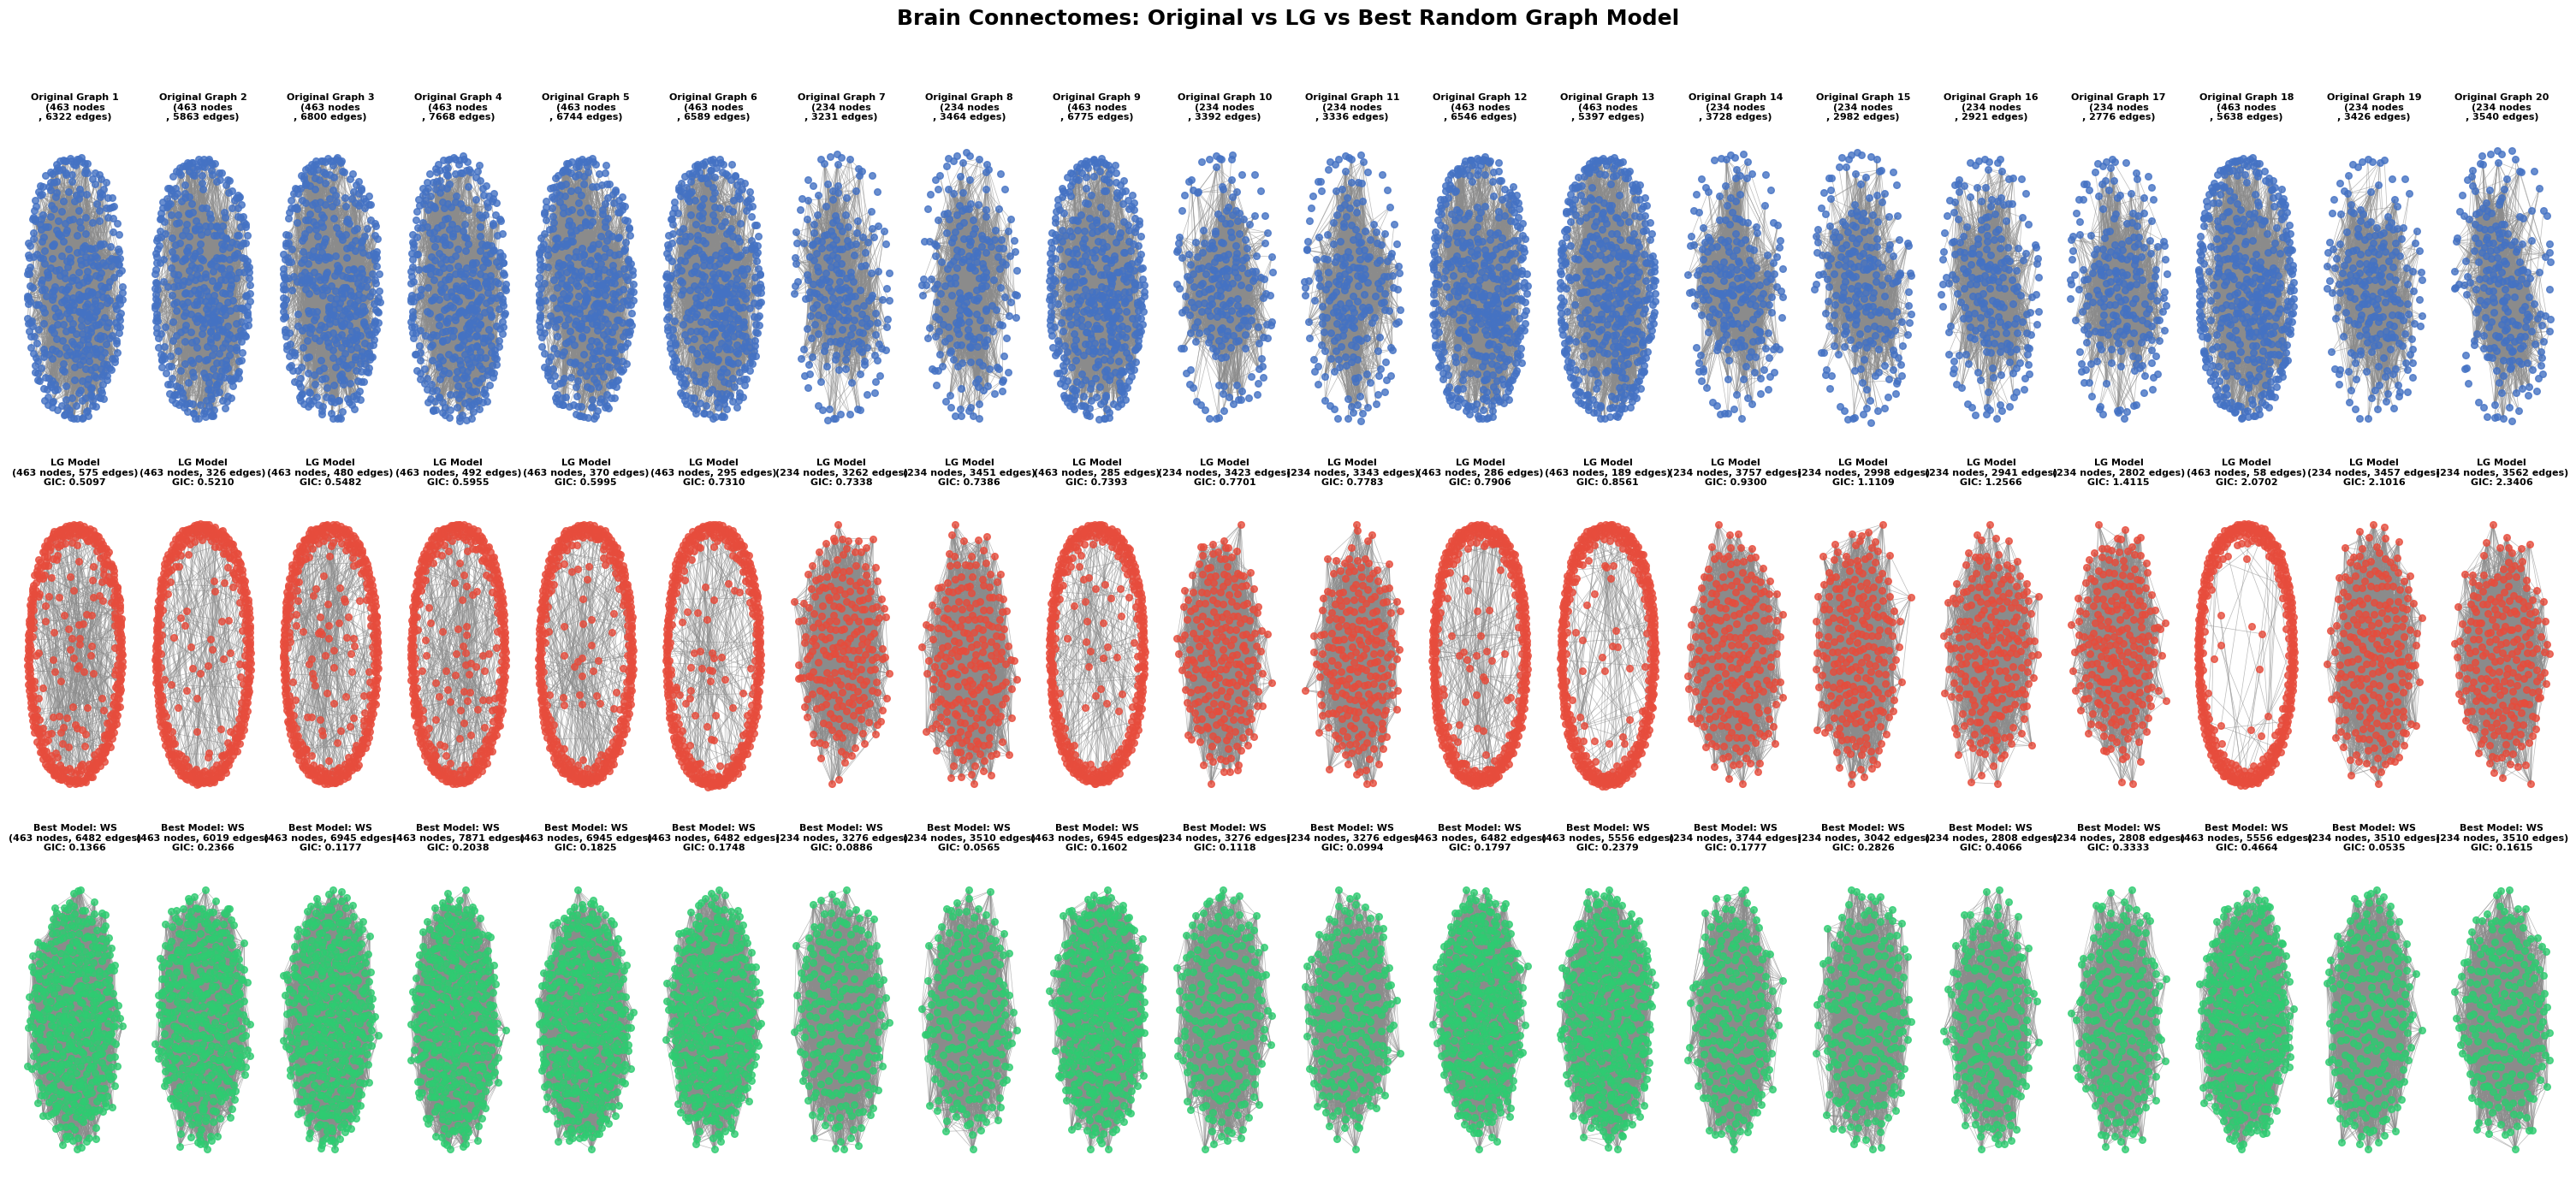

In [39]:
# Create the comparison visualization
def visualize_model_comparison(results, figsize=(25, 15), node_size=30, font_size=8, edge_width=0.5):
    """
    Visualize original graphs vs LG vs best fitting model for each graph.
    
    Parameters:
    -----------
    results : dict
        Results from fit_multiple_models_to_dataset
    figsize : tuple
        Figure size
    node_size : int
        Size of nodes
    font_size : int
        Font size for labels
    edge_width : float
        Width of edges
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The created figure
    """
    graph_results = results['graph_results']
    
    # Sort graph results by the GIC of the LG graph
    graph_results.sort(key=lambda x: x['models']['LG']['gic_value'] if x['models']['LG']['fit_success'] else float('inf'))
    
    n_graphs = len(graph_results)
    
    # Create subplot grid: 3 rows (original, LG, best model), n_graphs columns
    fig, axes = plt.subplots(3, n_graphs, figsize=figsize)
    
    # Handle single graph case
    if n_graphs == 1:
        axes = axes.reshape(3, 1)
    
    # Color schemes
    original_color = '#4472C4'    # Blue for original
    lg_color = '#E74C3C'          # Red for LG
    best_color = '#2ECC71'        # Green for best model
    edge_color = '#8B8B8B'        # Gray for edges
    
    for i, graph_result in enumerate(graph_results):
        original_graph = graph_result['original_graph']
        lg_data = graph_result['models']['LG']
        
        # Find best model (lowest GIC)
        valid_models = {name: data for name, data in graph_result['models'].items() 
                       if data['fit_success'] and not np.isinf(data['gic_value'])}
        
        if valid_models:
            best_model_name = min(valid_models.keys(), key=lambda k: valid_models[k]['gic_value'])
            best_model_data = valid_models[best_model_name]
        else:
            best_model_name = "None"
            best_model_data = None
        
        # Plot original graph (top row)
        ax_orig = axes[0, i]
        pos_orig = nx.spring_layout(original_graph, k=1, iterations=50, seed=42)
        
        nx.draw_networkx_edges(original_graph, pos_orig, ax=ax_orig,
                              edge_color=edge_color, width=edge_width, alpha=0.6)
        nx.draw_networkx_nodes(original_graph, pos_orig, ax=ax_orig,
                              node_color=original_color, node_size=node_size, alpha=0.8)
        
        ax_orig.set_title(f'Original Graph {i+1}\n({graph_result["original_nodes"]} nodes\n, {graph_result["original_edges"]} edges)',
                         fontsize=font_size+2, fontweight='bold', pad=10)
        ax_orig.axis('off')
        
        # Plot LG fitted graph (middle row)
        ax_lg = axes[1, i]
        
        if lg_data['fitted_graph'] is not None and lg_data['fit_success']:
            pos_lg = nx.spring_layout(lg_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(lg_data['fitted_graph'], pos_lg, ax=ax_lg,
                                  node_color=lg_color, node_size=node_size, alpha=0.8)
            
            title = f'LG Model\n({lg_data["fitted_nodes"]} nodes, {lg_data["fitted_edges"]} edges)\nGIC: {lg_data["gic_value"]:.4f}'
        else:
            title = f'LG Model\n(Fitting Failed)'
        
        ax_lg.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_lg.axis('off')
        
        # Plot best model (bottom row)
        ax_best = axes[2, i]
        
        if best_model_data is not None and best_model_data['fitted_graph'] is not None:
            pos_best = nx.spring_layout(best_model_data['fitted_graph'], k=1, iterations=50, seed=42)
            
            nx.draw_networkx_edges(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  edge_color=edge_color, width=edge_width, alpha=0.6)
            nx.draw_networkx_nodes(best_model_data['fitted_graph'], pos_best, ax=ax_best,
                                  node_color=best_color, node_size=node_size, alpha=0.8)
            
            title = f'Best Model: {best_model_name}\n({best_model_data["fitted_nodes"]} nodes, {best_model_data["fitted_edges"]} edges)\nGIC: {best_model_data["gic_value"]:.4f}'
        else:
            title = f'Best Model: {best_model_name}\n(No valid fits)'
        
        ax_best.set_title(title, fontsize=font_size+2, fontweight='bold', pad=10)
        ax_best.axis('off')
    
    # Add overall title
    fig.suptitle('Brain Connectomes: Original vs LG vs Best Random Graph Model', 
                fontsize=18, fontweight='bold', y=0.95)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.92])
    return fig


fig_model_comparison = visualize_model_comparison(
    model_results, 
    figsize=(30, 15), 
    node_size=30, 
    font_size=6, 
    edge_width=0.5
)

In [33]:
import pickle
import os
os.makedirs(f'runs/fitting_results_braingraph_multiple_datasets', exist_ok=True)

# Save the complete results
with open(f'runs/fitting_results_braingraph_multiple_datasets/model_comparison_results.pkl', 'wb') as f:
    pickle.dump(model_results, f)


os.makedirs(f'../images/model_comparison_braingraph_multiple_datasets', exist_ok=True)
os.makedirs(f'runs/model_comparison_braingraph_multiple_datasets', exist_ok=True)
model_results['summary_df'].to_csv(f'runs/model_comparison_braingraph_multiple_datasets/model_comparison_results.csv', index=False)
df_graph_attr.to_csv(f'runs/model_comparison_braingraph_multiple_datasets/graph_attributes.csv', index=False)

# Save the figure
with open(f'../images/model_comparison_braingraph_multiple_datasets/model_comparison_graphs.pkl', 'wb') as f:
    pickle.dump(fig_model_comparison, f)



In [34]:
'finish'

'finish'

In [40]:
df_graph_attr

graph_id     model  gic_value  fit_success  degree_centrality_mean  \
0           1  Original        NaN         True                0.109387   
1           1        LG   1.110866         True                0.109974   
2           1        WS   0.282638         True                0.111588   
3           1        BA   0.579017         True                0.008547   
4           1        ER   2.658253         True                0.889586   
..        ...       ...        ...          ...                     ...   
115        20        LG   2.070250         True                0.000542   
116        20        WS   0.466363         True                0.051948   
117        20        BA   0.549381         True                0.004320   
118        20        ER   1.380078         True                0.119510   
119        20       GRG   3.931413         True                0.972016   

     degree_centrality_std  betweenness_centrality_mean  \
0                 0.082051                     0.004088   
1                 0.020930                     0.004071   
2                 0.014904                     0.004009   
3                 0.014782                     0.017496   
4                 0.021120                     0.000476   
..                     ...                          ...   
115               0.001581                     0.000010   
116               0.007185                     0.002641   
117               0.006288                     0.011697   
118               0.014618                     0.001913   
119               0.039787                     0.000061   

     betweenness_centrality_std  closeness_centrality_mean  \
0                      0.014818                   0.309405   
1                      0.001632                   0.514677   
2                      0.001131                   0.518259   
3                      0.070779                   0.206990   
4                      0.000025                   0.900890   
..                          ...                        ...   
115                    0.000098                   0.001117   
116                    0.000742                   0.451276   
117                    0.054314                   0.162433   
118                    0.000468                   0.531475   
119                    0.000013                   0.974141   

     closeness_centrality_std  ...  eigenvector_centrality_std  \
0                    0.142837  ...                    0.040396   
1                    0.014153  ...                    0.012599   
2                    0.009252  ...                    0.009083   
3                    0.044741  ...                    0.058563   
4                    0.017075  ...                    0.001536   
..                        ...  ...                         ...   
115                  0.003430  ...                    0.045847   
116                  0.011697  ...                    0.006657   
117                  0.031534  ...                    0.042833   
118                  0.004424  ...                    0.005832   
119                  0.035275  ...                    0.001837   

     clustering_coefficient_mean  clustering_coefficient_std  \
0                       0.604775                    0.314802   
1                       0.113866                    0.019687   
2                       0.109282                    0.016268   
3                       0.000000                    0.000000   
4                       0.889653                    0.000983   
..                           ...                         ...   
115                     0.000000                    0.000000   
116                     0.048205                    0.012960   
117                     0.000000                    0.000000   
118                     0.119698                    0.008866   
119                     0.975580                    0.003895   

     average_path_length  diameter   density  transitivity  assortativity  \
0          